## Downsampling Sensitivity Analysis

This notebook will process downsampled results (2k to 30k read depth downsamples) for each platform and replicate. Each downsample was performed with seqtk's two-pass method (All downsampling was performed by the software seqtk version 1.4 (https://github.com/lh3/seqtk) with the flags sample -2 -s100). The samples were run using each platform's internal bioinformatics pipeline and then processed into either .h5 or .h5ad format to use with AnnData and Scanpy. The downsampled depths will also depend on the number of cells identified in the bioinformatics pipeline run on the downsampled data, so we will look at results for both targeted and aactual depths. 

We will get raw, unprocessed cell counts for each pipeline. We will then calculate median (and mean) gene counts and UMI counts for raw, unprocessed count matrix results. In other words, we will get pure platform output results for observations identified as cells with each pipeline's internal caller. We will not do any further processing to identify high quality cells.

We will then assess a kernel density estimator and otsu based caller on the downsampled results to see if cell calling is more stable with the internal callers or a universal caller. For these, since we are doing a custom caller, we will first filter the cells and genes to keep only with at least 5 genes and genes with at least 3 cells. This initial filtering has been used in https://www.nature.com/articles/s41587-023-01881-x#Sec11 and it serves as an initial pass to clean up the raw data to make it easier for the otsu and kde algorithm to perform since it removes outliers at the low end that skew both otsu and kde since they remove abundant low umi peaks.

Lastly, all paths have been scrubbed from this notebook, and this notebook **cannot be run directly using the AnnData objects provided by CellxGene**. The data here requires running each pipeline/kit's bioinformatics tool on the downsampled data, which is out of the scope of this repo, so this notebook just serves as a reference for how the downsampled anndata objects were analyzed once they were available.

In [1]:
##Import necessary packages
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as sch
import math
import re
import os
import sys
import time
import warnings
from tqdm import tqdm
from skimage.filters import threshold_multiotsu, threshold_otsu
from scipy.optimize import minimize_scalar
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

In [2]:
##generic plotting parameters for paper
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams.update({'font.size': 10})
mpl.rcParams["font.family"] = "arial"

##plotting order by type
plotting_order = ['10X_3-rep1', '10X_3-rep2','10X_5-rep1', '10X_5-rep2', '10X_FRP-rep1','10X_FRP-rep2','Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3', ##droplet
                  'BD-rep1', 'BD-rep2', 'Honeycomb-rep1','Honeycomb-rep2', ##well-based
                  'Parse-rep1','Scale-rep1', ##combinatorial
                  'Scipio-rep1', 'Scipio-rep2' ] ##matrigel

In [1]:
##LOAD CUSTOM FUNCTIONS FROM FUNCTIONS DIRECTORY IN REPO

##Note: These function files load their own necessary packages, so we don't need to load these dependencies here

##define function location
functions_dir = ##INSERT HERE

##if the directory is not in path, add
if functions_dir not in sys.path:
    sys.path.append(functions_dir)

##import functions
from get_statistics_functions import load_AnnData, load_raw_AnnData ##import all relevant processing functions
import highly_deviant_genes as hdg ##import all relevant highly deviant gene detection functions

In [4]:
##set directories
data_dir= ##INSERT HERE count matrices folder
parent_dir=##INSERT HERE
figure_dir=##INSERT HERE
supplement_dir=os.path.join(figure_dir, 'supplement')
supplement_fig_dir=os.path.join(supplement_dir, 'figures')
supplement_table_dir=os.path.join(supplement_dir, 'tables')

##make figure directories if they doesn't exist
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(supplement_fig_dir, exist_ok=True)
os.makedirs(supplement_table_dir, exist_ok=True)

In [5]:
##Whether to process all data or load
process_all_downsamples = False
process_all_downsamples_kde = False
process_all_downsamples_otsu = False

In [6]:
if process_all_downsamples is True:

    ##Load relevant matrix result files (internal pipeline filtered cells)

    ##Get filenames for predictions into a dictionary (Set key as method with sampling depth)
    filtered_files = {re.match(r'(.*?_[0-9]+k).*filtered_feature_bc_matrix', f).group(1) : os.path.join(data_dir, f) 
                     for f in os.listdir(data_dir) 
                     if re.match(r'.*filtered_feature_bc_matrix', f)}

    ##sort files by keys
    filtered_files = dict(sorted(filtered_files.items()))
    
    ##replace Hive with Honeycomb
    filtered_files = {key.replace('Hive', 'Honeycomb'): value for key, value in filtered_files.items()}
    
    ##replace Parse-rep2 with Parse-rep1 since only using one replicate
    filtered_files = {key.replace('Parse-rep2', 'Parse-rep1'): value for key, value in filtered_files.items()}
    
    ##create lists and dictionaries we will use
    summary_df = [] ##list to store metadata and summary data for each platform

    ##Load Count Data for each key and get summary gene, umi, and cell counts
    ##Also extract method, replicate, and downsampling depth from index and remove the "p" from 10X_3p and 10X_5p so it matches other figures
    for key, file in filtered_files.items():

        ##split method and depth with regex using the underscore after rep[0-0] to split
        match = re.match(r"(.*rep[0-9]+)_(.*k)$", key)
        method = match.group(1) ##matches the method before the underscore
        depth = match.group(2)[:-1]  #matches the depth after the underscore and removes the "k" to make numberic

        ##If method starts with "10X_3p" or "10X_5p", replace "p" with an empty string to match other figures
        ##Also, replace Fluent-rep1 with Fluent-rep3 (the repeat experiment since Fluent-rep1 was an outlier)
        if method.startswith("10X_3p"):
            method = re.sub("10X_3p-rep", "10X_3-rep", method)
        elif method.startswith("10X_5p"):
            method = re.sub("10X_5p-rep", "10X_5-rep", method)
        elif method.startswith("BD_Rhapsody"):
            method = re.sub("BD_Rhapsody-rep", "BD-rep", method)
  
        ##message for which platform and downsample we are doing
        print(f"Processing {method} at depth {depth} ...")

        ##Load count matrix so we can get summaries (load meethod depends on filename)
        if re.match(r'.*10X.*', file):
            adata = load_raw_AnnData(file)
        else:
            adata = load_AnnData(file)

        #get summary stats including gene counts and umi counts per object (No need to calculate log1p transformed qc stats)
        sc.pp.calculate_qc_metrics(adata, log1p = False, inplace=True)

        ##Get summary stats for each platform downsample
        summary_df.append({'key':f'{method}_{depth}k','file_tag':key, 'method': method, 'target_depth_tens': depth,
                           'n_cells':adata.shape[0], 
                           'median_gene_counts': np.median(adata.obs['n_genes_by_counts']),
                           'median_umi_counts': np.median(adata.obs['total_counts']), 
                           'mean_gene_counts': np.mean(adata.obs['n_genes_by_counts']),
                           'mean_umi_counts': np.mean(adata.obs['total_counts']),
                           'sd_gene_counts': np.std(adata.obs['n_genes_by_counts']),
                           'sd_umi_counts': np.std(adata.obs['total_counts'])
                          })

        ##delete for memory
        del adata



    ##Convert to dataframe
    summary_df = pd.DataFrame(summary_df)
    summary_df.set_index('key', inplace = True) ##set key as index
    summary_df.index.name=None ##remove index name
    summary_df['target_depth_tens'] = summary_df['target_depth_tens'].astype(int) ##convert depth to integer
    
    ##The following adds original cell counts to help us calculate actual depth rather than targeted depth
    
    ##original cell counts
    original_cell_counts = {
        "10X_3-rep1": 8553,
        "10X_3-rep2": 11296,
        "10X_5-rep1": 8514,
        "10X_5-rep2": 8156,
        "10X_FRP-rep1": 10347,
        "10X_FRP-rep2": 8081,
        "BD-rep1": 11342,
        "BD-rep2": 16834,
        "Fluent-rep1": 10804,
        "Fluent-rep2": 9614,
        "Fluent-rep3": 10105,
        "Honeycomb-rep1": 10000,
        "Honeycomb-rep2": 10000,
        "Parse-rep1": 15578, ##renamed rep2 as rep1 since using only 1 replicate
        "Scale-rep1": 12048,
        "Scipio-rep1": 3424,
        "Scipio-rep2": 4548
    }

    ##calculate Target Readcounts (ie readcount we targetted to get desired depth given original cell counts)
    targeted_reads={}
    for k in list(range(2,32,2)):

        ##get depth
        depth=k*1000

        ##Loop through each platform to calc targetted reads per depth
        for method, og_cell in original_cell_counts.items():
            targeted_reads[f'{method}_{k}k'] = depth * og_cell

    ##Add these numbers back to summary df so we can compare targeted depth vs actual depth
    summary_df['targeted_fastq_reads'] = summary_df.index.map(targeted_reads)
    summary_df['target_depth']=summary_df['target_depth_tens']*1000
    summary_df['actual_depth']=summary_df['targeted_fastq_reads']/summary_df['n_cells']
    summary_df['actual_depth_tens']=summary_df['actual_depth']/1000
    
    ##Extract Platform name and replicate separately
    summary_df['platform'] = summary_df['method'].str.extract(r'(.*(?=-rep\d))')
    summary_df['replicate'] = summary_df['method'].str.extract(r'(rep[1-9])')
    
    ##save summary
    cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
    os.makedirs(cell_calling_dir, exist_ok=True)
    output_file = os.path.join(cell_calling_dir, "all_downsampled_internal_results.csv")

    summary_df.to_csv(output_file)
    
    
else:
    cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
    output_file = os.path.join(cell_calling_dir, "all_downsampled_internal_results.csv")
    summary_df = pd.read_csv(output_file, index_col=0)
    
    
summary_df

file_tag       method  target_depth_tens  n_cells  \
10X_3-rep1_10k   10X_3p-rep1_10k   10X_3-rep1                 10     8272   
10X_3-rep1_12k   10X_3p-rep1_12k   10X_3-rep1                 12     8298   
10X_3-rep1_14k   10X_3p-rep1_14k   10X_3-rep1                 14     8324   
10X_3-rep1_16k   10X_3p-rep1_16k   10X_3-rep1                 16     8350   
10X_3-rep1_18k   10X_3p-rep1_18k   10X_3-rep1                 18     8359   
...                          ...          ...                ...      ...   
Scipio-rep2_2k    Scipio-rep2_2k  Scipio-rep2                  2     4692   
Scipio-rep2_30k  Scipio-rep2_30k  Scipio-rep2                 30     4558   
Scipio-rep2_4k    Scipio-rep2_4k  Scipio-rep2                  4     4726   
Scipio-rep2_6k    Scipio-rep2_6k  Scipio-rep2                  6     4757   
Scipio-rep2_8k    Scipio-rep2_8k  Scipio-rep2                  8     4757   

                 median_gene_counts  median_umi_counts  mean_gene_counts  \
10X_3-rep1_10k               2136.0             4794.5       2169.904376   
10X_3-rep1_12k               2318.0             5431.0       2346.495180   
10X_3-rep1_14k               2474.0             6007.5       2492.430322   
10X_3-rep1_16k               2605.0             6523.5       2616.028623   
10X_3-rep1_18k               2722.0             6999.0       2725.257806   
...                             ...                ...               ...   
Scipio-rep2_2k                270.0              362.0        309.745098   
Scipio-rep2_30k               635.0             1082.0        705.581395   
Scipio-rep2_4k                372.5              536.5        423.854211   
Scipio-rep2_6k                429.0              647.0        486.048560   
Scipio-rep2_8k                468.0              722.0        528.050872   

                 mean_umi_counts  sd_gene_counts  sd_umi_counts  \
10X_3-rep1_10k       5195.427246      808.765046    2706.785889   
10X_3-rep1_12k       5882.826660      862.157520    3075.931152   
10X_3-rep1_14k       6492.460449      908.163372    3409.241211   
10X_3-rep1_16k       7037.778809      946.566760    3710.508789   
10X_3-rep1_18k       7539.133301      977.480074    3979.717285   
...                          ...             ...            ...   
Scipio-rep2_2k        439.918365      161.851277     282.048279   
Scipio-rep2_30k      1293.773560      302.379262     770.170166   
Scipio-rep2_4k        653.550964      210.663807     415.543671   
Scipio-rep2_6k        781.683838      235.233495     493.858673   
Scipio-rep2_8k        872.595093      250.504027     547.719727   

                 targeted_fastq_reads  target_depth  actual_depth  \
10X_3-rep1_10k               85530000         10000  10339.700193   
10X_3-rep1_12k              102636000         12000  12368.763557   
10X_3-rep1_14k              119742000         14000  14385.151370   
10X_3-rep1_16k              136848000         16000  16388.982036   
10X_3-rep1_18k              153954000         18000  18417.753320   
...                               ...           ...           ...   
Scipio-rep2_2k                9096000          2000   1938.618926   
Scipio-rep2_30k             136440000         30000  29934.181659   
Scipio-rep2_4k               18192000          4000   3849.344054   
Scipio-rep2_6k               27288000          6000   5736.388480   
Scipio-rep2_8k               36384000          8000   7648.517974   

                 actual_depth_tens platform replicate  
10X_3-rep1_10k           10.339700    10X_3      rep1  
10X_3-rep1_12k           12.368764    10X_3      rep1  
10X_3-rep1_14k           14.385151    10X_3      rep1  
10X_3-rep1_16k           16.388982    10X_3      rep1  
10X_3-rep1_18k           18.417753    10X_3      rep1  
...                            ...      ...       ...  
Scipio-rep2_2k            1.938619   Scipio      rep2  
Scipio-rep2_30k          29.934182   Scipio      rep2  
Scipio-rep2_4k            3.849344   Scipio     

### <center> Sensitivity Analysis of N Cells, Gene Counts, and UMI Counts

Now we will plot the number of cells, median gene counts, and median umi counts as a function of depth to assess the sensitivity and stability of these metrics at various depths

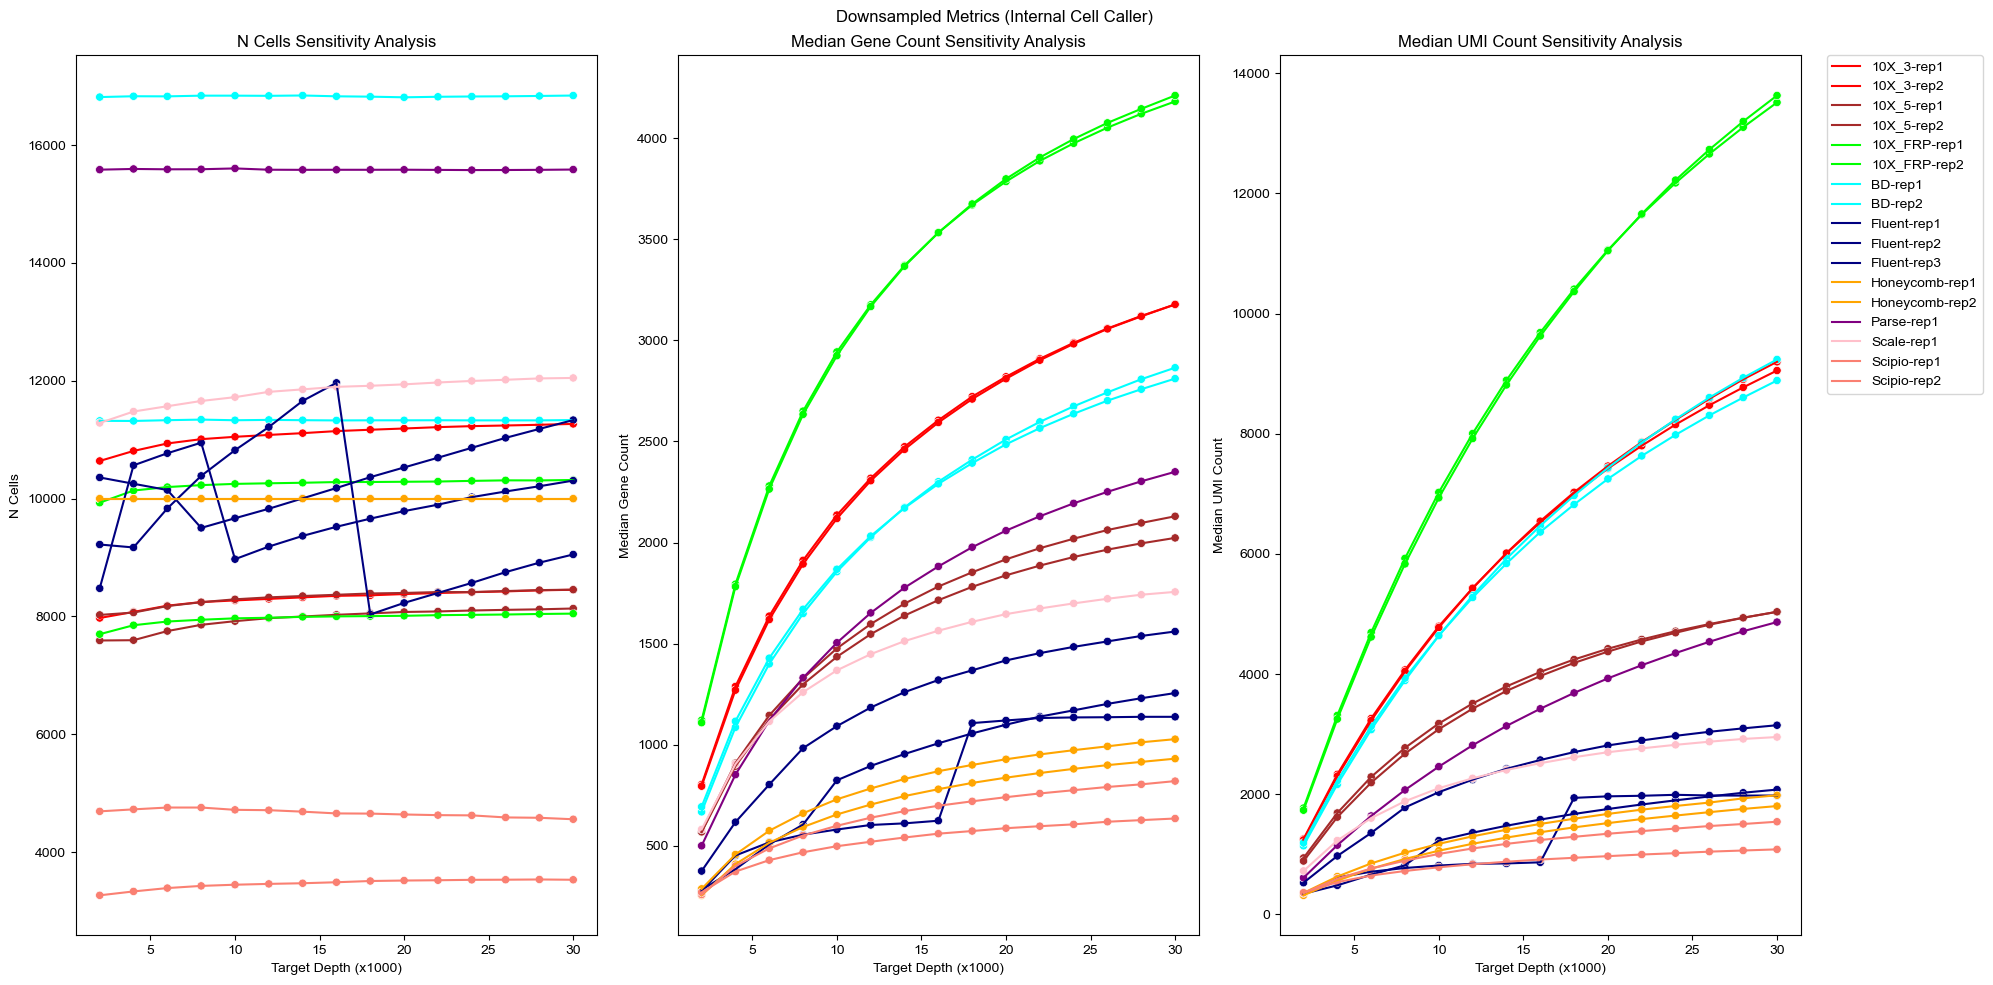

In [7]:
##Define color space for each platform
colors_platform = {'10X_3-rep1': 'red', '10X_3-rep2':'red', 
                   '10X_5-rep1':'brown', '10X_5-rep2':'brown', 
                   '10X_FRP-rep1':'lime', '10X_FRP-rep2':'lime', 
                   'BD-rep1':'cyan', 'BD-rep2':'cyan', 
                   'Fluent-rep1':'navy', 'Fluent-rep2':'navy', 'Fluent-rep3':'navy',
                   'Honeycomb-rep1':'orange', 'Honeycomb-rep2':'orange', 
                   'Parse-rep1':'purple', 
                   'Scale-rep1':'pink', 
                   'Scipio-rep1':'salmon', 'Scipio-rep2':'salmon'}



##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='target_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='target_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df, ax=axes[i], legend=False)

    # Give each subplot a title
    axes[i].set(xlabel = 'Target Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics (Internal Cell Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Let's look at coefficient of variation across depths for these metrics as a solid measure of stability (CV = SD/mean)

In [8]:
cv_df = summary_df.groupby('method')[['n_cells', 'median_gene_counts', 'median_umi_counts']].apply(lambda x: np.std(x, axis = 0) / np.mean(x, axis = 0)).reset_index(drop = False)
cv_df

method   n_cells  median_gene_counts  median_umi_counts
0       10X_3-rep1  0.016082            0.288461           0.391244
1       10X_3-rep2  0.015619            0.291277           0.397565
2       10X_5-rep1  0.015738            0.267487           0.331582
3       10X_5-rep2  0.022138            0.276740           0.342359
4     10X_FRP-rep1  0.009315            0.274219           0.400754
5     10X_FRP-rep2  0.011089            0.278074           0.407246
6          BD-rep1  0.000471            0.304039           0.411417
7          BD-rep2  0.000544            0.293054           0.396715
8      Fluent-rep1  0.050668            0.290488           0.342762
9      Fluent-rep2  0.066733            0.340244           0.397049
10     Fluent-rep3  0.129507            0.384508           0.484596
11  Honeycomb-rep1  0.000000            0.265635           0.343901
12  Honeycomb-rep2  0.000000            0.269019           0.348364
13      Parse-rep1  0.000462            0.314854           0.408988
14      Scale-rep1  0.018635            0.230477           0.282337
15     Scipio-rep1  0.022478            0.242601           0.300707
16     Scipio-rep2  0.012948            0.191178           0.236968

/local/42284323/ipykernel_26716/3737304695.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y=y_val, data=cv_df, ax=axes[i], palette = colors_platform, order=plotting_order)
/local/42284323/ipykernel_26716/3737304695.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/local/42284323/ipykernel_26716/3737304695.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y=y_val, data=cv_df, ax=axes[i], palette = colors_platform, order=plotting_order)
/local/42284323/ipykernel_26716/3737304695.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  

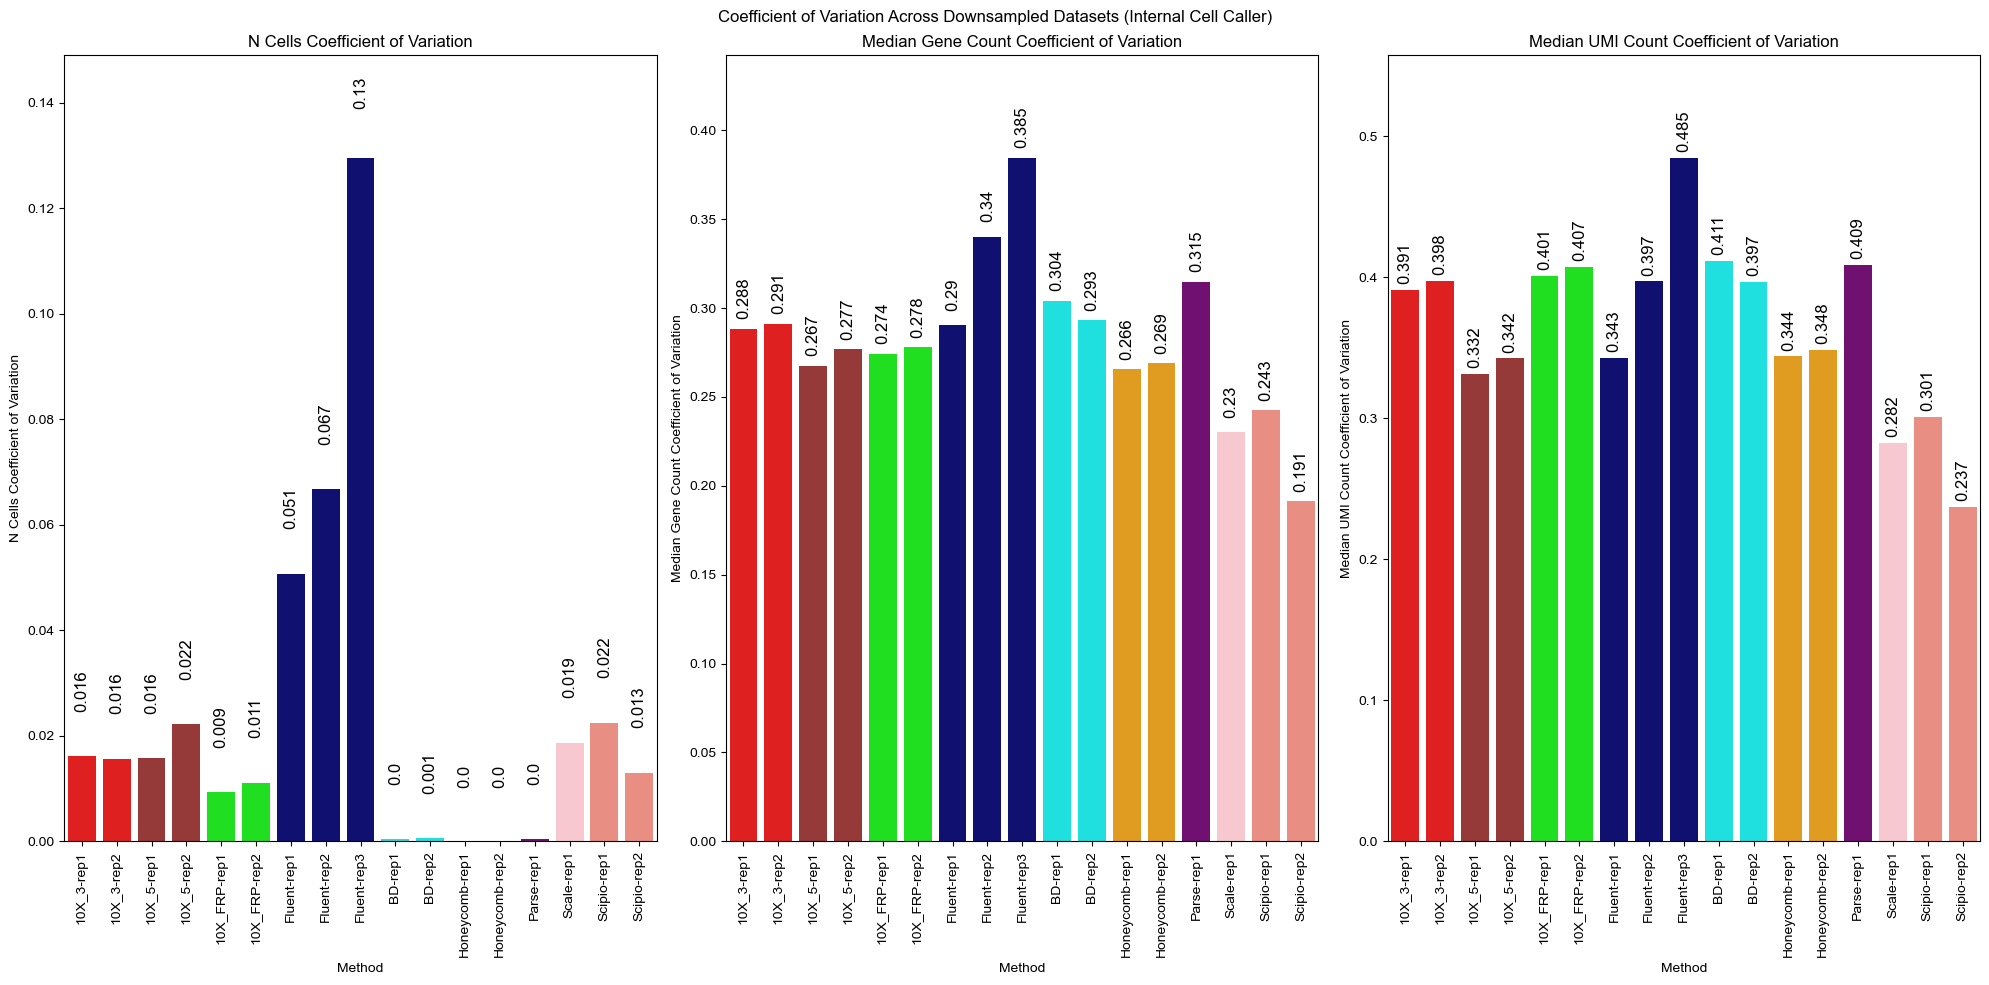

In [9]:
##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.barplot(x='method', y=y_val, data=cv_df, ax=axes[i], palette = colors_platform, order=plotting_order)

    # Give each subplot a title
    axes[i].set(xlabel = 'Method', ylabel = f"{y_lab} Coefficient of Variation")
    axes[i].set_title(f"{y_lab} Coefficient of Variation")
    
    ##rotate x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

    # Annotate bars with values
    heights = [] ##initialize list of heights to be used to set limit
    for j, p in enumerate(axes[i].patches):
        heights.append(p.get_height()*1.15)
        value_format = np.round(p.get_height(), 3)
        axes[i].annotate(value_format, 
                         (p.get_x() + p.get_width() / 2., p.get_height()+0.01), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points',
                         fontsize=12, 
                         rotation=90)

    ##adjust limits to the max of the heihgts
    axes[i].set_ylim([0, np.nanmax(np.array(heights)[np.isfinite(heights)])])

# Adjust the padding between and around the subplots
fig.suptitle("Coefficient of Variation Across Downsampled Datasets (Internal Cell Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Coefficient of Variation for only N Cells

/local/42284323/ipykernel_26716/1759702311.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='n_cells', data=cv_df, ax=ax, palette=colors_platform, order=plotting_order)


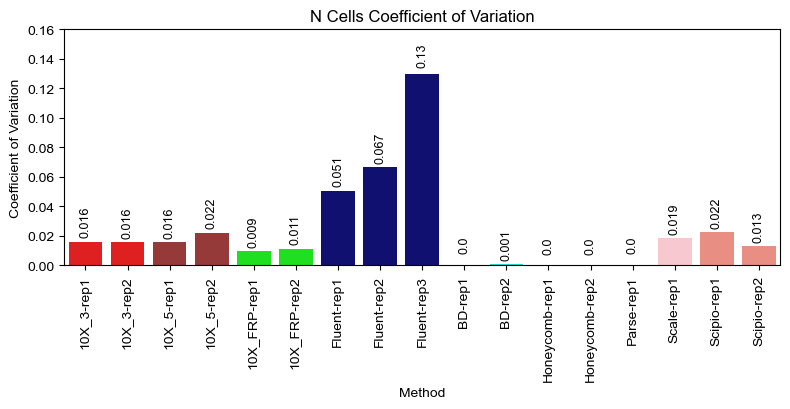

In [10]:
##Create subplot space with 3 rows (one for each metric)
fig, ax = plt.subplots(1, 1, figsize=(8,4.2))  ##figure size is 80mm x42mm

# Create line plot on ith subplot axes
sns.barplot(x='method', y='n_cells', data=cv_df, ax=ax, palette=colors_platform, order=plotting_order)

# Give each subplot a title
ax.set(xlabel = 'Method', ylabel = 'Coefficient of Variation')
ax.set_title(f"N Cells Coefficient of Variation")

##rotate x-axis labels
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='x', labelrotation = 90)

# Annotate bars with values
heights = [] ##initialize list of heights to be used to set limit
for j, p in enumerate(ax.patches):
    heights.append(p.get_height()*1.15)
    value_format = np.round(p.get_height(), 3)
    ax.annotate(value_format, 
                     (p.get_x() + p.get_width() / 2., p.get_height()+0.005), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=9, 
                     rotation=90)

##adjust limits to the max of the heihgts
ax.set_ylim([0, 0.16])

# Adjust the padding between and around the subplots
plt.tight_layout()

# Show the plot
plt.show()

Now let's look at the number of cells across all depth as a box plot

plot for slides

/local/42284323/ipykernel_26716/2177536240.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='n_cells', data=summary_df, ax=ax, palette=colors_platform,


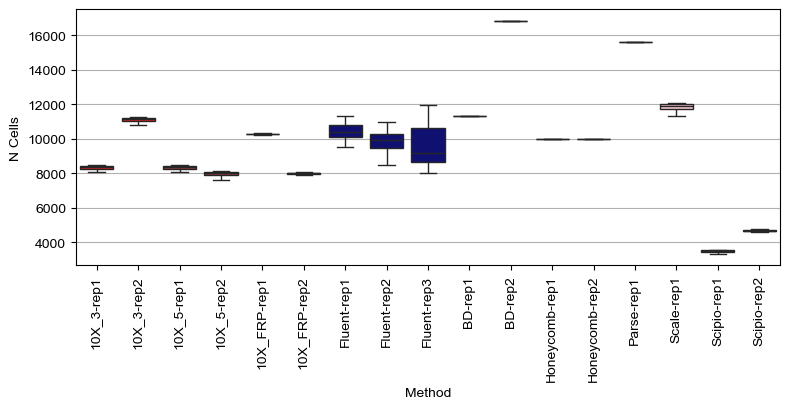

In [11]:
##Create subplot space with 3 rows (one for each metric)
fig, ax = plt.subplots(1, 1, figsize=(8,4.2))  ##figure size is 80mm x42mm

# Create line plot on ith subplot axes
sns.boxplot(x='method', y='n_cells', data=summary_df, ax=ax, palette=colors_platform, 
            linewidth=1, showfliers=False, order=plotting_order)

# Give each subplot a title
ax.set(xlabel = 'Method', ylabel = 'N Cells')
ax.grid(axis='y')
ax.set_axisbelow(True)

##rotate x-axis labels
ax.tick_params(axis='x', labelrotation = 90)

# Adjust the padding between and around the subplots
plt.tight_layout()

# Show the plot
plt.show()

Now Let's look at the plot as a function of the actual depth rather than targeted depth

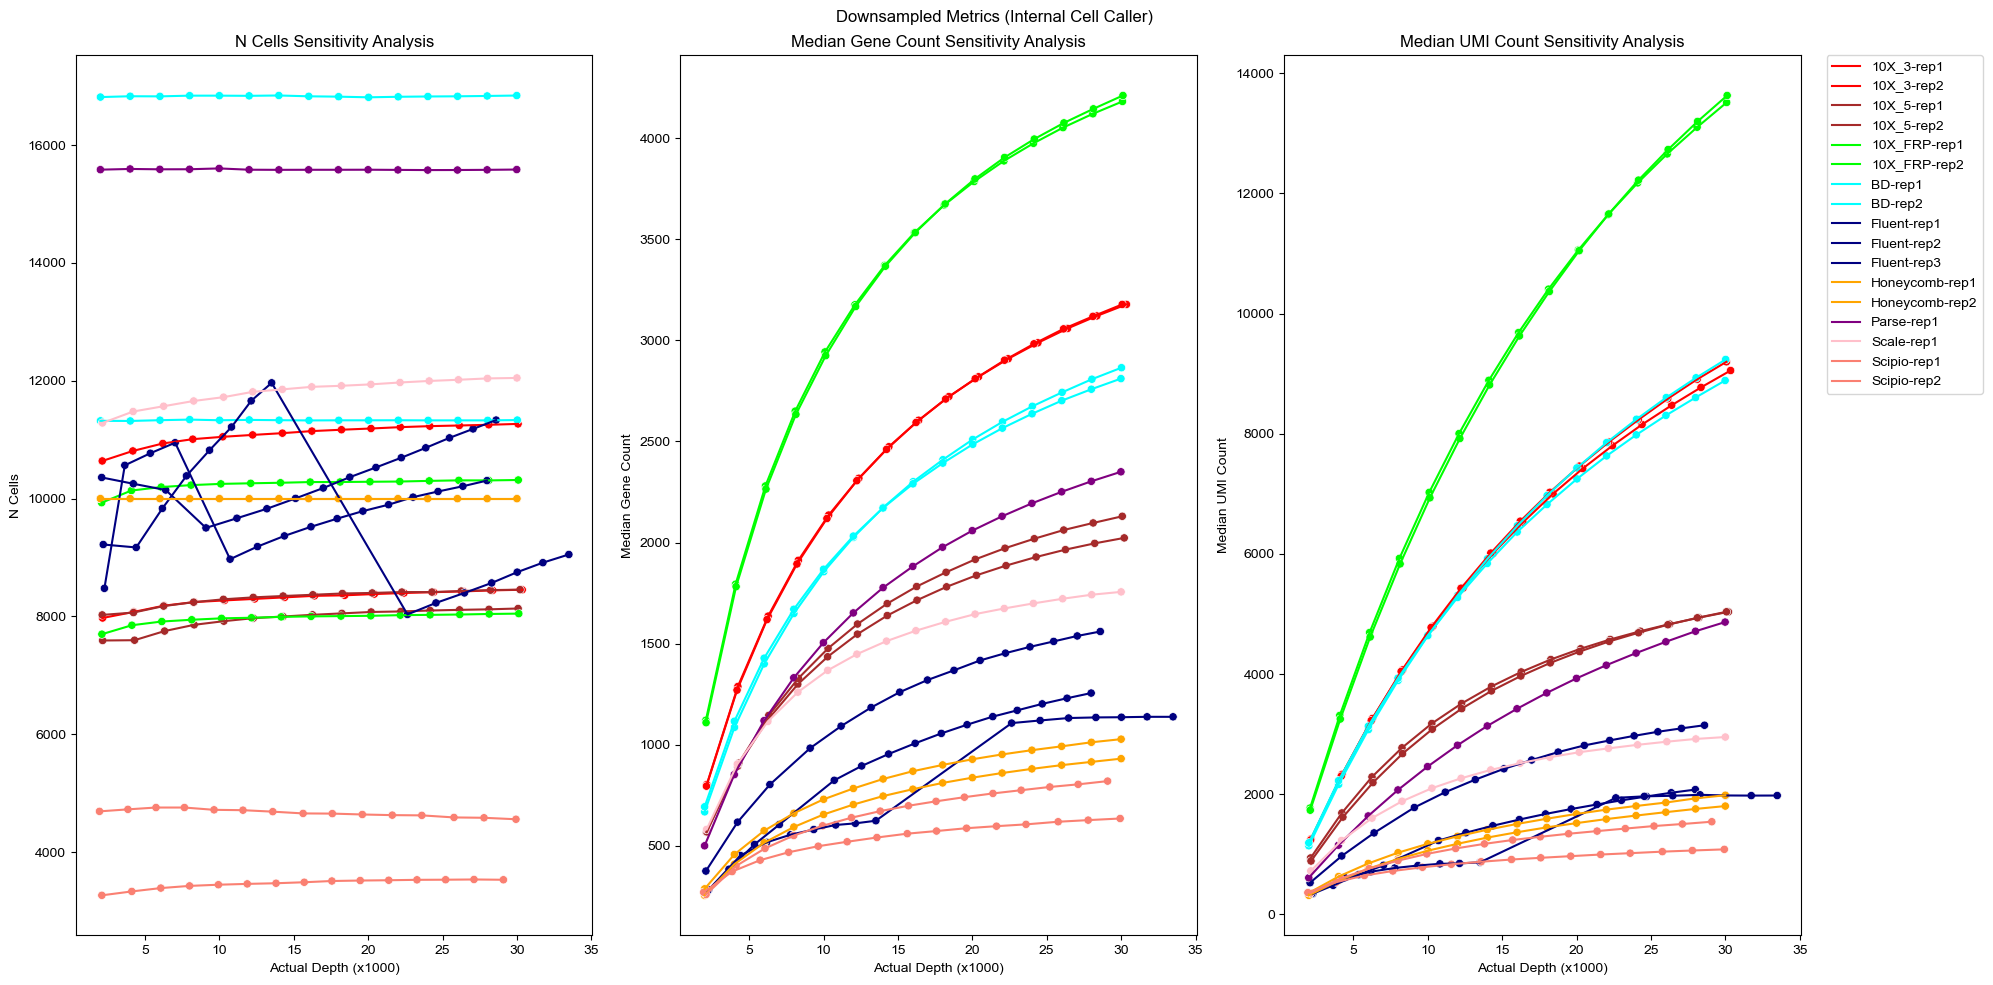

In [12]:
##Define color space for each platform

##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df, ax=axes[i], legend = False)

    # Give each subplot a title
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics (Internal Cell Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Plot only Gene Count and UMI Count for slides

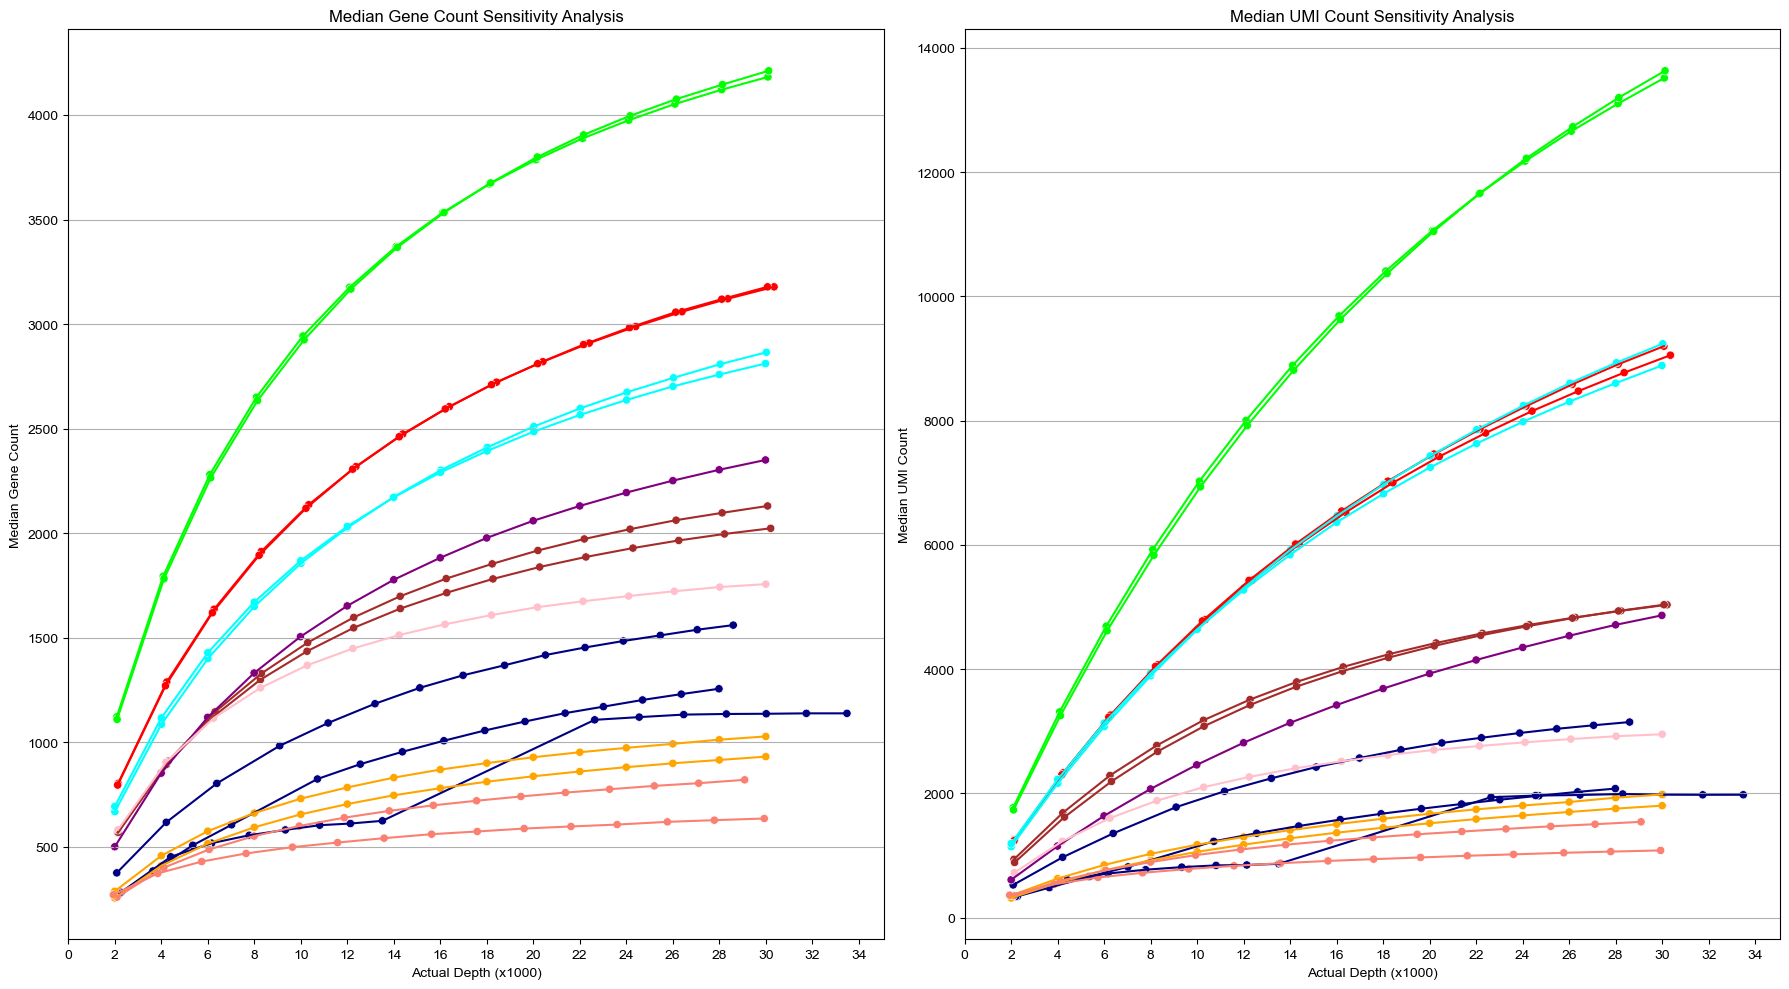

In [13]:
##Define color space for each platform
colors_platform = {'10X_3-rep1': 'red', '10X_3-rep2':'red', 
                   '10X_5-rep1':'brown', '10X_5-rep2':'brown', 
                   '10X_FRP-rep1':'lime', '10X_FRP-rep2':'lime', 
                   'BD-rep1':'cyan', 'BD-rep2':'cyan', 
                   'Fluent-rep1':'navy', 'Fluent-rep2':'navy', 'Fluent-rep3':'navy',
                   'Honeycomb-rep1':'orange', 'Honeycomb-rep2':'orange', 
                   'Parse-rep1':'purple', 
                   'Scale-rep1':'pink', 
                   'Scipio-rep1':'salmon', 'Scipio-rep2':'salmon'}



##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 2, figsize=(18, 10)) ##match paper dimension of 72MM x 40MM

##Create titles for each metric
y_labs = ['Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df, ax=axes[i], legend=False)

    # Give each subplot a title
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")
    axes[i].grid(axis='y')
    axes[i].xaxis.set_ticks(np.arange(0, np.max(summary_df['actual_depth_tens']) + 2, 2))
    
    # Remove legend from all plots
    axes[i].get_legend().remove()

# Adjust the padding between and around the subplots
plt.tight_layout()

# Show the plot
plt.show()

Plot only the N Cells for supplement

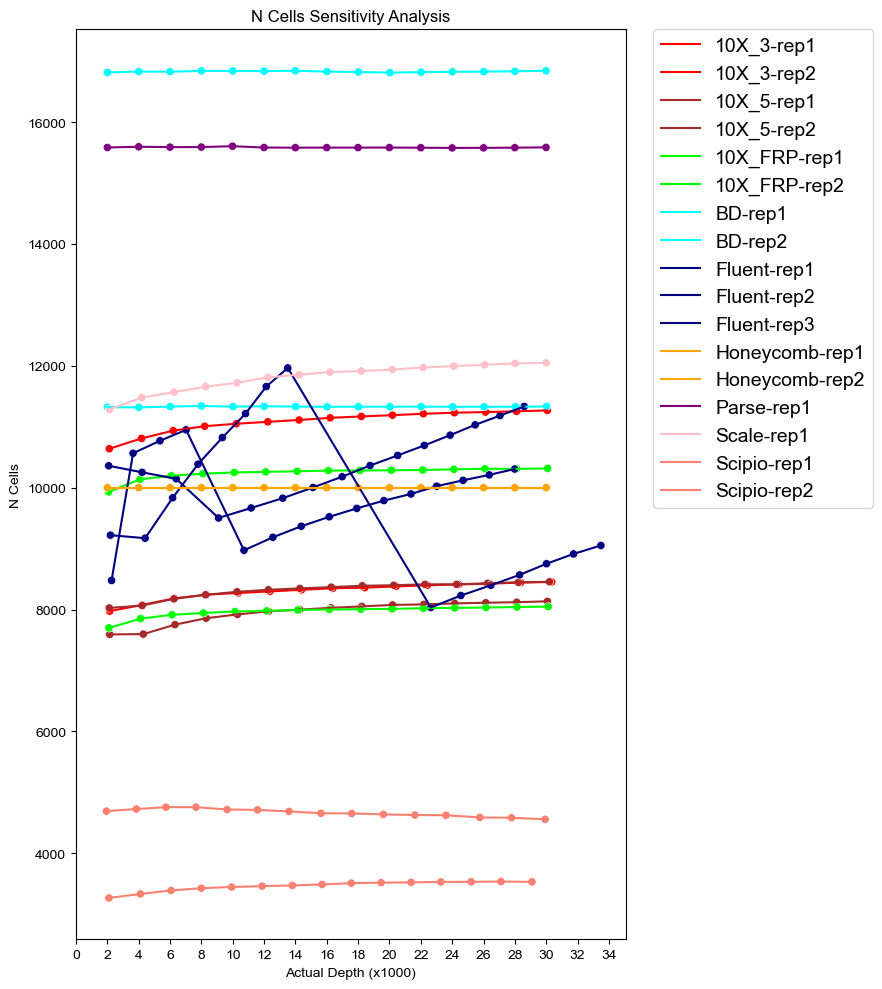

In [15]:
##Define color space for each platform
colors_platform = {'10X_3-rep1': 'red', '10X_3-rep2':'red', 
                   '10X_5-rep1':'brown', '10X_5-rep2':'brown', 
                   '10X_FRP-rep1':'lime', '10X_FRP-rep2':'lime', 
                   'BD-rep1':'cyan', 'BD-rep2':'cyan', 
                   'Fluent-rep1':'navy', 'Fluent-rep2':'navy', 'Fluent-rep3':'navy',
                   'Honeycomb-rep1':'orange', 'Honeycomb-rep2':'orange', 
                   'Parse-rep1':'purple', 
                   'Scale-rep1':'pink', 
                   'Scipio-rep1':'salmon', 'Scipio-rep2':'salmon'}



##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 1, figsize=(9, 10))  

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y='n_cells', hue='method', palette=colors_platform, data=summary_df, ax=axes)

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y='n_cells', hue='method', palette=colors_platform, data=summary_df, ax=axes, legend=False)

    # Give each subplot a title
    axes.set(xlabel = 'Actual Depth (x1000)', ylabel = 'N Cells')
    axes.set_title(f"N Cells Sensitivity Analysis")
    axes.xaxis.set_ticks(np.arange(0, np.max(summary_df['actual_depth_tens']) + 2, 2))

    # Add legend
    axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 14})

# Adjust the padding between and around the subplots
plt.tight_layout()

# Show the plot
plt.show()

Let's look at these metrics separately broken up by platform and replicate separately

N Cells:

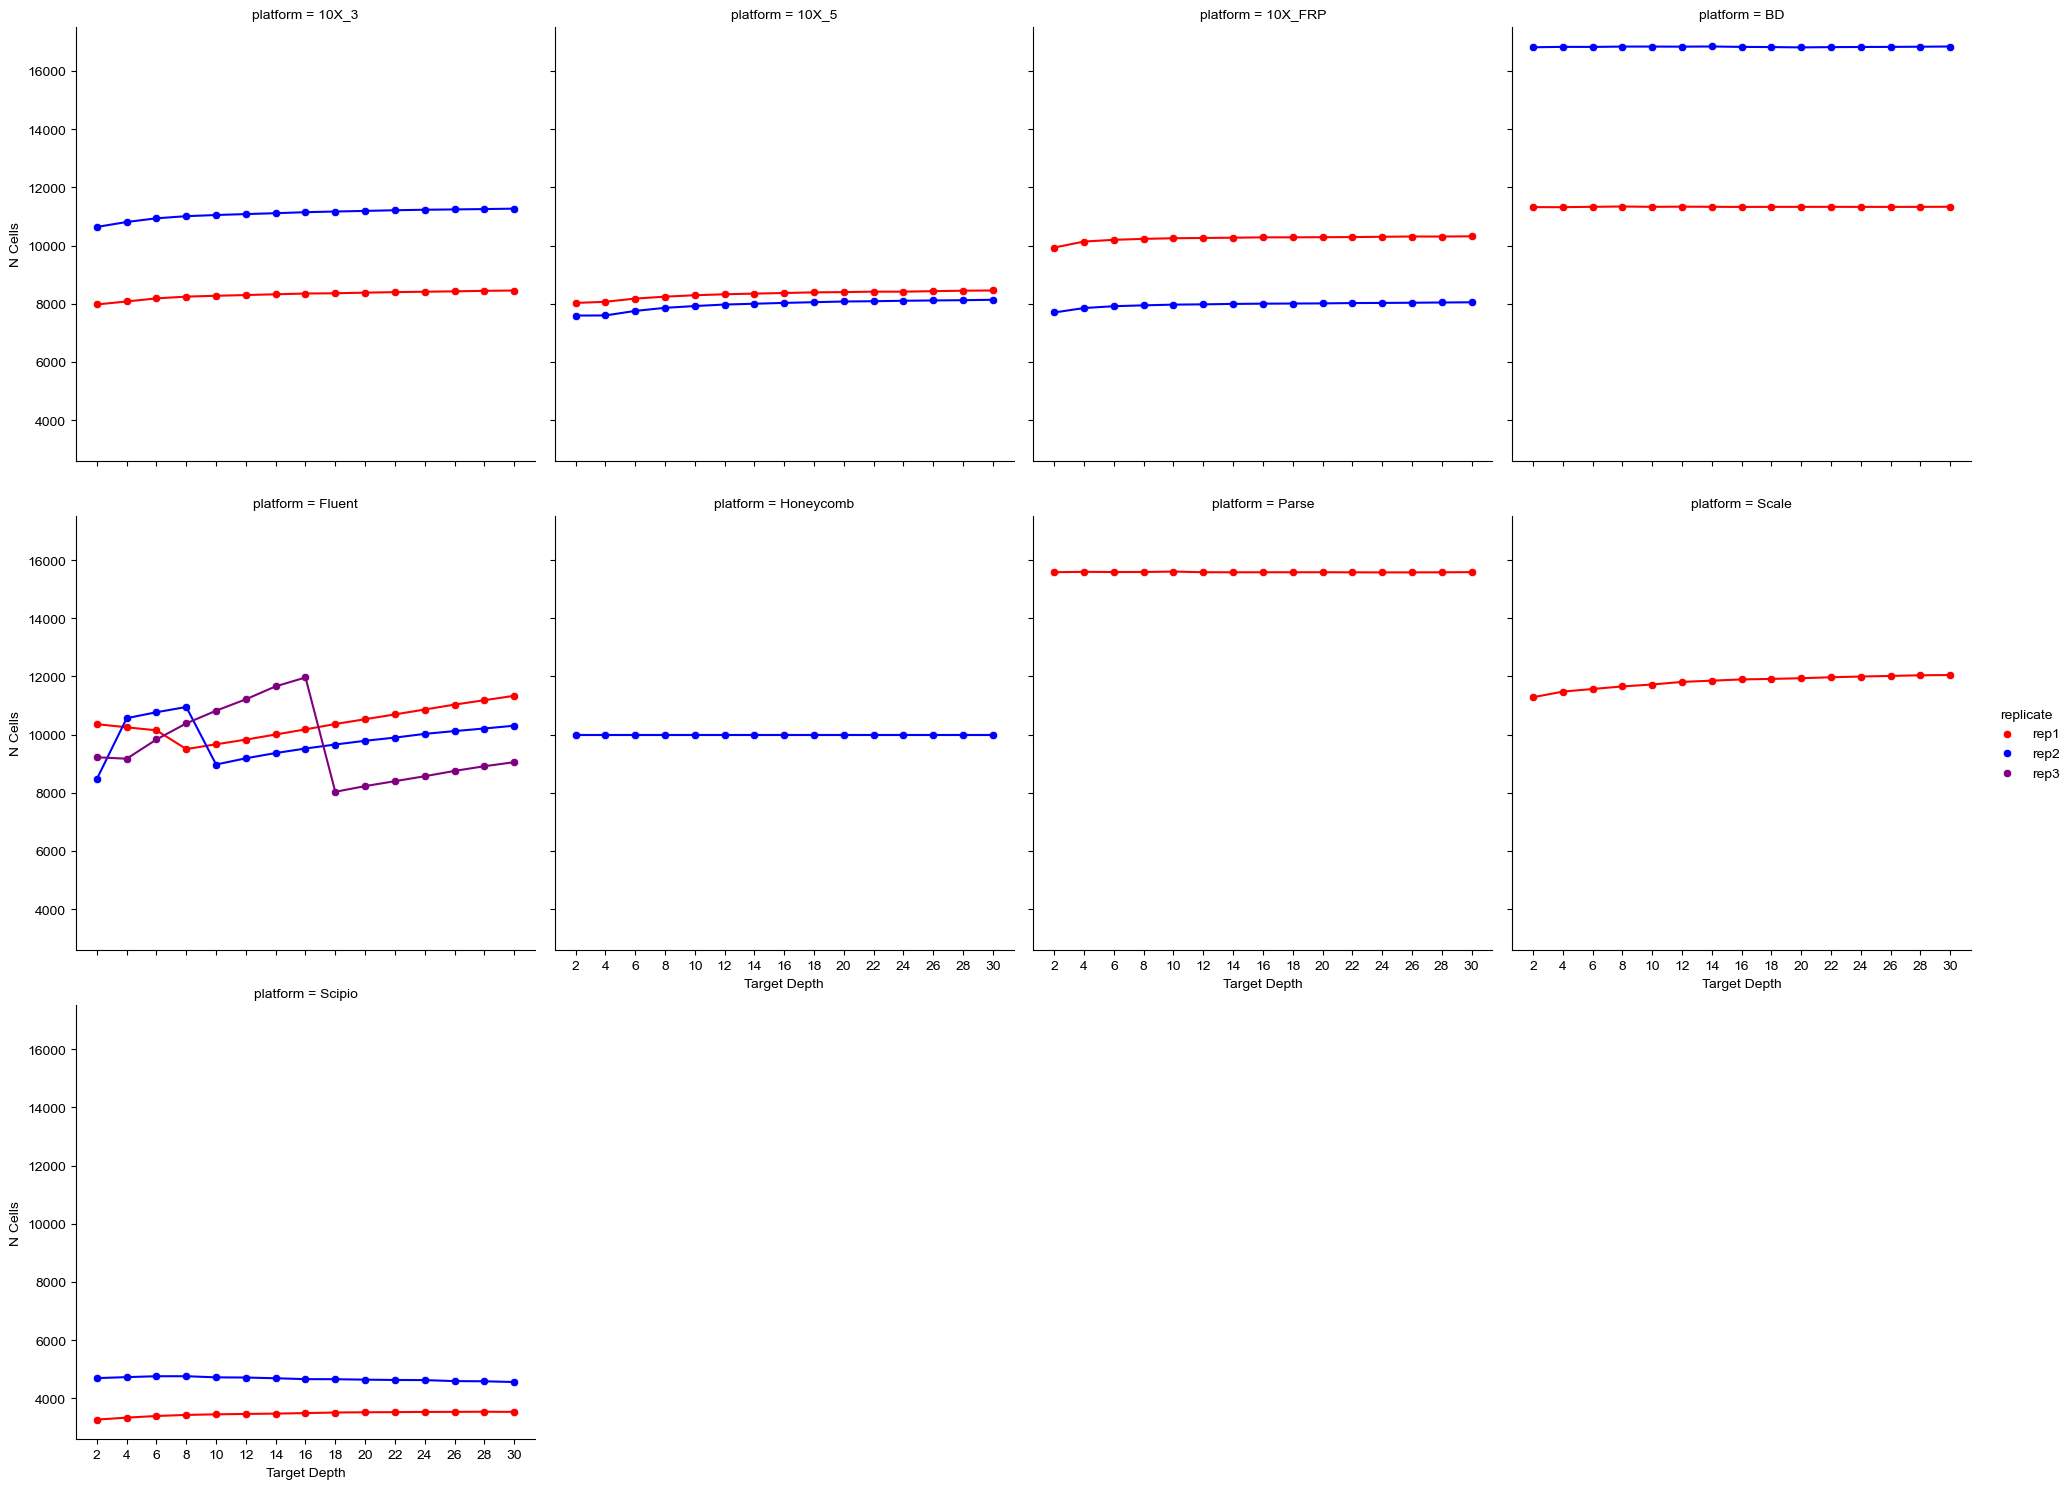

In [16]:
# Define color mapping for replicates
colors_replicate = {'rep1': 'red', 'rep2': 'blue', 'rep3': 'purple'}

##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a line plot to each facet
g.map(sns.lineplot, "target_depth_tens", "n_cells")

##Map a scatter plot to each facet
g.map(sns.scatterplot, "target_depth_tens", "n_cells")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Target Depth", "N Cells")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

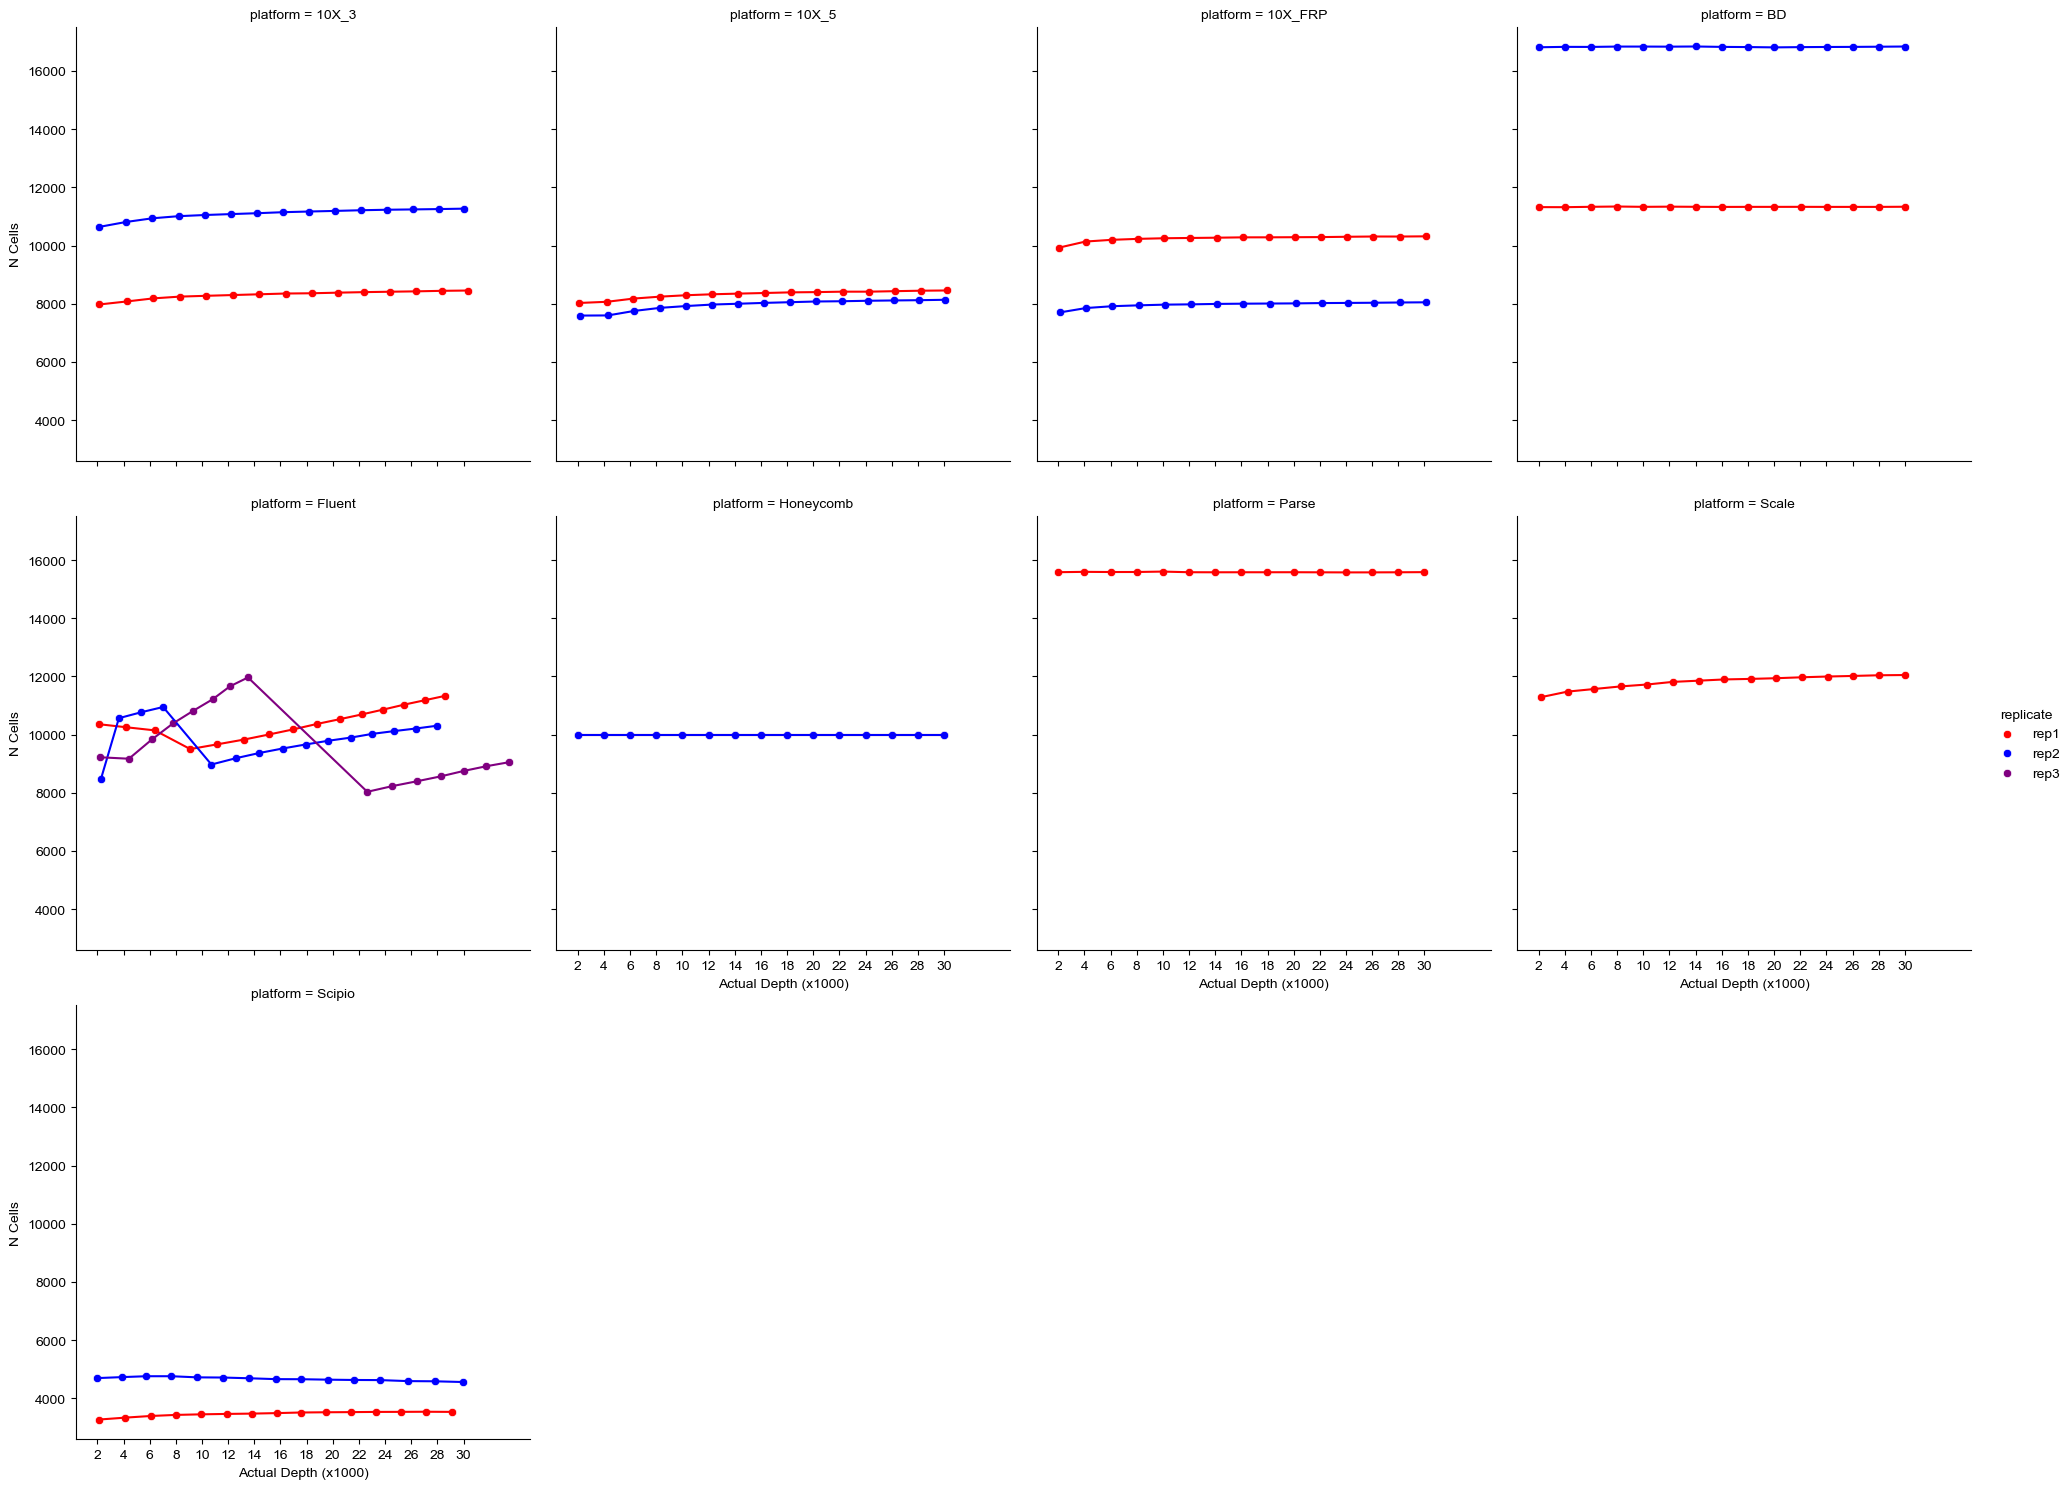

In [17]:
##Actual Depth

# Define color mapping for replicates
colors_replicate = {'rep1': 'red', 'rep2': 'blue', 'rep3': 'purple'}

##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a line plot to each facet
g.map(sns.lineplot, "actual_depth_tens", "n_cells")

##Map a scatter plot to each facet
g.map(sns.scatterplot, "actual_depth_tens", "n_cells")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Actual Depth (x1000)", "N Cells")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

Median Gene Count:

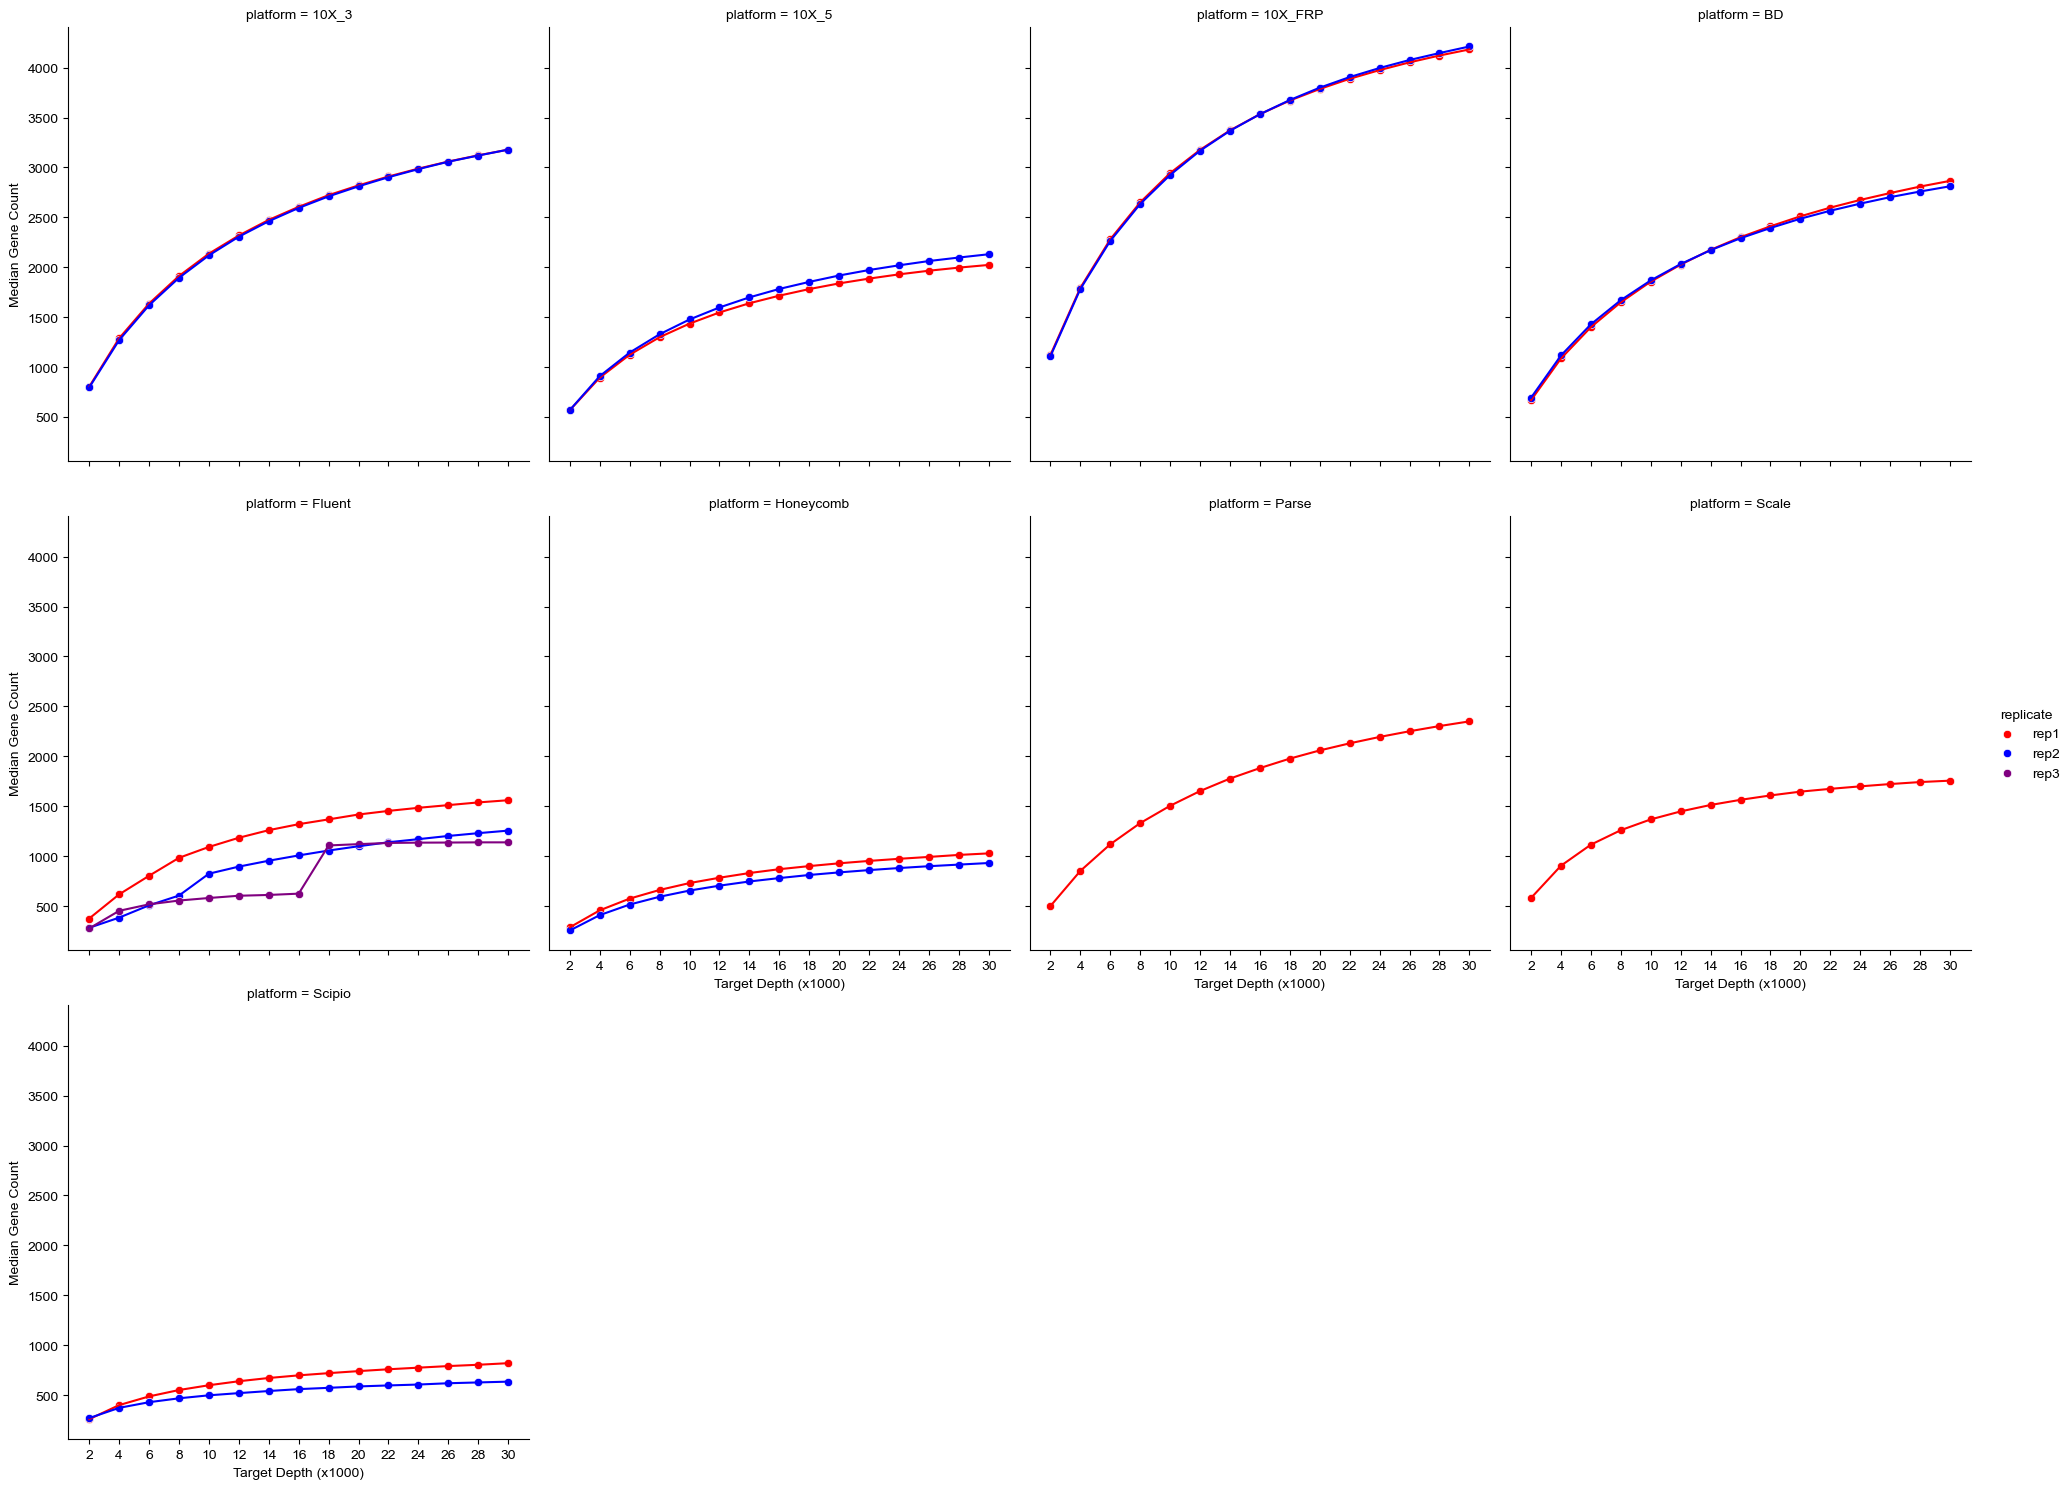

In [18]:
##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a line plot to each facet
g.map(sns.lineplot, "target_depth_tens", "median_gene_counts")

##Map a scatter plot to each facet
g.map(sns.scatterplot, "target_depth_tens", "median_gene_counts")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Target Depth (x1000)", "Median Gene Count")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

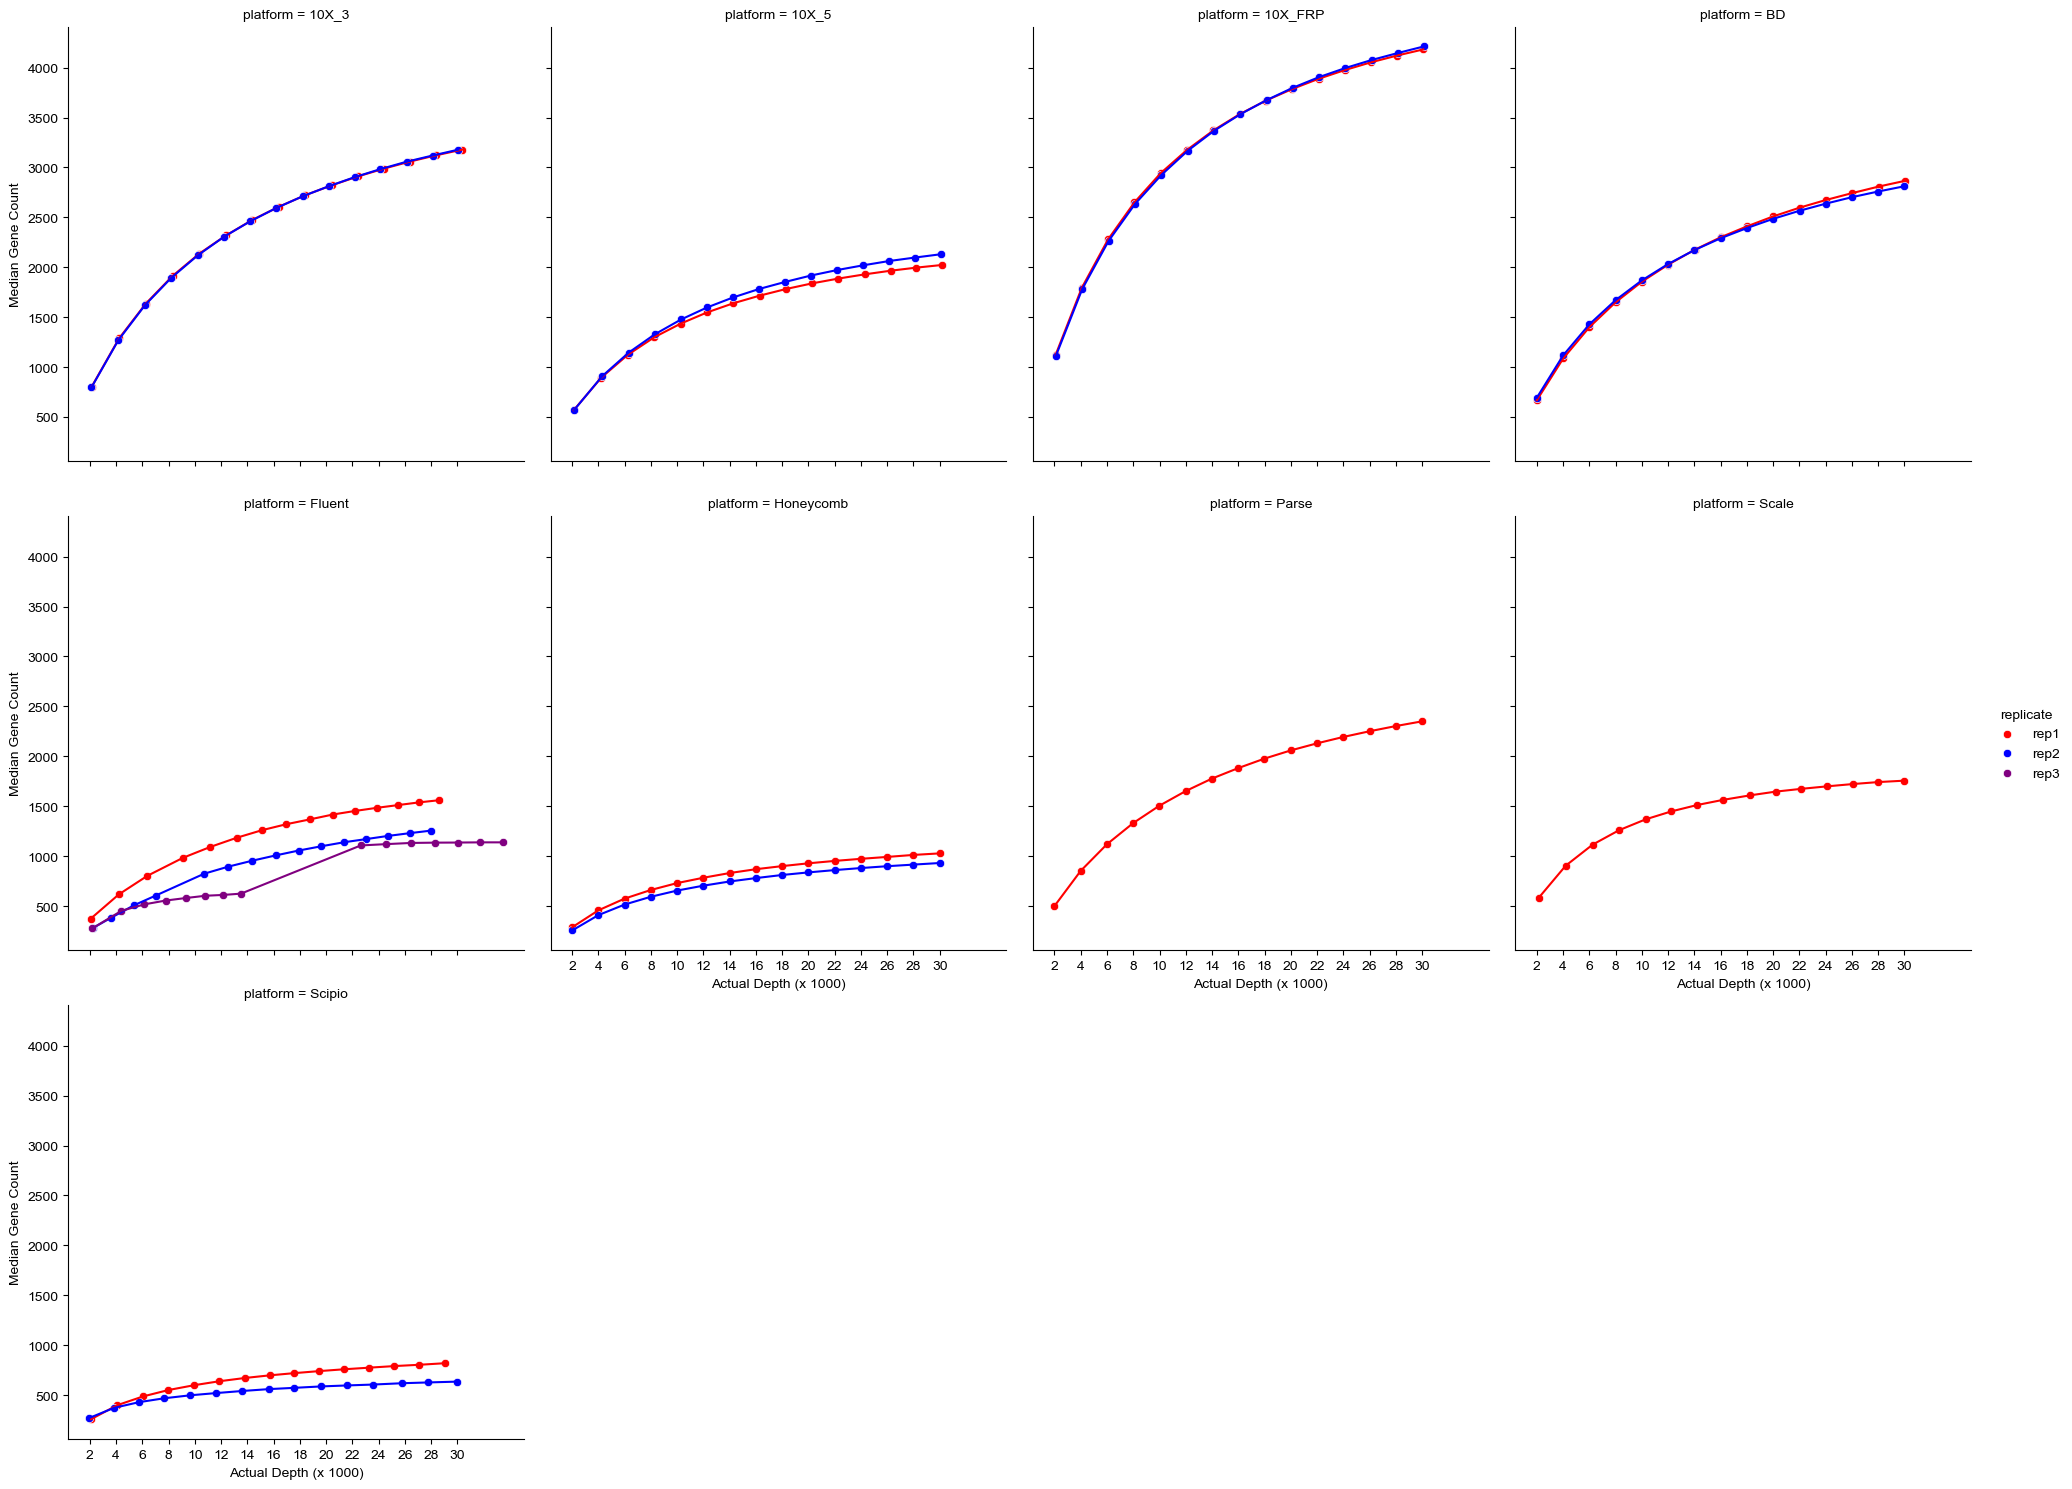

In [19]:
##Actual Depth

##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a line plot to each facet
g.map(sns.lineplot, "actual_depth_tens", "median_gene_counts")

##Map a scatter plot to each facet
g.map(sns.scatterplot, "actual_depth_tens", "median_gene_counts")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Actual Depth (x 1000)", "Median Gene Count")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

Median UMI Count:

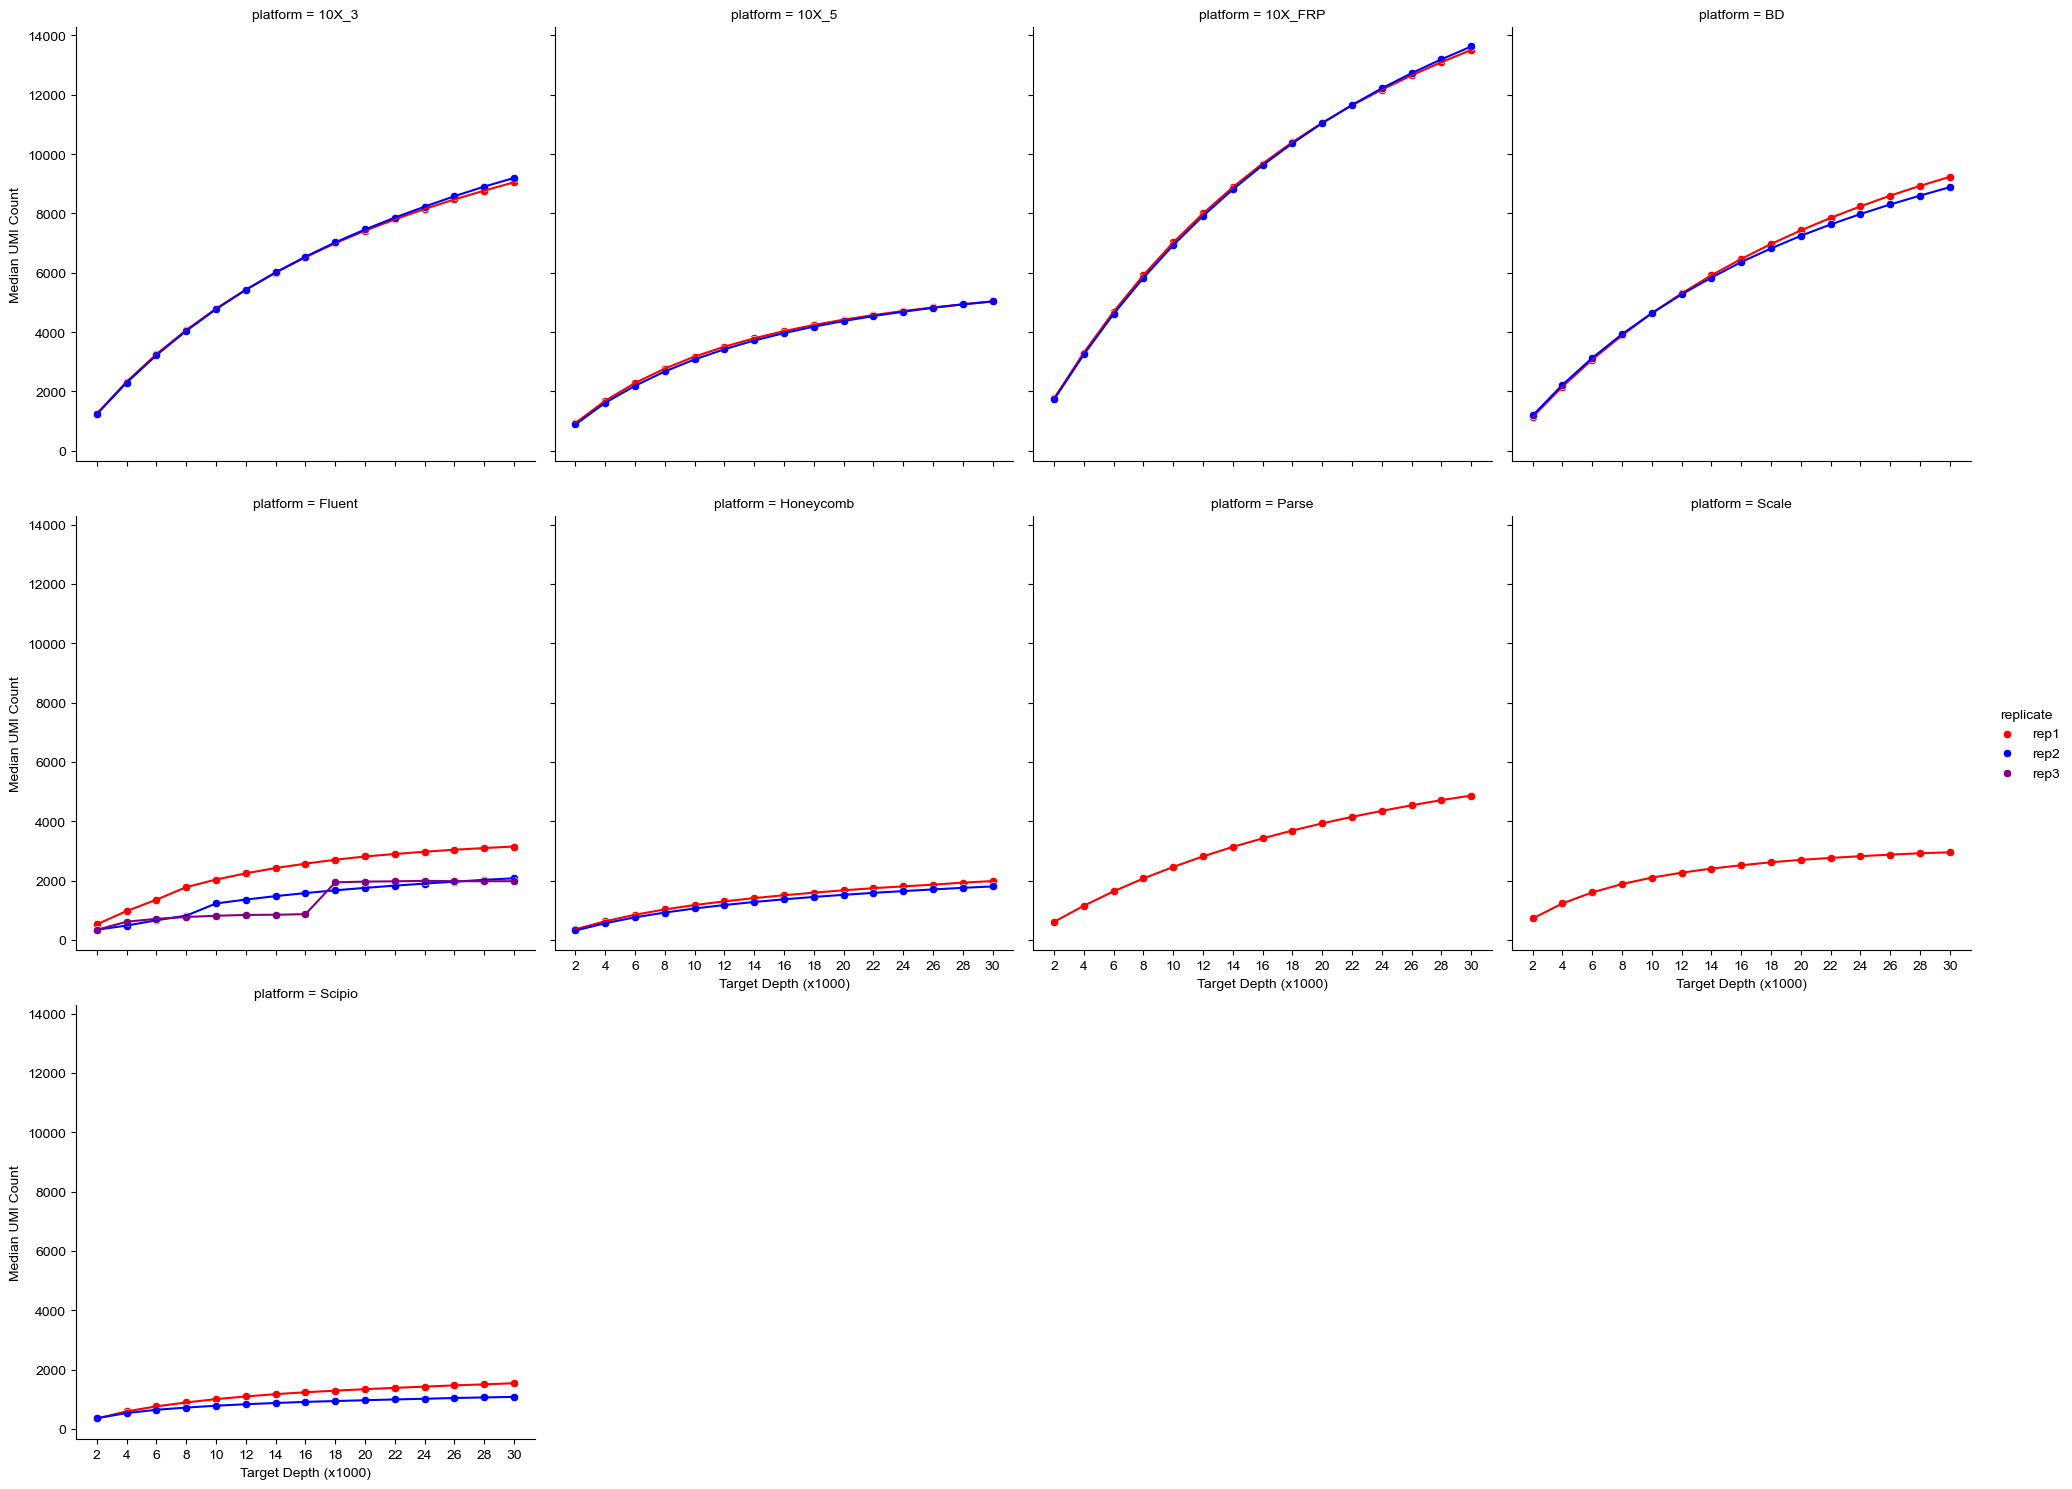

In [20]:
##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a line plot to each facet
g.map(sns.lineplot, "target_depth_tens", "median_umi_counts")

##Map a scatter plot to each facet
g.map(sns.scatterplot, "target_depth_tens", "median_umi_counts")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Target Depth (x1000)", "Median UMI Count")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

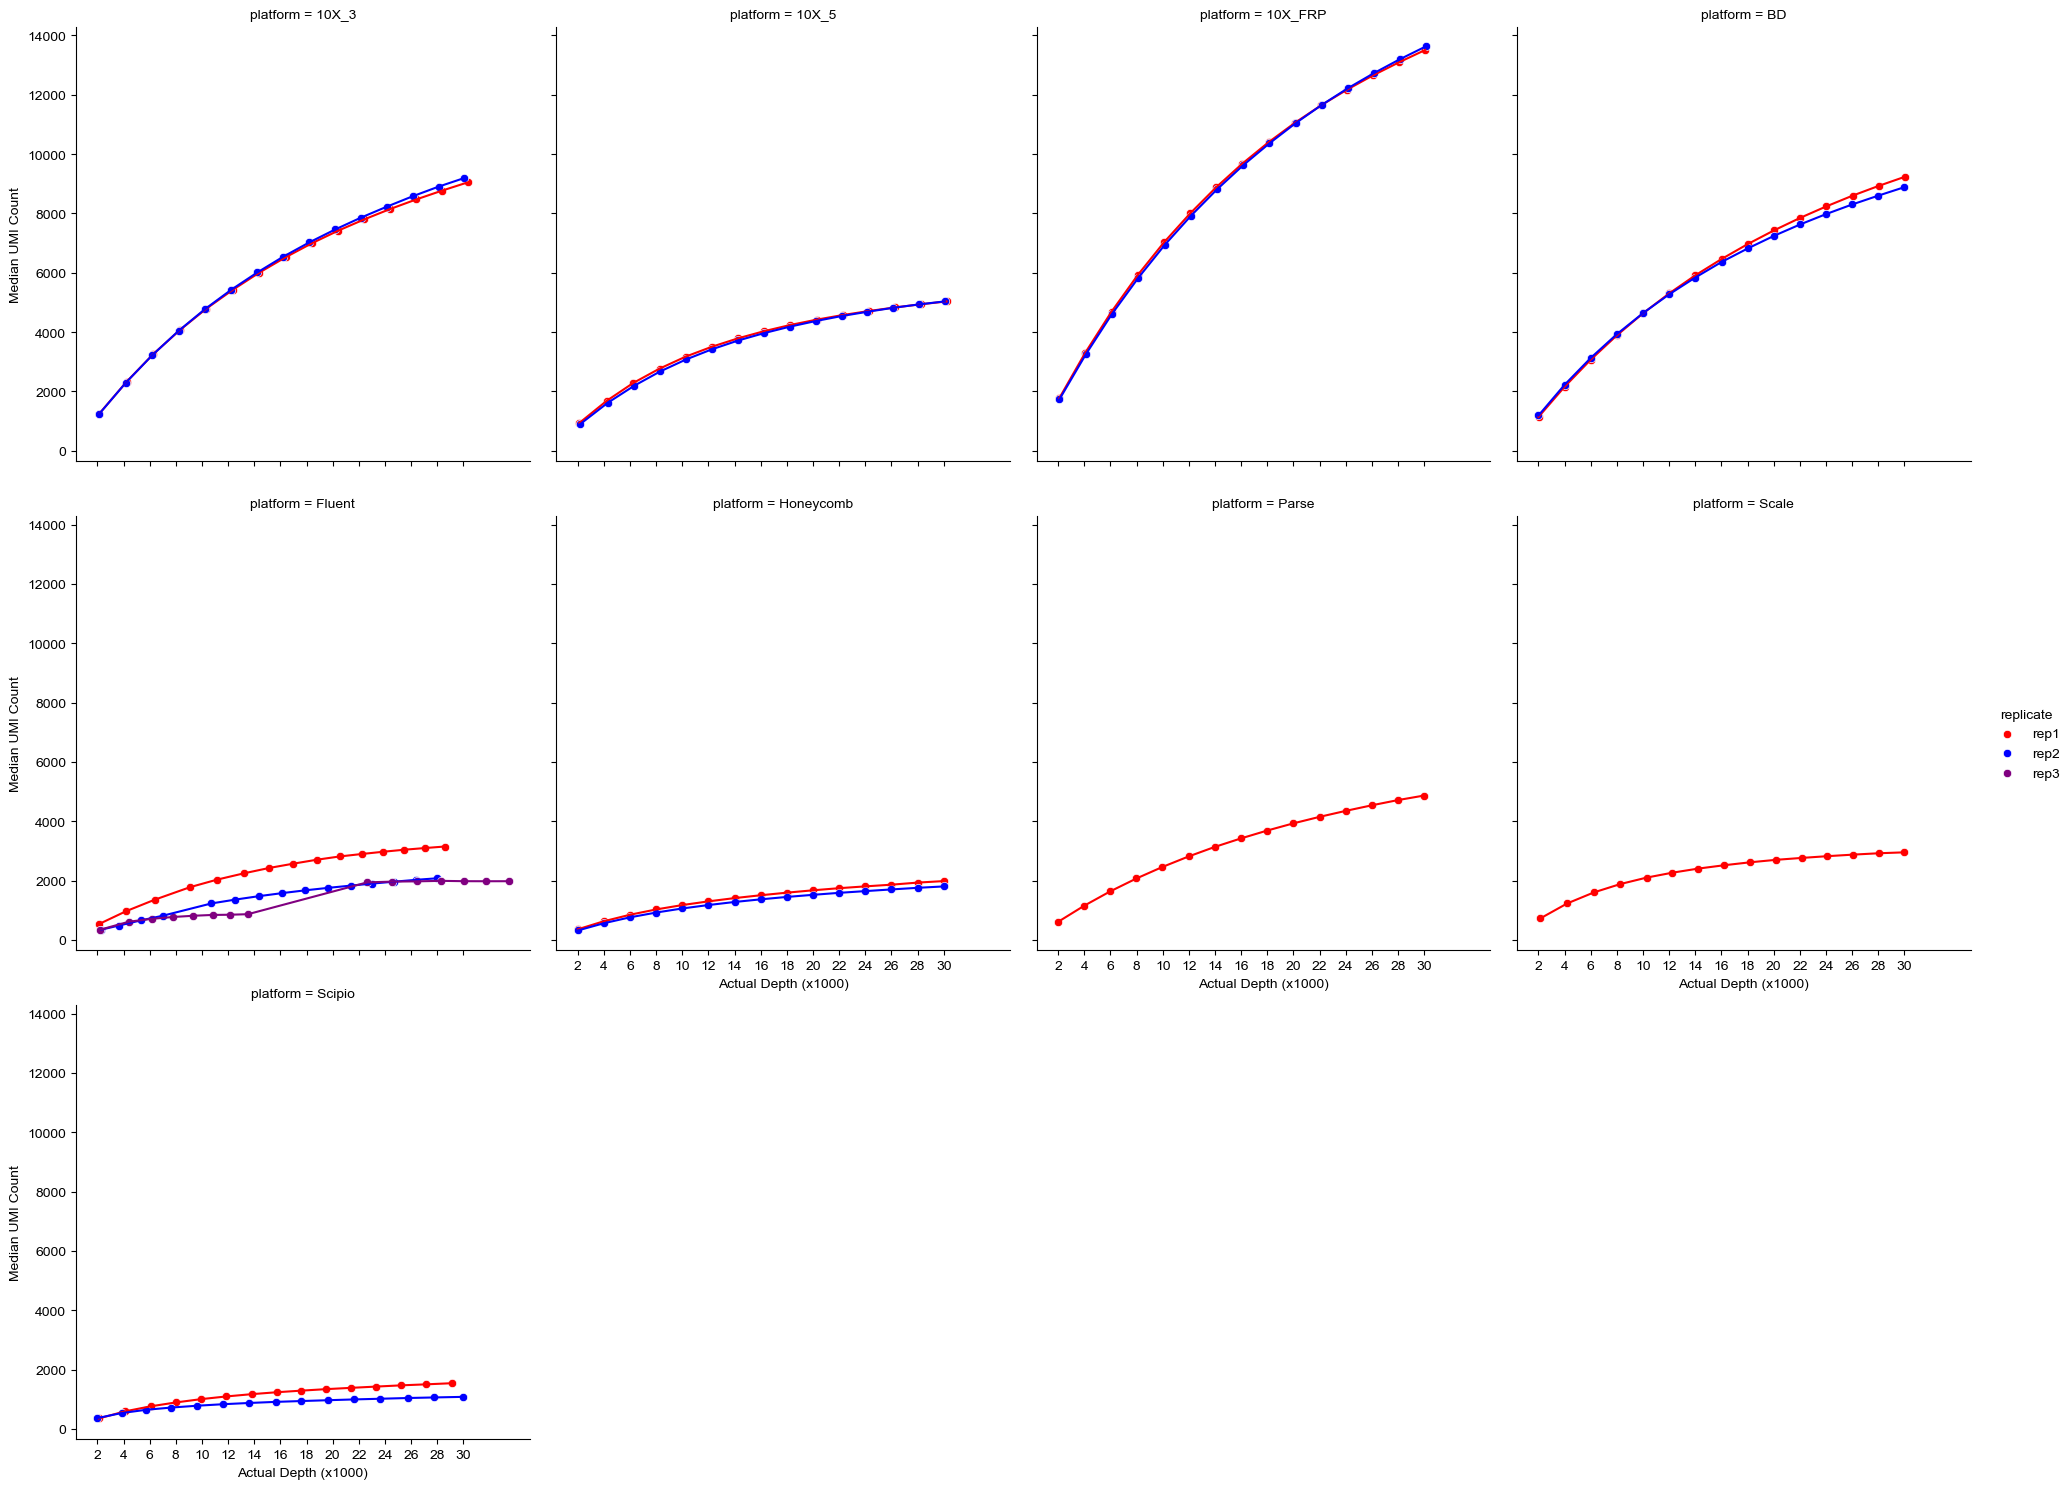

In [21]:
##Actual Depth

##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a line plot to each facet
g.map(sns.lineplot, "actual_depth_tens", "median_umi_counts")

##Map a scatter plot to each facet
g.map(sns.scatterplot, "actual_depth_tens", "median_umi_counts")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Actual Depth (x1000)", "Median UMI Count")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

#### <center> Fitting Curves to Gene and UMI Saturation Curves

We wish to get some quantifiable metrics to compare the saturation curves from the data including the RD50 (the read depth that yields 50% of maximum genes/UMIs) and the maximum value that can be identified given the data. The Hill equation is a canoncical function in receptor-ligand binding kenematics that describes the relationship between ligand concentration and the fraction of ligand that is bound. The typical formula is $\theta = \frac{[L]^n}{(K_A)^n + [L]^n}$ where $\theta$ is the percent of ligand bound, $[L]$ is the ligand concentration, $[K_A]$ is the ligand concentration that causes 50% binding, and $n$ is the hill coefficient. 

We can generalize this to any saturation-like curve such that the output is the maximal output instead of fraction by multiplying the equation by a constant and changing the equation to be $y  = a * \frac{x^n}{c^n + x^n}$ where $y$ is the expected output, $a$ is the maximal output (asymptote), $c$ is the RD50, $n$ is the hill coefficient, and $x$ is the input value. In the context of our experiment, $x$ is the sequencing depth, $y$ is either the expected number of genes of UMIs at the sequencing depth, $a$ is the maximum number of genes or umis that could be detected, and $c$ is depth that yields half max number of genes or UMIs. We can now fit this curve on the data. For the sake of this modeling, we will concatentate replicate values to make one large sample.

For gene modeling we initialize our values to 3000 max genes, 10 (x1000) reads/cell for RD50, and 1 for hill coefficient since these should be close to our expected values based on the raw data. For umi modeling, we initialize our values to 10000 max umis, 10 (x1000) reads/cell for RD50, and 1 for hill coefficient.

Inspiration for the code comes from James Phillips from stack exchange (https://stackoverflow.com/questions/55078451/how-to-use-curvefit-in-python)

Additionially, if the hill coeffiecient ($n$) turns out to be close to 1, the equation simplifies to the Michaelis-Menten equation $v = \frac{V_{max} * [S]}{([S] + K_M})$ where $v$ is the rate of a reaction (for us the expected output), $V_{max}$ is the maximal rate (maximal output for us; asymptote), $[S]$ is the substrate concentration (depth for us), and $K_M$ is the concentration where the reaction is at half the maximal rate (depth that yields half max number of genes of UMIs for us). We will test Michaelis-Menten if the hill coefficients are close to 1. 



In [22]:
##define the hill equation

def hill_func(x, a, n, c): # Hill equation expanded to have a vmax that is not 1
    return  a * np.power(x, n) / (np.power(c, n) + np.power(x, n)) 

##setup dictionary to save results
modeling_dict = {}
plotting_dict = {}

##Loop through each method (replicates combined) to find optimal parameters and fitted values
for method in summary_df['platform'].unique():
    
    print(f"Fitting Curve for {method}")
    
    # Get X and Y for gene counts
    X = summary_df.loc[summary_df['platform'] == method, 'actual_depth_tens']
    Y = summary_df.loc[summary_df['platform'] == method, 'median_gene_counts']


    # Initialize parameters with values around where we expect for a, n, c
    init_vals = np.array([3000, 1.0, 10])

    # supress curve fit warnings
    warnings.filterwarnings("ignore")

    # curve fit the test data
    popt, pcov = curve_fit(hill_func, X, Y, p0=init_vals)
    
    # get sd or parameters
    perr = np.sqrt(np.diag(pcov))
    
    #unpack parameters
    a, n, c = popt
    a_sd, n_sd, c_sd = perr

    # get predictions
    pred_vals = hill_func(X, *popt) 
    
    # get errors
    errors = pred_vals - Y

    SE = np.square(errors) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.sum(SE) / np.sum(np.square(Y - np.mean(Y)))) # 1- RSS/TSS

    print('Parameters:', popt)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    
    # get fitted values for fitted equation plot
    x_smooth = np.linspace(min(X), max(X))
    y_fitted = hill_func(x_smooth, *popt)
    
    # put together results in dataframe to add so modeling dict
    modeling_dict[method] = {'max_val': a,'hill_coefficient': n, 'RD50': c, 
                             'max_val_sd': a_sd, 'hill_sd': n_sd,'RD50_sd': c_sd,
                             'RMSE': RMSE, 'R-squared': Rsquared}
    
    # put together fitted values in df for plotting
    plotting_dict[method] = pd.DataFrame({'actual_depth_tens': x_smooth, 'median_gene_counts': y_fitted})
    
    print(f"Finished modeling {method}")
    print()
    
##combine plotting dict into df
# modeling_df = pd.concat(modeling_dict, axis=0, names = ['method', 'index']).reset_index(drop=False).drop('index', axis = 1)
modeling_df = pd.DataFrame(modeling_dict).T.reset_index(names='platform')
plotting_df = pd.concat(plotting_dict, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)
del plotting_dict, modeling_dict

Fitting Curve for 10X_3
Parameters: [4.53991546e+03 9.05335904e-01 1.18143170e+01]
RMSE: 3.011224689870194
R-squared: 0.99998115390416
Finished modeling 10X_3

Fitting Curve for 10X_5
Parameters: [2.75814576e+03 9.41184588e-01 9.11349209e+00]
RMSE: 35.2778117370059
R-squared: 0.9935314401478634
Finished modeling 10X_5

Fitting Curve for 10X_FRP
Parameters: [5.47616051e+03 9.61978877e-01 8.69636629e+00]
RMSE: 10.24321566961406
R-squared: 0.9998687549174313
Finished modeling 10X_FRP

Fitting Curve for BD
Parameters: [4.17431929e+03 8.84391669e-01 1.27775057e+01]
RMSE: 14.825491877108893
R-squared: 0.9994479714706755
Finished modeling BD

Fitting Curve for Fluent
Parameters: [1.76396253e+03 1.09159800e+00 1.10308921e+01]
RMSE: 173.68834232925553
R-squared: 0.7707852990838766
Finished modeling Fluent

Fitting Curve for Honeycomb
Parameters: [1.28613906e+03 9.10786473e-01 8.45581260e+00]
RMSE: 40.648587614987434
R-squared: 0.9613794320314883
Finished modeling Honeycomb

Fitting Curve for Pa

In [23]:
modeling_df.sort_values('max_val', ascending=False)

platform      max_val  hill_coefficient       RD50  max_val_sd   hill_sd  \
2    10X_FRP  5476.160513          0.961979   8.696366   32.806584  0.007827   
0      10X_3  4539.915465          0.905336  11.814317   14.340076  0.003026   
3         BD  4174.319294          0.884392  12.777506   78.511400  0.016304   
6      Parse  3373.159189          0.952661  12.512593    7.083037  0.002037   
1      10X_5  2758.145762          0.941185   9.113492  123.265139  0.054906   
7      Scale  2048.534231          1.037853   5.248178    5.077715  0.005431   
4     Fluent  1763.962535          1.091598  11.030892  439.928455  0.334803   
5  Honeycomb  1286.139058          0.910786   8.455813  139.131520  0.131794   
8     Scipio   912.888051          0.827308   5.913965  212.027514  0.310152   

    RD50_sd        RMSE  R-squared  
2  0.122157   10.243216   0.999869  
0  0.090034    3.011225   0.999981  
3  0.587505   14.825492   0.999448  
6  0.060318    1.015269   0.999997  
1  0.967948   35.277812   0.993531  
7  0.028860    1.864916   0.999968  
4  5.743415  173.688342   0.770785  
5  2.248888   40.648588   0.961379  
8  3.643301   66.668607   0.788949

In [24]:
colors_platform_2 = {'10X_3':'red', 
                   '10X_5':'brown', 
                   '10X_FRP':'lime',
                   'BD':'cyan', 
                   'Fluent':'navy', 
                   'Honeycomb':'orange', 
                   'Parse':'purple', 
                   'Scale':'pink', 
                   'Scipio':'salmon' 
                  }

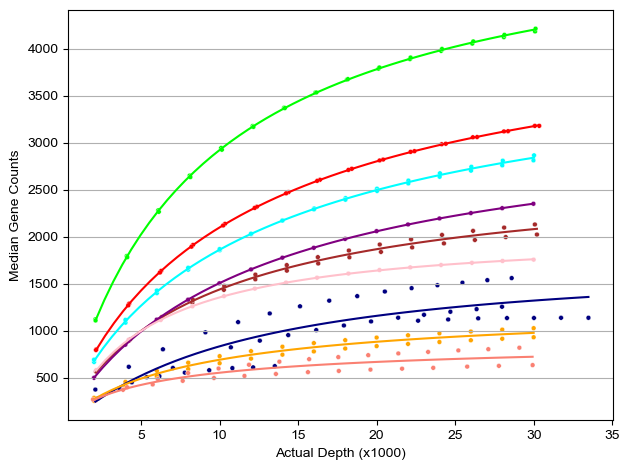

In [25]:
fig, ax = plt.subplots(1,1)

##fitted curve
sns.lineplot(plotting_df, x='actual_depth_tens', y='median_gene_counts', hue='platform', ax = ax, palette=colors_platform_2, legend=False)

##scatter of true points
sns.scatterplot(x='actual_depth_tens', y='median_gene_counts', hue='platform', palette=colors_platform_2, data=summary_df, ax=ax, s=12, legend=False)

##format axes
ax.set(xlabel = 'Actual Depth (x1000)', ylabel='Median Gene Counts')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

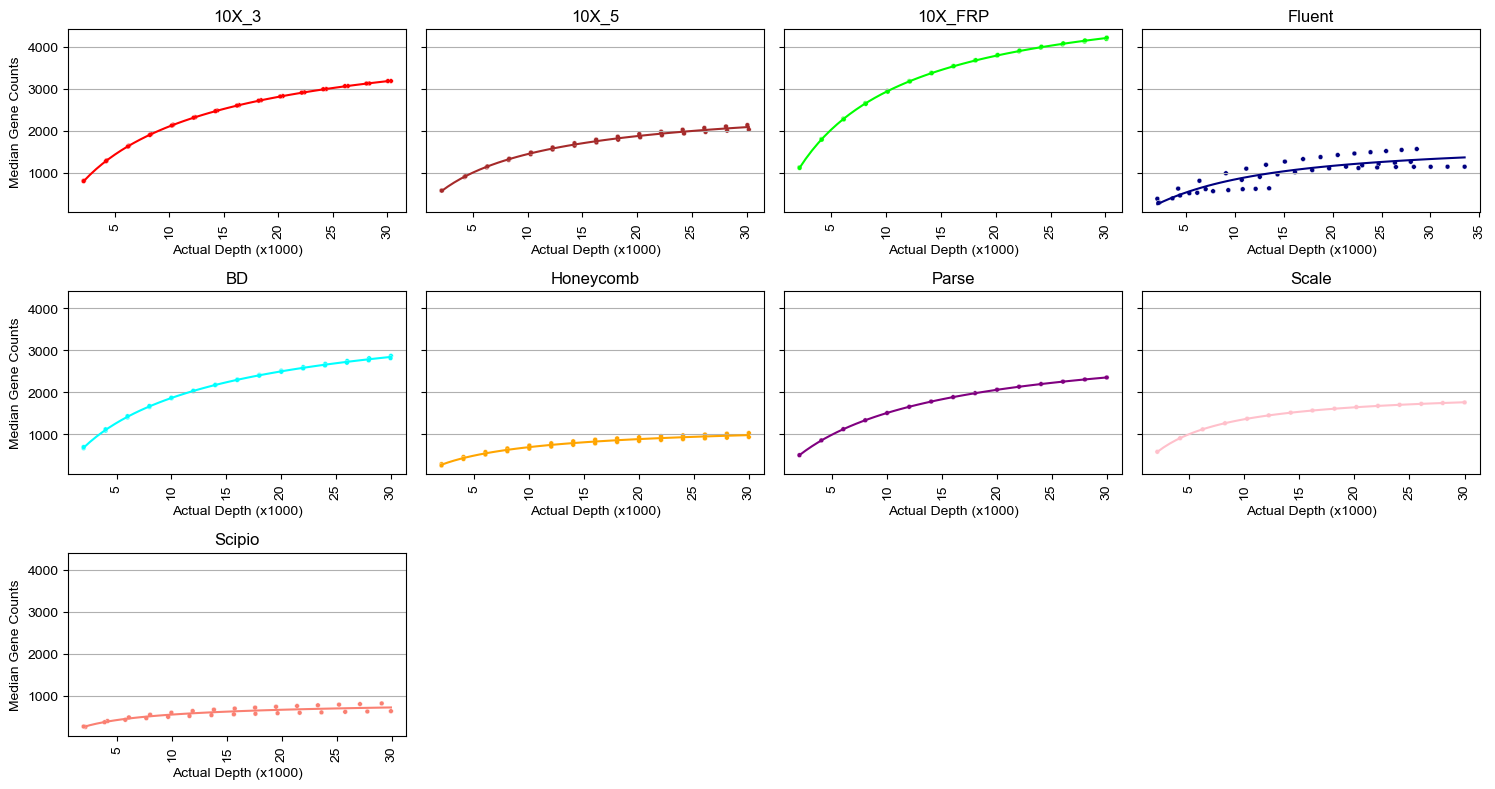

In [26]:
# Create figure and axes
platforms = ['10X_3', '10X_5', '10X_FRP', 'Fluent', 'BD', 'Honeycomb', 'Parse', 'Scale', 'Scipio'] ##plotting order
num_cols = 4
num_rows = math.ceil(len(platforms) / num_cols) # adjust the number here based on how many columns you want
fig, axs = plt.subplots(num_rows, num_cols, sharey = True, figsize=(15,8)) ##paper dim 85mm x 40mm
axs = axs.flatten() # to make it easier to index
# fig, axes = plt.subplots(len(celltypes), figsize=(5, 5*len(celltypes)))

for i, platform in enumerate(platforms):
    
    # Create fitted curve
    sns.lineplot(plotting_df[plotting_df['platform'] == platform], x='actual_depth_tens', y='median_gene_counts', 
                 hue='platform', ax = axs[i], palette=colors_platform_2, legend=False)
    
    ##scatter of true points
    sns.scatterplot(summary_df[summary_df['platform'] == platform], x='actual_depth_tens', y='median_gene_counts', 
                    hue='platform', palette=colors_platform_2, ax=axs[i], s=12, legend=False)
    
    # Set title and rotate x-axis labels
    axs[i].set_title(platform)
    axs[i].set_ylabel("Median Gene Counts")
    axs[i].set_xlabel("Actual Depth (x1000)")
    axs[i].grid(axis='y')
    plt.setp(axs[i].get_xticklabels(), rotation=90)
    
# If the total subplots are not multiple of nrows*ncols, delete the remaining ones (since i keeps value from the for loop)
i+=1
while i < len(axs):
    fig.delaxes(axs[i])
    i += 1
    

plt.tight_layout()
plt.show()

The previous results show that the estimated hill coefficient is approximately 1 for all platforms, which reduces the function to approximately michaelis-menten. For parsimony, we will use the michaelis-menten equation for both gene and UMI estimation

In [27]:
##define the michaelis menten equation

def mm_func(x, a, c): # michaelis menten equation
    return  a * x / (c + x) 

##setup dictionary to save results
modeling_dict_gene = {}
plotting_dict_gene = {}
modeling_dict_umi = {}
plotting_dict_umi = {}
hierarchical_dict_gene = {}
hierarchical_dict_umi = {}

##Loop through each method (replicates combined) to find optimal parameters and fitted values
for method in summary_df['platform'].unique():
    
    print(f"Fitting Curve for {method}")
    
    # Get X and Y for gene counts
    X = summary_df.loc[summary_df['platform'] == method, 'actual_depth_tens']
    Y = summary_df.loc[summary_df['platform'] == method, 'median_gene_counts']
    Y_umi = summary_df.loc[summary_df['platform'] == method, 'median_umi_counts']


    # Initialize parameters with values around where we expect for a, c
    init_vals_gene = np.array([3000, 10]) ##3000 max genes, 10 (x1000) RD50
    init_vals_umi = np.array([10000, 10]) ##10000 max umis, 10 (x1000) RD50

    # supress curve fit warnings
    warnings.filterwarnings("ignore")

    # curve fit the test data
    popt_g, pcov_g = curve_fit(mm_func, X, Y, p0=init_vals_gene)
    popt_u, pcov_u = curve_fit(mm_func, X, Y_umi, p0=init_vals_umi)
    
    # get sd or parameters
    perr_g = np.sqrt(np.diag(pcov_g))
    perr_u = np.sqrt(np.diag(pcov_u))
    
    #unpack parameters
    a_g, c_g = popt_g
    a_sd_g, c_sd_g = perr_g
    a_u, c_u = popt_u
    a_sd_u, c_sd_u = perr_u

    # get predictions
    pred_vals_g = mm_func(X, *popt_g) 
    pred_vals_u = mm_func(X, *popt_u)
    
    # get errors
    errors_g = pred_vals_g - Y
    errors_u = pred_vals_u - Y_umi

    SE_g = np.square(errors_g) # squared errors
    MSE_g = np.mean(SE_g) # mean squared errors
    RMSE_g = np.sqrt(MSE_g) # Root Mean Squared Error, RMSE
    Rsquared_g = 1.0 - (np.sum(SE_g) / np.sum(np.square(Y - np.mean(Y)))) # 1- RSS/TSS
    
    SE_u = np.square(errors_u) # squared errors
    MSE_u = np.mean(SE_u) # mean squared errors
    RMSE_u = np.sqrt(MSE_u) # Root Mean Squared Error, RMSE
    Rsquared_u = 1.0 - (np.sum(SE_u) / np.sum(np.square(Y_umi - np.mean(Y_umi)))) # 1- RSS/TSS

    # get fitted values for fitted equation plot
    x_smooth = np.linspace(min(X), max(X))
    y_fitted_g = mm_func(x_smooth, *popt_g)
    y_fitted_u = mm_func(x_smooth, *popt_u)
    
    # get fitted values for full range of data for hierarchical clustering
    x_smooth_hier = np.linspace(0, 34)
    y_fitted_g_hier = mm_func(x_smooth_hier, *popt_g)
    y_fitted_u_hier = mm_func(x_smooth_hier, *popt_u)
    
    # put together results in dataframe to add so modeling dict
    modeling_dict_gene[method] = {'max_val': a_g,'RD50': c_g, 
                             'max_val_sd': a_sd_g,'RD50_sd': c_sd_g,
                             'RMSE': RMSE_g, 'R-squared': Rsquared_g}
    
    modeling_dict_umi[method] = {'max_val': a_u,'RD50': c_u, 
                             'max_val_sd': a_sd_u,'RD50_sd': c_sd_u,
                             'RMSE': RMSE_u, 'R-squared': Rsquared_u}
    
    # put together fitted values in df for plotting
    plotting_dict_gene[method] = pd.DataFrame({'actual_depth_tens': x_smooth, 'median_gene_counts': y_fitted_g})
    plotting_dict_umi[method] = pd.DataFrame({'actual_depth_tens': x_smooth, 'median_umi_counts': y_fitted_u})
    
    # put together fitted values in df for hierarchical clustering
    hierarchical_dict_gene[method] = pd.DataFrame({'actual_depth_tens': x_smooth_hier, 'median_gene_counts': y_fitted_g_hier})
    hierarchical_dict_umi[method] = pd.DataFrame({'actual_depth_tens': x_smooth_hier, 'median_umi_counts': y_fitted_u_hier})
    
    print(f"Finished modeling {method}")
    print()
    
##combine plotting dict into df
# modeling_df = pd.concat(modeling_dict, axis=0, names = ['method', 'index']).reset_index(drop=False).drop('index', axis = 1)
modeling_df_gene_mm = pd.DataFrame(modeling_dict_gene).T.reset_index(names='platform')
plotting_df_gene_mm = pd.concat(plotting_dict_gene, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)
hier_df_gene_mm =  pd.concat(hierarchical_dict_gene, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)

modeling_df_umi_mm = pd.DataFrame(modeling_dict_umi).T.reset_index(names='platform')
plotting_df_umi_mm = pd.concat(plotting_dict_umi, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)
hier_df_umi_mm =  pd.concat(hierarchical_dict_umi, axis=0, names = ['platform', 'index']).reset_index(drop=False).drop('index', axis = 1)

del plotting_dict_gene, modeling_dict_gene, hierarchical_dict_gene, plotting_dict_umi, modeling_dict_umi, hierarchical_dict_umi

Fitting Curve for 10X_3
Finished modeling 10X_3

Fitting Curve for 10X_5
Finished modeling 10X_5

Fitting Curve for 10X_FRP
Finished modeling 10X_FRP

Fitting Curve for BD
Finished modeling BD

Fitting Curve for Fluent
Finished modeling Fluent

Fitting Curve for Honeycomb
Finished modeling Honeycomb

Fitting Curve for Parse
Finished modeling Parse

Fitting Curve for Scale
Finished modeling Scale

Fitting Curve for Scipio
Finished modeling Scipio



In [28]:
modeling_df_gene_mm.sort_values('max_val', ascending=False)

platform      max_val       RD50  max_val_sd   RD50_sd        RMSE  \
2    10X_FRP  5335.143950   8.206504   12.936810  0.059015   14.010106   
0      10X_3  4184.432458   9.800239   19.565540  0.124784   18.232325   
3         BD  3753.774720   9.989917   27.349354  0.195156   24.909862   
6      Parse  3230.778785  11.364301   12.458587  0.110323    6.855524   
1      10X_5  2645.528562   8.300568   33.620361  0.311918   36.016114   
7      Scale  2083.462058   5.424652    4.198794  0.040326    4.208100   
4     Fluent  1890.570885  12.752275  184.722549  3.013610  173.871035   
5  Honeycomb  1209.738957   7.354778   34.762368  0.660915   40.986055   
8     Scipio   828.639607   4.754690   42.232282  0.941641   67.045969   

   R-squared  
2   0.999754  
0   0.999309  
3   0.998442  
6   0.999841  
1   0.993258  
7   0.999839  
4   0.770303  
5   0.960736  
8   0.786553

In [29]:
modeling_df_gene_mm.sort_values('RD50', ascending=True)

platform      max_val       RD50  max_val_sd   RD50_sd        RMSE  \
8     Scipio   828.639607   4.754690   42.232282  0.941641   67.045969   
7      Scale  2083.462058   5.424652    4.198794  0.040326    4.208100   
5  Honeycomb  1209.738957   7.354778   34.762368  0.660915   40.986055   
2    10X_FRP  5335.143950   8.206504   12.936810  0.059015   14.010106   
1      10X_5  2645.528562   8.300568   33.620361  0.311918   36.016114   
0      10X_3  4184.432458   9.800239   19.565540  0.124784   18.232325   
3         BD  3753.774720   9.989917   27.349354  0.195156   24.909862   
6      Parse  3230.778785  11.364301   12.458587  0.110323    6.855524   
4     Fluent  1890.570885  12.752275  184.722549  3.013610  173.871035   

   R-squared  
8   0.786553  
7   0.999839  
5   0.960736  
2   0.999754  
1   0.993258  
0   0.999309  
3   0.998442  
6   0.999841  
4   0.770303

In [30]:
modeling_df_umi_mm.sort_values('max_val', ascending=False)

platform       max_val       RD50  max_val_sd   RD50_sd        RMSE  \
2    10X_FRP  26410.243620  28.187424  205.776458  0.375894   59.805488   
3         BD  17384.199835  27.471798  309.658888  0.844251   92.593572   
0      10X_3  17237.263265  26.790294  157.556592  0.427901   49.134459   
6      Parse   9577.097879  28.865373   41.429248  0.211519    7.903096   
1      10X_5   7534.629559  14.593920   69.507560  0.302715   43.924315   
4     Fluent   4106.387880  20.451799  834.372133  8.160571  472.115734   
7      Scale   3841.408501   8.667762   24.577902  0.160120   17.230748   
5  Honeycomb   2840.242230  15.431819  114.719424  1.361407   67.971100   
8     Scipio   1631.085900   7.836993  145.138719  2.086397  160.123592   

   R-squared  
2   0.999724  
3   0.998510  
0   0.999575  
6   0.999963  
1   0.998716  
4   0.655331  
7   0.999290  
5   0.978466  
8   0.742402

In [31]:
modeling_df_umi_mm.sort_values('RD50', ascending=True)

platform       max_val       RD50  max_val_sd   RD50_sd        RMSE  \
8     Scipio   1631.085900   7.836993  145.138719  2.086397  160.123592   
7      Scale   3841.408501   8.667762   24.577902  0.160120   17.230748   
1      10X_5   7534.629559  14.593920   69.507560  0.302715   43.924315   
5  Honeycomb   2840.242230  15.431819  114.719424  1.361407   67.971100   
4     Fluent   4106.387880  20.451799  834.372133  8.160571  472.115734   
0      10X_3  17237.263265  26.790294  157.556592  0.427901   49.134459   
3         BD  17384.199835  27.471798  309.658888  0.844251   92.593572   
2    10X_FRP  26410.243620  28.187424  205.776458  0.375894   59.805488   
6      Parse   9577.097879  28.865373   41.429248  0.211519    7.903096   

   R-squared  
8   0.742402  
7   0.999290  
1   0.998716  
5   0.978466  
4   0.655331  
0   0.999575  
3   0.998510  
2   0.999724  
6   0.999963

save supplemental tables

In [32]:
gene_mm_file = os.path.join(supplement_table_dir, 'Table3a_Gene_MM_Model_Fit.csv')
umi_mm_file = os.path.join(supplement_table_dir, 'Table3b_UMI_MM_Model_Fit.csv')
modeling_df_gene_mm.sort_values('max_val', ascending=False).to_csv(gene_mm_file, index=False)
modeling_df_umi_mm.sort_values('max_val', ascending=False).to_csv(umi_mm_file, index=False)

Plot for slides

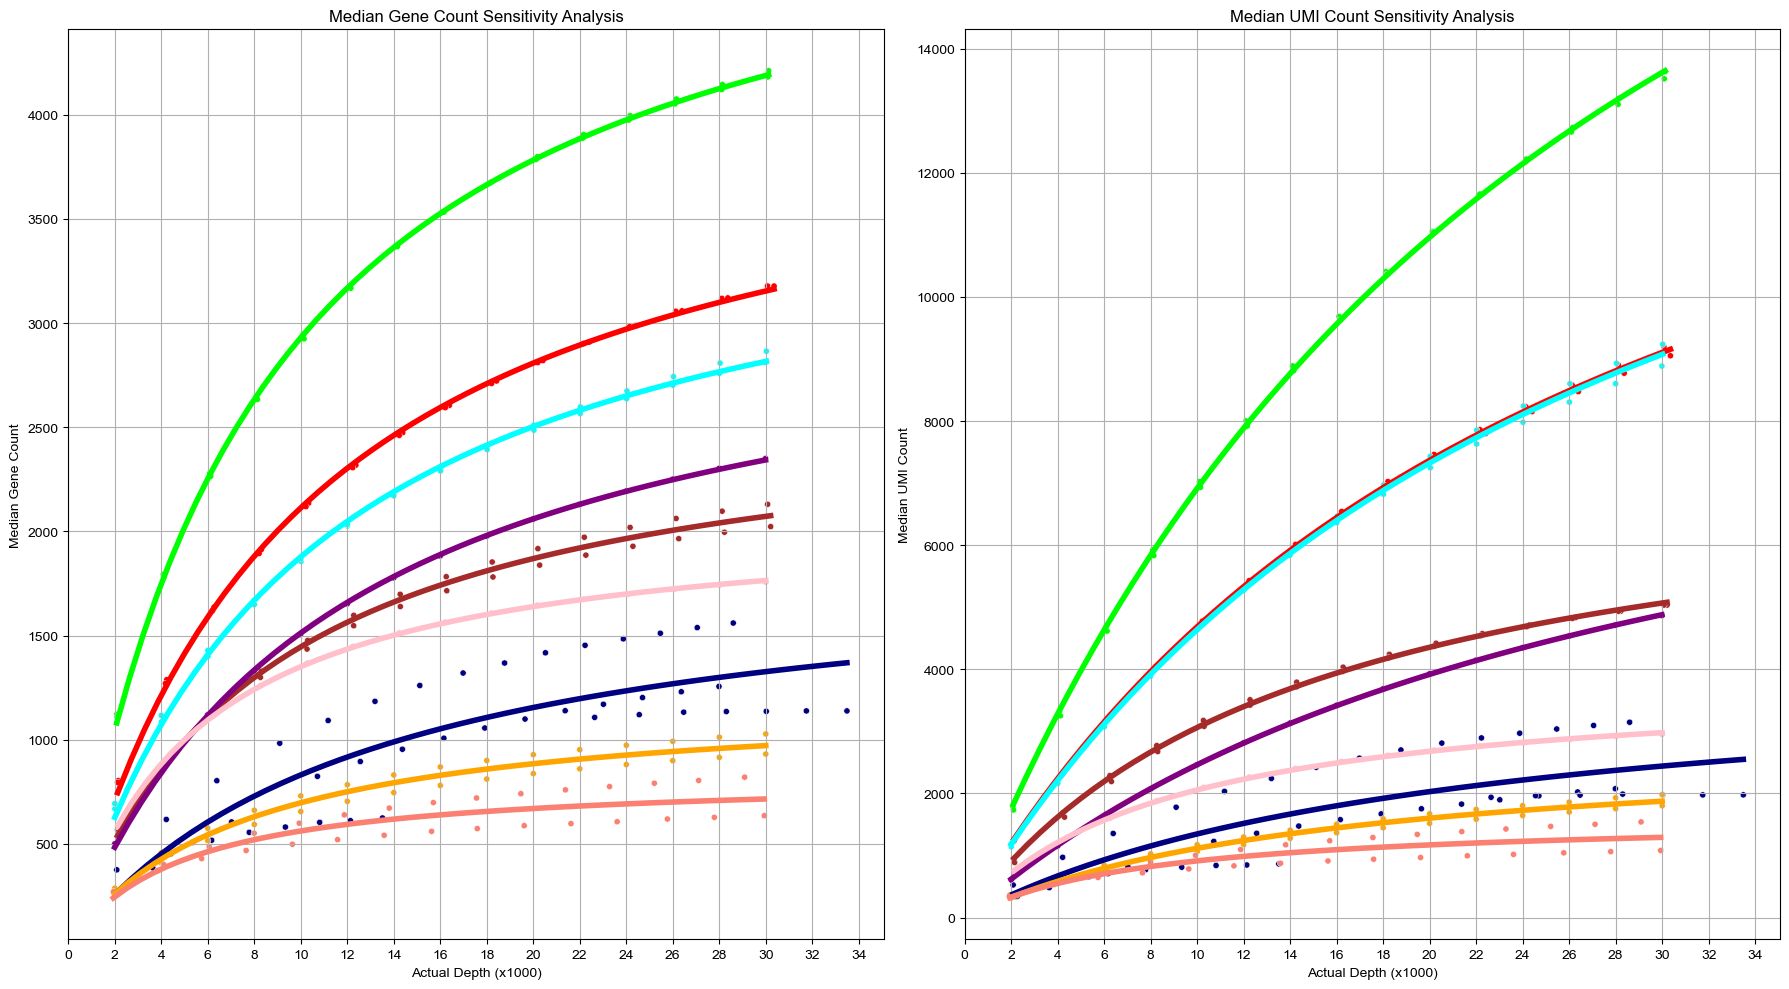

In [33]:
##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 2, figsize=(18, 10)) ##match paper dimension of 72MM x 40MM

##Create titles for each metric
y_labs = ['Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['median_gene_counts', 'median_umi_counts']), y_labs):

    ##fitted curve
    if y_val == 'median_gene_counts':
        temp_df = plotting_df_gene_mm
    else:
        temp_df = plotting_df_umi_mm
    sns.lineplot(temp_df, x='actual_depth_tens', y=y_val, hue='platform', ax = axes[i], palette=colors_platform_2, legend=False, linewidth=4)

    ##scatter of true points
    sns.scatterplot(summary_df, x='actual_depth_tens', y=y_val, hue='platform', palette=colors_platform_2, s=20, ax=axes[i], legend=False)

    ##format axes
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel=y_lab)
    axes[i].grid(True)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")
    axes[i].xaxis.set_ticks(np.arange(0, np.max(summary_df['actual_depth_tens']) + 2, 2))

    
    del temp_df

plt.tight_layout()
plt.show()


plotting gene and umi per platform

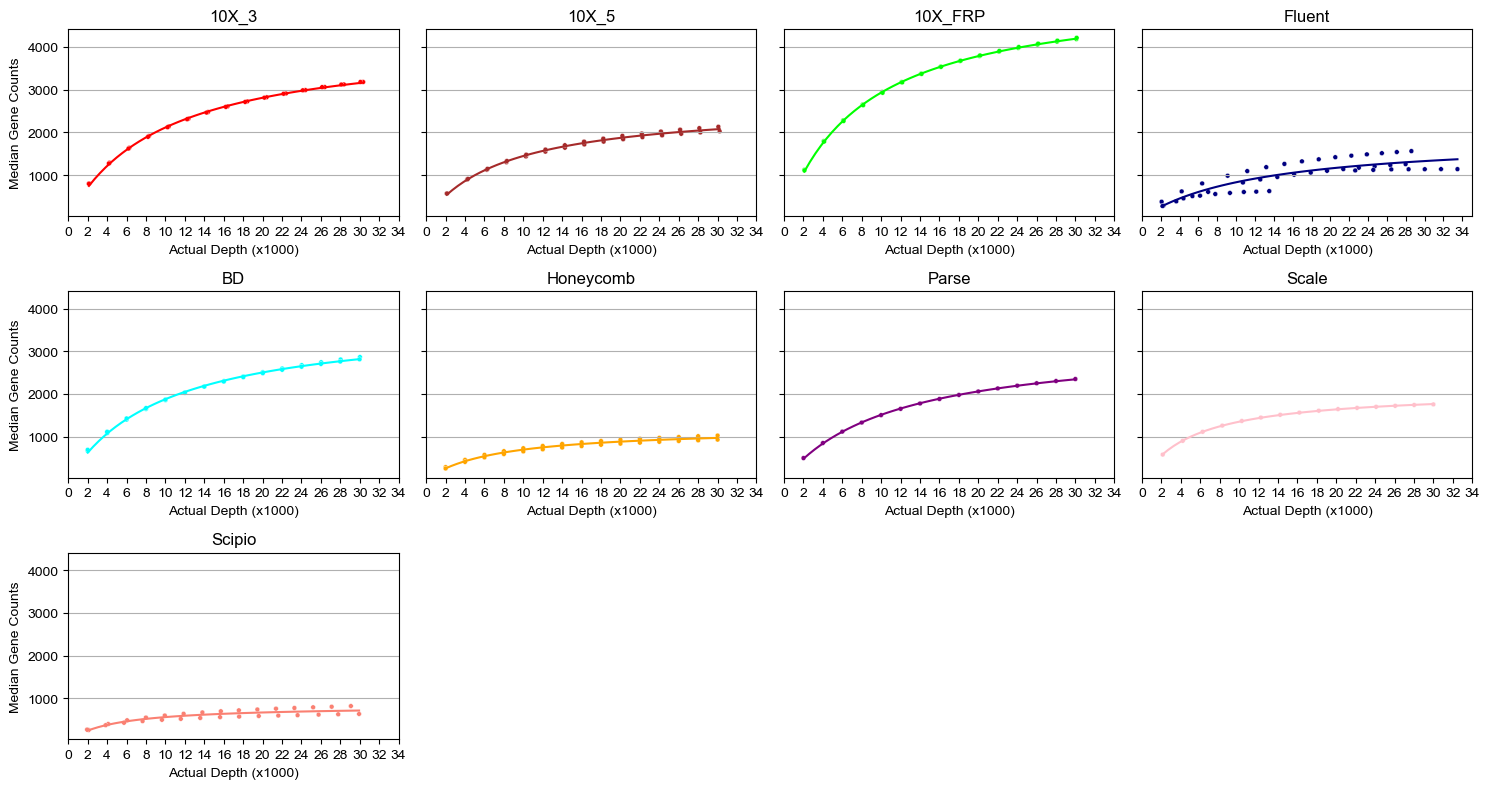

In [35]:
# Create figure and axes
platforms = ['10X_3', '10X_5', '10X_FRP', 'Fluent', 'BD', 'Honeycomb', 'Parse', 'Scale', 'Scipio'] ##plotting order
num_cols = 4
num_rows = math.ceil(len(platforms) / num_cols) # adjust the number here based on how many columns you want
fig, axs = plt.subplots(num_rows, num_cols, sharey = True, figsize=(15,8)) ##paper dim 85mm x 40mm
axs = axs.flatten() # to make it easier to index
# fig, axes = plt.subplots(len(celltypes), figsize=(5, 5*len(celltypes)))

for i, platform in enumerate(platforms):
    
    # Create fitted curve
    sns.lineplot(plotting_df_gene_mm[plotting_df_gene_mm['platform'] == platform], x='actual_depth_tens', y='median_gene_counts', 
                 hue='platform', ax = axs[i], palette=colors_platform_2, legend=False)
    
    ##scatter of true points
    sns.scatterplot(summary_df[summary_df['platform'] == platform], x='actual_depth_tens', y='median_gene_counts', 
                    hue='platform', palette=colors_platform_2, ax=axs[i], legend=False, s=12)
    
    # Set title and rotate x-axis labels
    axs[i].set_title(platform)
    axs[i].set_ylabel("Median Gene Counts")
    axs[i].set_xlabel("Actual Depth (x1000)")
    axs[i].grid(axis='y')
    axs[i].xaxis.set_ticks(np.arange(0, np.max(summary_df['actual_depth_tens']) + 2, 2))
    
# If the total subplots are not multiple of nrows*ncols, delete the remaining ones (since i keeps value from the for loop)
i+=1
while i < len(axs):
    fig.delaxes(axs[i])
    i += 1
    

plt.tight_layout()
plt.show()

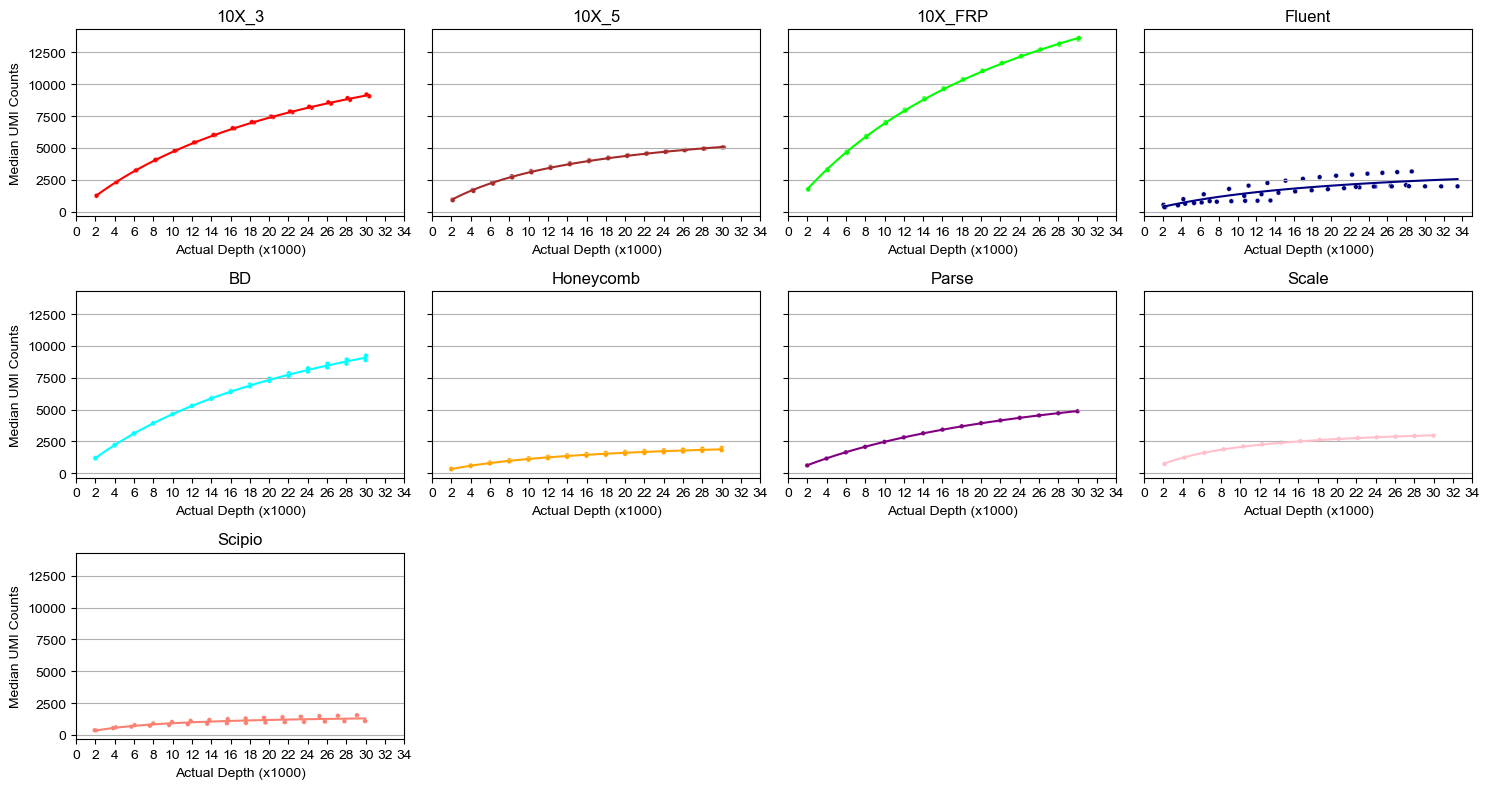

In [36]:
# Create figure and axes
platforms = ['10X_3', '10X_5', '10X_FRP', 'Fluent', 'BD', 'Honeycomb', 'Parse', 'Scale', 'Scipio'] ##plotting order
num_cols = 4
num_rows = math.ceil(len(platforms) / num_cols) # adjust the number here based on how many columns you want
fig, axs = plt.subplots(num_rows, num_cols, sharey = True, figsize=(15,8)) ##paper dim 85mm x 40mm
axs = axs.flatten() # to make it easier to index
# fig, axes = plt.subplots(len(celltypes), figsize=(5, 5*len(celltypes)))

for i, platform in enumerate(platforms):
    
    # Create fitted curve
    sns.lineplot(plotting_df_umi_mm[plotting_df_umi_mm['platform'] == platform], x='actual_depth_tens', y='median_umi_counts', 
                 hue='platform', ax = axs[i], palette=colors_platform_2, legend=False)
    
    ##scatter of true points
    sns.scatterplot(summary_df[summary_df['platform'] == platform], x='actual_depth_tens', y='median_umi_counts', 
                    hue='platform', palette=colors_platform_2, ax=axs[i], legend=False, s=12)
    
    # Set title and rotate x-axis labels
    axs[i].set_title(platform)
    axs[i].set_ylabel("Median UMI Counts")
    axs[i].set_xlabel("Actual Depth (x1000)")
    axs[i].grid(axis='y')
    axs[i].xaxis.set_ticks(np.arange(0, np.max(summary_df['actual_depth_tens']) + 2, 2))
    
# If the total subplots are not multiple of nrows*ncols, delete the remaining ones (since i keeps value from the for loop)
i+=1
while i < len(axs):
    fig.delaxes(axs[i])
    i += 1
    

plt.tight_layout()
plt.show()

Let's see if we can group the curve data using hierarchical clustering to identify "tiers" in the performance

genes using full curve

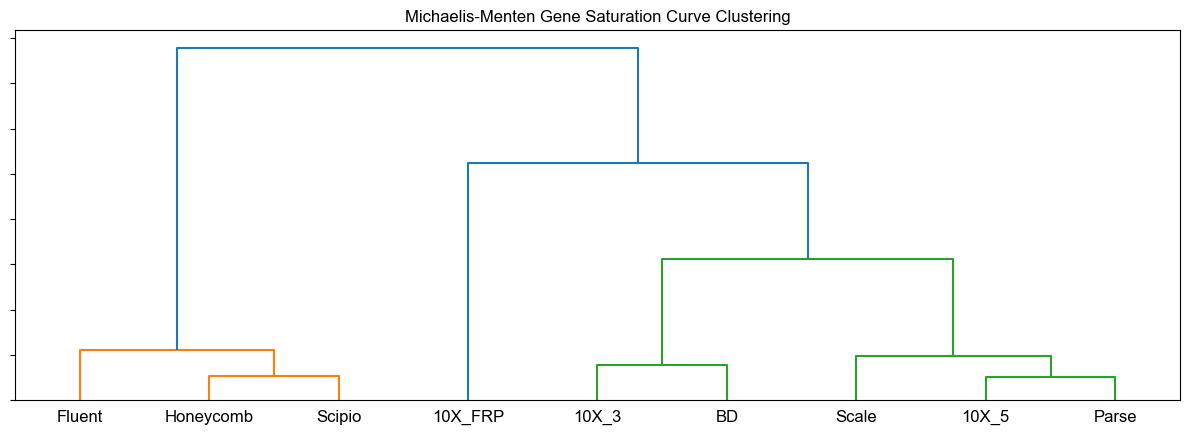

In [37]:
import matplotlib.gridspec as gridspec

# Create a pivot table for plotting
pivot_df = hier_df_gene_mm.copy()
pivot_df['depth_smooth'] = pivot_df.groupby('platform').cumcount() + 1
pivot_df = pivot_df.pivot_table(index='platform', columns='depth_smooth', values='median_gene_counts', fill_value=0)
pivot_df


##Calculate the linkage on the scaled data: hierarchy clusters. Using ward because it is robust and gives sensible results here
linkage = sch.linkage(pivot_df, method='ward')
order = sch.leaves_list(linkage)

##Create a gridspec instance with 2 rows and single column so we can get both plots on top of each other
gs = gridspec.GridSpec(2,1, height_ratios=[1,2]) ##This ratio makes the dendrogram a bit smaller

##Set figure size
fig = plt.figure(figsize=(12,12))

##First (small) plot for the dendrogram
ax1 = plt.subplot(gs[0, 0])
dendrogram = sch.dendrogram(linkage,labels=pivot_df.index, ax=ax1, orientation='top', color_threshold=11000) ##manually selected color threshold
ax1.set_title('Michaelis-Menten Gene Saturation Curve Clustering')
ax1.set_yticklabels([])
ax1.grid(False) #turn off dendrogram grid

plt.tight_layout()

plt.show()

genes using model summary parameters

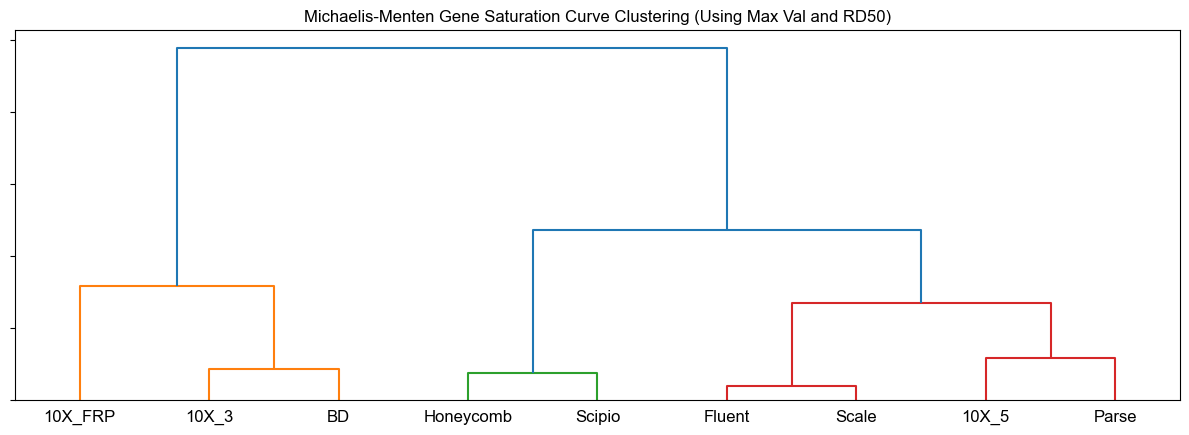

In [38]:
# Create a pivot table for plotting
pivot_df = modeling_df_gene_mm.set_index('platform').loc[:,['max_val', 'RD50']]
pivot_df


##Calculate the linkage on the scaled data: hierarchy clusters. Using ward because it is robust and gives sensible results here
linkage = sch.linkage(pivot_df, method='ward')
order = sch.leaves_list(linkage)

##Create a gridspec instance with 2 rows and single column so we can get both plots on top of each other
gs = gridspec.GridSpec(2,1, height_ratios=[1,2]) ##This ratio makes the dendrogram a bit smaller

##Set figure size
fig = plt.figure(figsize=(12,12))

##First (small) plot for the dendrogram
ax1 = plt.subplot(gs[0, 0])
dendrogram = sch.dendrogram(linkage,labels=pivot_df.index, ax=ax1, orientation='top', color_threshold=2000) ##manually selected color threshold
ax1.set_title('Michaelis-Menten Gene Saturation Curve Clustering (Using Max Val and RD50)')
ax1.set_yticklabels([])
ax1.grid(False) #turn off dendrogram grid

plt.tight_layout()
plt.show()

UMIs using full curve

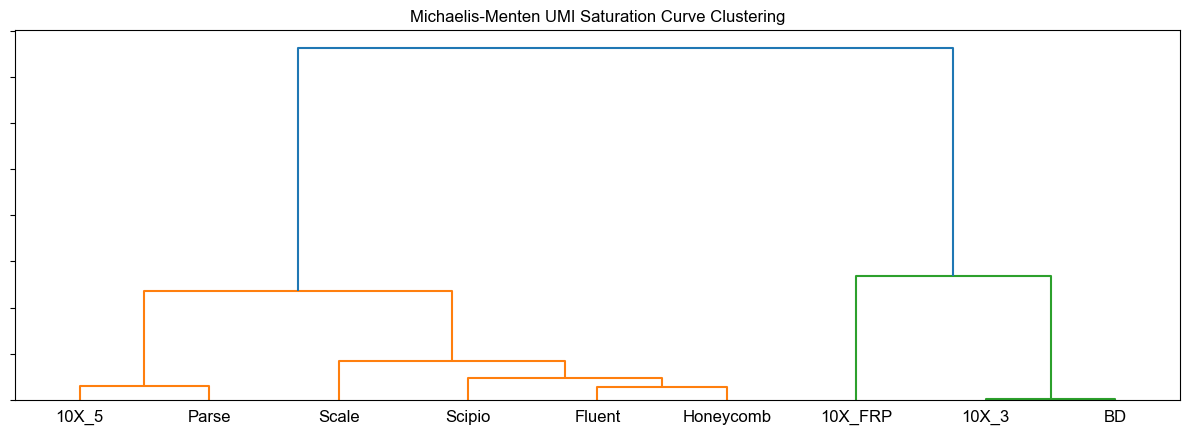

In [39]:
import matplotlib.gridspec as gridspec

# Create a pivot table for plotting
pivot_df = hier_df_umi_mm.copy()
pivot_df['depth_smooth'] = pivot_df.groupby('platform').cumcount() + 1
pivot_df = pivot_df.pivot_table(index='platform', columns='depth_smooth', values='median_umi_counts', fill_value=0)
pivot_df


##Calculate the linkage on the scaled data: hierarchy clusters. Using ward because it is robust and gives sensible results here
linkage = sch.linkage(pivot_df, method='ward')
order = sch.leaves_list(linkage)

##Create a gridspec instance with 2 rows and single column so we can get both plots on top of each other
gs = gridspec.GridSpec(2,1, height_ratios=[1,2]) ##This ratio makes the dendrogram a bit smaller

##Set figure size
fig = plt.figure(figsize=(12,12))

##First (small) plot for the dendrogram
ax1 = plt.subplot(gs[0, 0])
dendrogram = sch.dendrogram(linkage,labels=pivot_df.index, ax=ax1, orientation='top', color_threshold=30000) ##manually selected color threshold
ax1.set_title('Michaelis-Menten UMI Saturation Curve Clustering')
ax1.set_yticklabels([])
ax1.grid(False) #turn off dendrogram grid

plt.tight_layout()

plt.show()

umis using model parameters

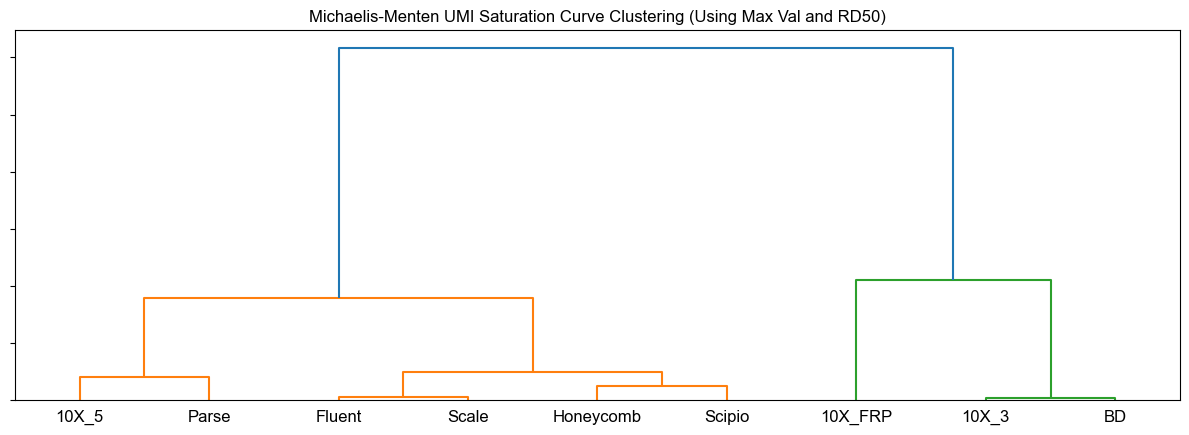

In [40]:
# Create a pivot table for plotting
pivot_df = modeling_df_umi_mm.set_index('platform').loc[:,['max_val', 'RD50']]
pivot_df


##Calculate the linkage on the scaled data: hierarchy clusters. Using ward because it is robust and gives sensible results here
linkage = sch.linkage(pivot_df, method='ward')
order = sch.leaves_list(linkage)

##Create a gridspec instance with 2 rows and single column so we can get both plots on top of each other
gs = gridspec.GridSpec(2,1, height_ratios=[1,2]) ##This ratio makes the dendrogram a bit smaller

##Set figure size
fig = plt.figure(figsize=(12,12))

##First (small) plot for the dendrogram
ax1 = plt.subplot(gs[0, 0])
dendrogram = sch.dendrogram(linkage,labels=pivot_df.index, ax=ax1, orientation='top', color_threshold=20000) ##manually selected threshold
ax1.set_title('Michaelis-Menten UMI Saturation Curve Clustering (Using Max Val and RD50)')
ax1.set_yticklabels([])
ax1.grid(False) #turn off dendrogram grid

plt.tight_layout()
plt.show()

#### <center> Directly Comparing Targeted vs Actual Depth

Here we will compare the actual depth to the targeted depth at all downsampling depths

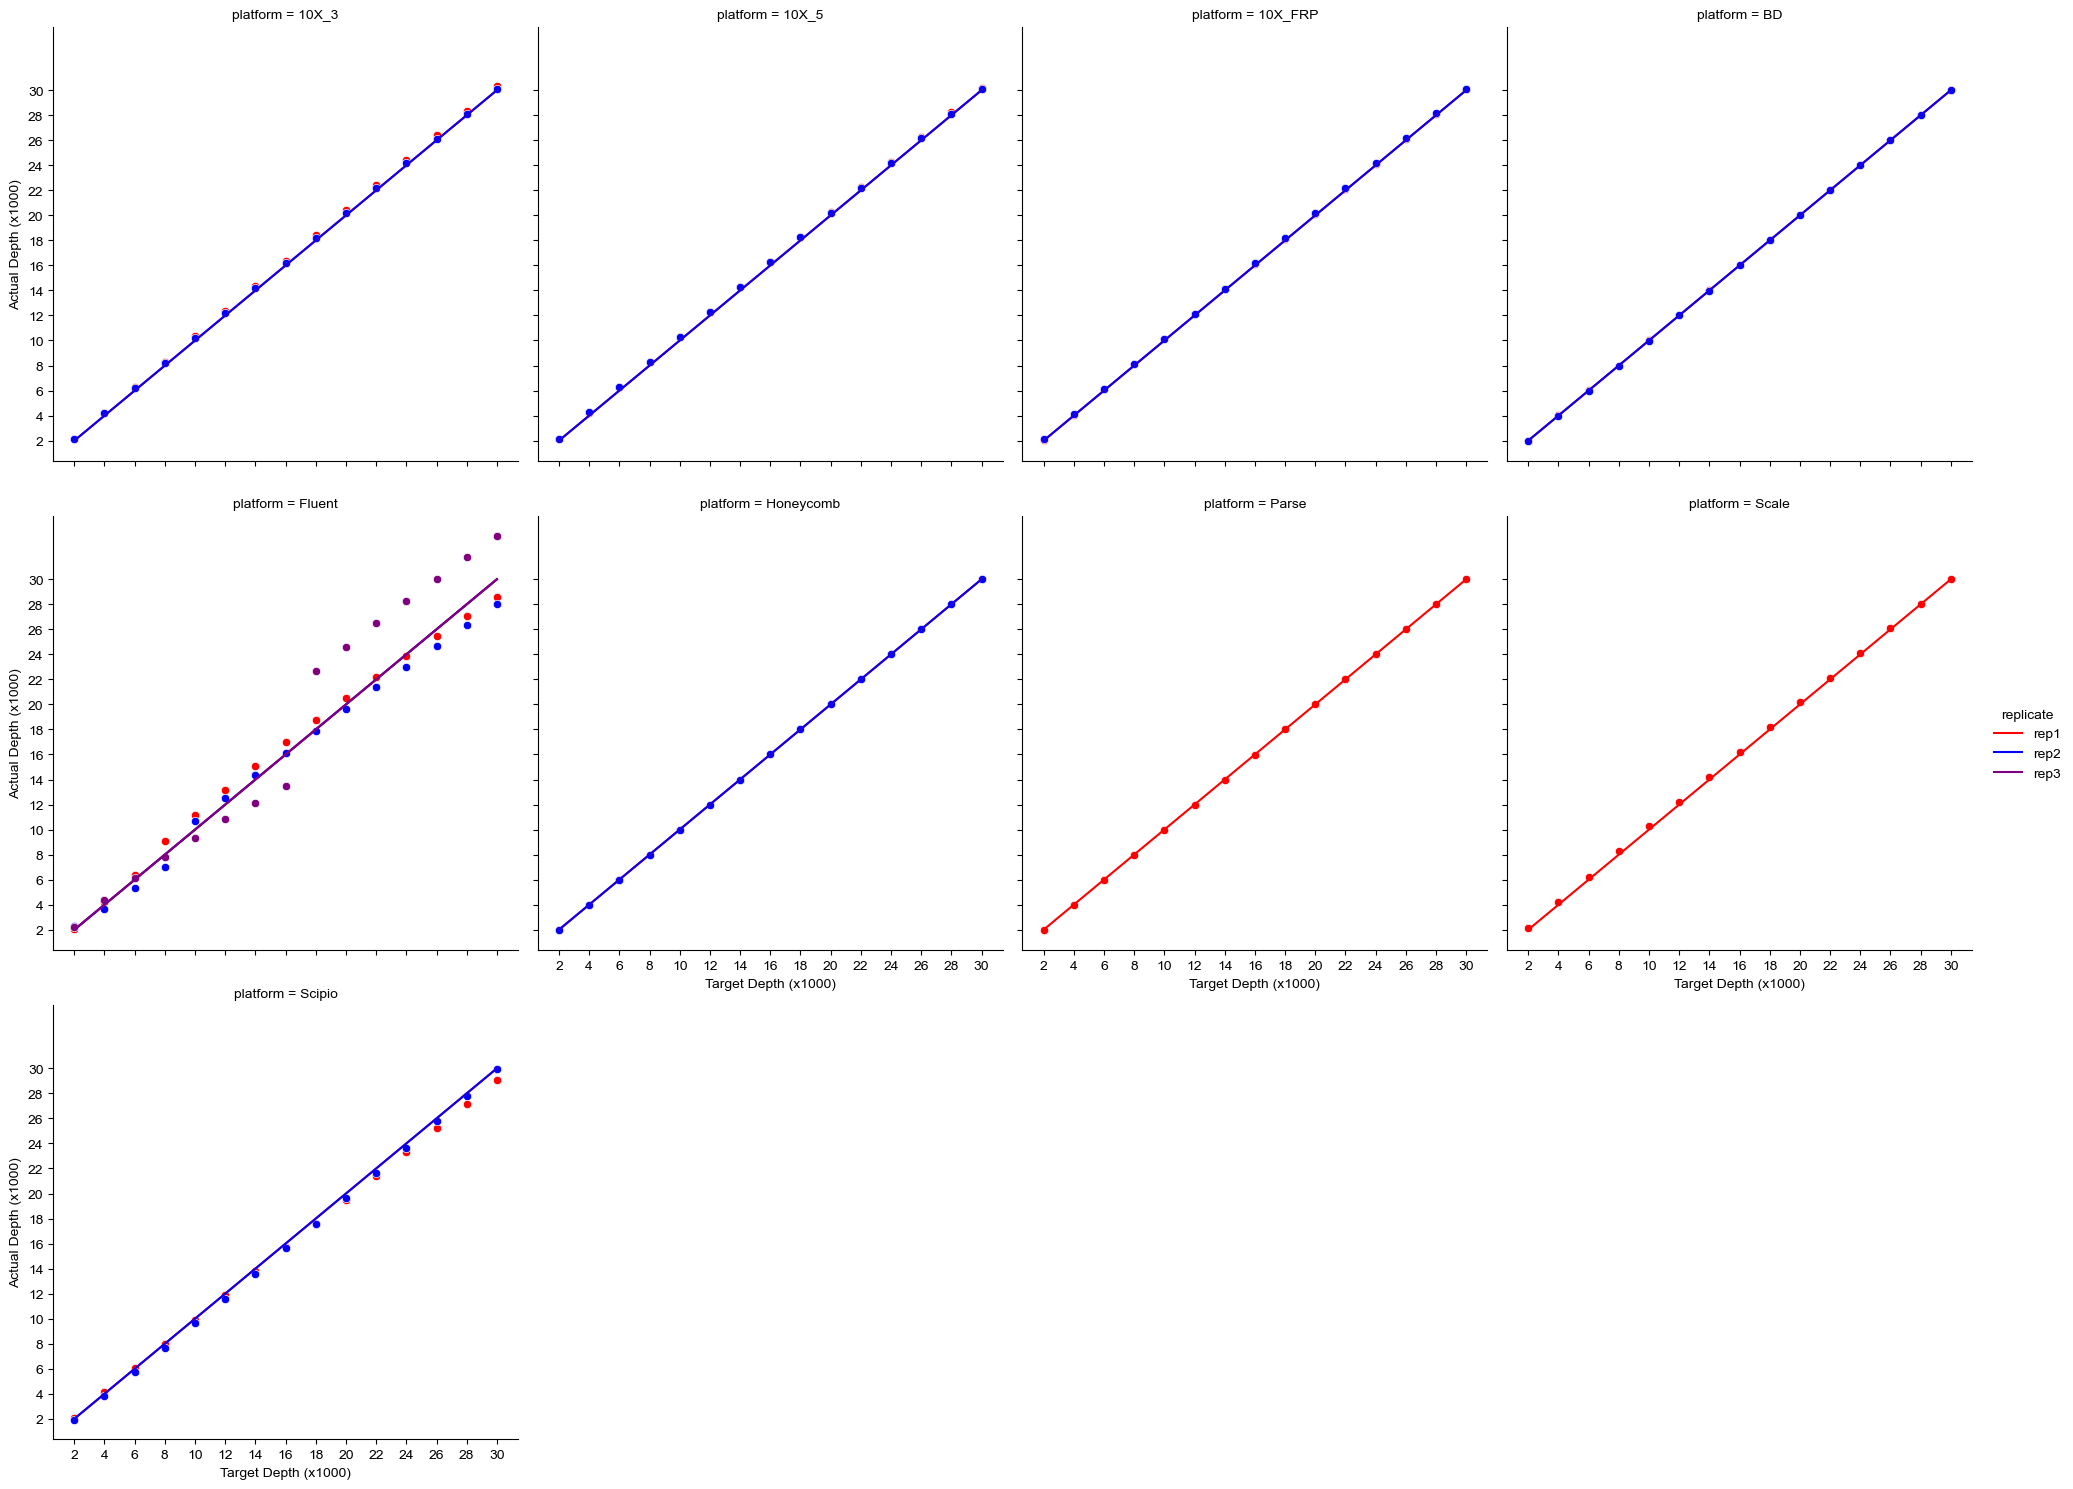

In [41]:
##Actual Depth

##Create a FacetGrid
g = sns.FacetGrid(summary_df, col="platform", hue="replicate", col_wrap=4, height=5, aspect=1, 
                  palette=colors_replicate)

##Map a scatter plot to each facet
g.map(sns.scatterplot, "target_depth_tens", "actual_depth_tens")

##Map a line plot for perfect match
g.map(sns.lineplot, "target_depth_tens", "target_depth_tens")

# Set x-axis ticks
g.set(xticks=range(2, 31, 2), yticks=range(2, 31, 2))  # range from 2 to 28 in steps of 2

##Set x and y axis labels
g.set_axis_labels("Target Depth (x1000)", "Actual Depth (x1000)")

##Add a legend
g.add_legend()

##Show the plot
plt.show()

Here we will compare the actual depth to the targeted depth at 30K downsampling depth to assess how close each of the samples truly is to the 30K target

In [42]:
summary_df

file_tag       method  target_depth_tens  n_cells  \
10X_3-rep1_10k   10X_3p-rep1_10k   10X_3-rep1                 10     8272   
10X_3-rep1_12k   10X_3p-rep1_12k   10X_3-rep1                 12     8298   
10X_3-rep1_14k   10X_3p-rep1_14k   10X_3-rep1                 14     8324   
10X_3-rep1_16k   10X_3p-rep1_16k   10X_3-rep1                 16     8350   
10X_3-rep1_18k   10X_3p-rep1_18k   10X_3-rep1                 18     8359   
...                          ...          ...                ...      ...   
Scipio-rep2_2k    Scipio-rep2_2k  Scipio-rep2                  2     4692   
Scipio-rep2_30k  Scipio-rep2_30k  Scipio-rep2                 30     4558   
Scipio-rep2_4k    Scipio-rep2_4k  Scipio-rep2                  4     4726   
Scipio-rep2_6k    Scipio-rep2_6k  Scipio-rep2                  6     4757   
Scipio-rep2_8k    Scipio-rep2_8k  Scipio-rep2                  8     4757   

                 median_gene_counts  median_umi_counts  mean_gene_counts  \
10X_3-rep1_10k               2136.0             4794.5       2169.904376   
10X_3-rep1_12k               2318.0             5431.0       2346.495180   
10X_3-rep1_14k               2474.0             6007.5       2492.430322   
10X_3-rep1_16k               2605.0             6523.5       2616.028623   
10X_3-rep1_18k               2722.0             6999.0       2725.257806   
...                             ...                ...               ...   
Scipio-rep2_2k                270.0              362.0        309.745098   
Scipio-rep2_30k               635.0             1082.0        705.581395   
Scipio-rep2_4k                372.5              536.5        423.854211   
Scipio-rep2_6k                429.0              647.0        486.048560   
Scipio-rep2_8k                468.0              722.0        528.050872   

                 mean_umi_counts  sd_gene_counts  sd_umi_counts  \
10X_3-rep1_10k       5195.427246      808.765046    2706.785889   
10X_3-rep1_12k       5882.826660      862.157520    3075.931152   
10X_3-rep1_14k       6492.460449      908.163372    3409.241211   
10X_3-rep1_16k       7037.778809      946.566760    3710.508789   
10X_3-rep1_18k       7539.133301      977.480074    3979.717285   
...                          ...             ...            ...   
Scipio-rep2_2k        439.918365      161.851277     282.048279   
Scipio-rep2_30k      1293.773560      302.379262     770.170166   
Scipio-rep2_4k        653.550964      210.663807     415.543671   
Scipio-rep2_6k        781.683838      235.233495     493.858673   
Scipio-rep2_8k        872.595093      250.504027     547.719727   

                 targeted_fastq_reads  target_depth  actual_depth  \
10X_3-rep1_10k               85530000         10000  10339.700193   
10X_3-rep1_12k              102636000         12000  12368.763557   
10X_3-rep1_14k              119742000         14000  14385.151370   
10X_3-rep1_16k              136848000         16000  16388.982036   
10X_3-rep1_18k              153954000         18000  18417.753320   
...                               ...           ...           ...   
Scipio-rep2_2k                9096000          2000   1938.618926   
Scipio-rep2_30k             136440000         30000  29934.181659   
Scipio-rep2_4k               18192000          4000   3849.344054   
Scipio-rep2_6k               27288000          6000   5736.388480   
Scipio-rep2_8k               36384000          8000   7648.517974   

                 actual_depth_tens platform replicate  
10X_3-rep1_10k           10.339700    10X_3      rep1  
10X_3-rep1_12k           12.368764    10X_3      rep1  
10X_3-rep1_14k           14.385151    10X_3      rep1  
10X_3-rep1_16k           16.388982    10X_3      rep1  
10X_3-rep1_18k           18.417753    10X_3      rep1  
...                            ...      ...       ...  
Scipio-rep2_2k            1.938619   Scipio      rep2  
Scipio-rep2_30k          29.934182   Scipio      rep2  
Scipio-rep2_4k            3.849344   Scipio     

In [43]:
summary_df.loc[summary_df['target_depth_tens'] == 30,:]

file_tag          method  target_depth_tens  \
10X_3-rep1_30k           10X_3p-rep1_30k      10X_3-rep1                 30   
10X_3-rep2_30k           10X_3p-rep2_30k      10X_3-rep2                 30   
10X_5-rep1_30k           10X_5p-rep1_30k      10X_5-rep1                 30   
10X_5-rep2_30k           10X_5p-rep2_30k      10X_5-rep2                 30   
10X_FRP-rep1_30k        10X_FRP-rep1_30k    10X_FRP-rep1                 30   
10X_FRP-rep2_30k        10X_FRP-rep2_30k    10X_FRP-rep2                 30   
BD-rep1_30k         BD_Rhapsody-rep1_30k         BD-rep1                 30   
BD-rep2_30k         BD_Rhapsody-rep2_30k         BD-rep2                 30   
Fluent-rep1_30k          Fluent-rep1_30k     Fluent-rep1                 30   
Fluent-rep2_30k          Fluent-rep2_30k     Fluent-rep2                 30   
Fluent-rep3_30k          Fluent-rep3_30k     Fluent-rep3                 30   
Honeycomb-rep1_30k    Honeycomb-rep1_30k  Honeycomb-rep1                 30   
Honeycomb-rep2_30k    Honeycomb-rep2_30k  Honeycomb-rep2                 30   
Parse-rep1_30k            Parse-rep1_30k      Parse-rep1                 30   
Scale-rep1_30k            Scale-rep1_30k      Scale-rep1                 30   
Scipio-rep1_30k          Scipio-rep1_30k     Scipio-rep1                 30   
Scipio-rep2_30k          Scipio-rep2_30k     Scipio-rep2                 30   

                    n_cells  median_gene_counts  median_umi_counts  \
10X_3-rep1_30k         8453              3178.0             9052.0   
10X_3-rep2_30k        11268              3178.0             9197.0   
10X_5-rep1_30k         8455              2023.0             5035.0   
10X_5-rep2_30k         8135              2130.0             5036.0   
10X_FRP-rep1_30k      10316              4182.0            13513.5   
10X_FRP-rep2_30k       8048              4211.5            13629.5   
BD-rep1_30k           11333              2865.0             9236.0   
BD-rep2_30k           16841              2811.0             8886.0   
Fluent-rep1_30k       11333              1560.0             3148.0   
Fluent-rep2_30k       10306              1255.5             2077.0   
Fluent-rep3_30k        9052              1138.0             1978.0   
Honeycomb-rep1_30k    10000              1027.5             1982.5   
Honeycomb-rep2_30k    10000               931.0             1802.5   
Parse-rep1_30k        15585              2350.0             4865.0   
Scale-rep1_30k        12048              1756.0             2951.5   
Scipio-rep1_30k        3531               820.0             1542.0   
Scipio-rep2_30k        4558               635.0             1082.0   

                    mean_gene_counts  mean_umi_counts  sd_gene_counts  \
10X_3-rep1_30k           3142.754880      9702.407227     1111.281263   
10X_3-rep2_30k           3057.029908      9671.426758     1153.629422   
10X_5-rep1_30k           2115.833708      5624.067871      783.482073   
10X_5-rep2_30k           2182.528089      5571.701660      844.261447   
10X_FRP-rep1_30k         4015.811361     13168.421875     1044.267366   
10X_FRP-rep2_30k         4002.830268     12961.182617     1085.813306   
BD-rep1_30k              2828.140563      9387.272214      723.519151   
BD-rep2_30k              2734.346001      8862.083487      757.121597   
Fluent-rep1_30k          1708.117268      3711.927979      754.677714   
Fluent-rep2_30k          1479.457209      3003.272705      785.211062   
Fluent-rep3_30k          1282.823906      2559.897949      687.218559   
Honeycomb-rep1_30k       1236.789300      2744.983643      677.318557   
Honeycomb-rep2_30k       1153.366100      2543.761963      631.098406   
Parse-rep1_30k           2454.983959      5640.134766      878.590517   
Scale-rep1_30k           1813.551129      3252.421631      601.377830   
Scipio-rep1_30k           913.150099      1903.084717      402.200609   
Scipio-rep2_30k           705.581395      1293.773560      302.379262   

                    sd_umi_counts

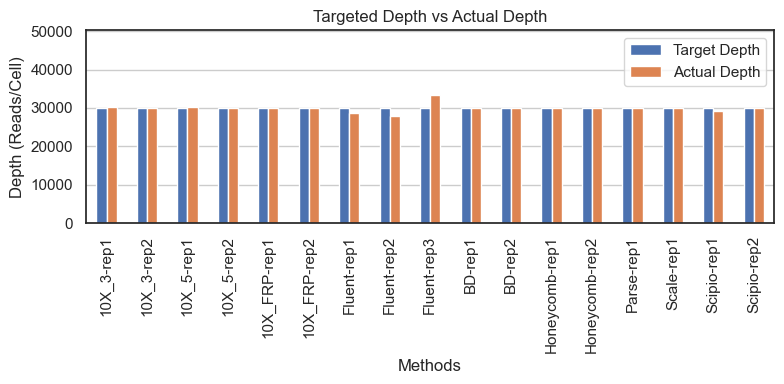

In [44]:
summary_30k_depth = summary_df.loc[summary_df['target_depth_tens'] == 30, ['target_depth', 'actual_depth', 'method']].sort_values('method')

##Now plot barplots for each of them 
sns.set(style='white')

#create stacked bar chart and reorder
ax = summary_30k_depth.set_index('method').loc[plotting_order,:].plot(kind='bar', stacked=False, figsize=(8,4)) ##Actual dimensions for paper are 80mm x 40mm

##add labels and annotations
ax.set_xlabel('Methods')
ax.set_ylabel('Depth (Reads/Cell)')
ax.set_title('Targeted Depth vs Actual Depth')

# get heights to adjust legend
heights = [] ##initialize list of heights to be used to set limit
for j, p in enumerate(ax.patches):
    heights.append(p.get_height() * 1.5)

##move legend outside plot
labels=['Target Depth', 'Actual Depth']
ax.legend(labels)

##Add grid lines for y-axis
ax.grid(axis='y')

##adjust limits to the max of the heihgts
ax.set_ylim([0, np.nanmax(heights)])

##show plot
plt.tight_layout()
plt.show()

#### <center> N Cells vs Targeted vs Loaded at 30k

In [45]:
##add cell targets
targeted_file = #INSERT HERE
targeted_cells = pd.read_csv(targeted_file)

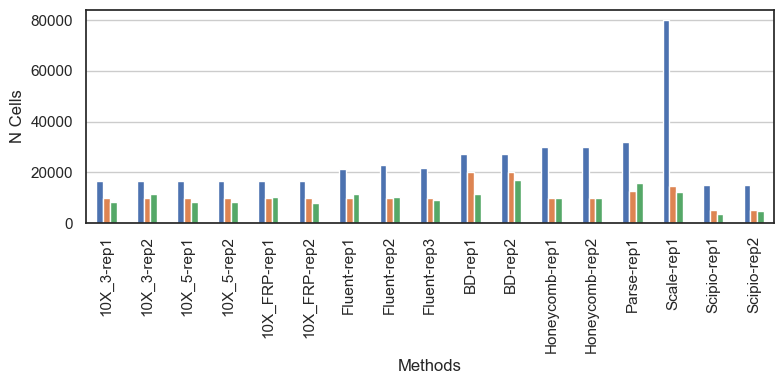

In [46]:
##subset to 30k and variables of interest
summary_30k_cells = summary_df.loc[summary_df['target_depth_tens'] == 30, ['method', 'n_cells']].sort_values('method')

summary_30k_cells = pd.merge(summary_30k_cells, targeted_cells, how="left", on = "method")
summary_30k_cells = summary_30k_cells[['method', 'n_cells_loaded', 'n_cells_target', 'n_cells']]

##Now plot barplots for each of them 
sns.set(style='white')

#reorder according to plotting order and create stacked bar chart
ax = summary_30k_cells.set_index('method').loc[plotting_order,:].plot(kind='bar', stacked=False, figsize=(8,4)) ##Actual dimensions for paper are 80mm x 40mm

##add labels and annotations
ax.set_xlabel('Methods')
ax.set_ylabel('N Cells')

# remove legend
ax.get_legend().remove()

##Add grid lines for y-axis
ax.grid(axis='y')

##show plot
plt.tight_layout()
plt.show()

Let's look at total number of cells

In [48]:
summary_30k_cells['n_cells'].sum()

169262

In [49]:
##save 30k cells as csv
summary_30k_cell_file = os.path.join(parent_dir, 'cell_calling/cell_recovery_30k.csv')
summary_30k_cells.to_csv(summary_30k_cell_file)

Now let's look at percent recovery

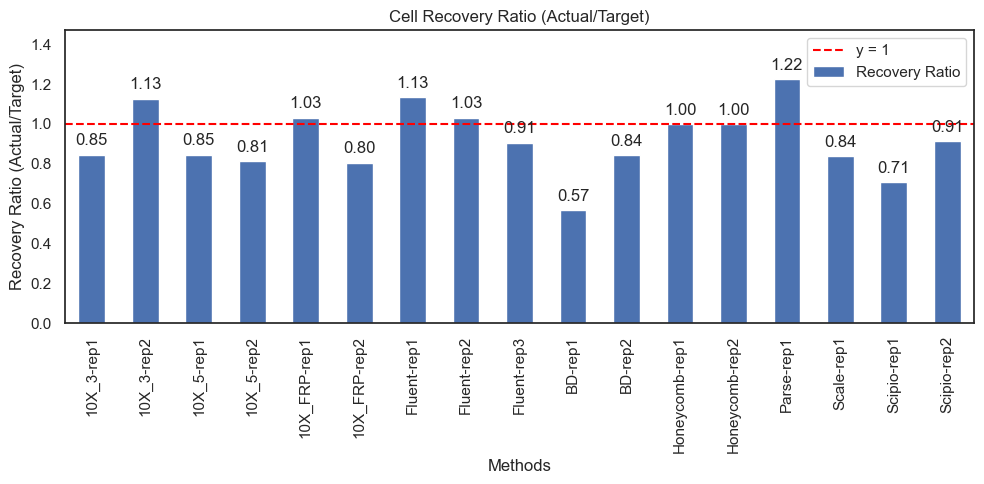

In [50]:
## add a new column 'cell_recovery'
summary_30k_cells['cell_recovery'] = summary_30k_cells['n_cells'] / summary_30k_cells['n_cells_target']

## Now plot the column 'cell_recovery' for each method
sns.set(style='white')

ax = summary_30k_cells[['method', 'cell_recovery']].set_index('method').loc[plotting_order,:].plot(kind='bar', figsize=(10,5))

## add labels and annotations
ax.set_xlabel('Methods')
ax.set_ylabel('Recovery Ratio (Actual/Target)')
ax.set_title('Cell Recovery Ratio (Actual/Target)')

## add a red dashed line at y=1
plt.axhline(1, color='red', linestyle='--')

## annotate bars with values
heights = [] ##initialize list of heights to be used to set limit
for p in ax.patches:
    heights.append(p.get_height() * 1.2)
    ax.annotate('{:.2f}'.format(p.get_height()), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 10), 
                     textcoords = 'offset points')


##adjust limits to the max of the heihgts
ax.set_ylim([0, np.nanmax(heights)])

## Add Legend
labels=['y = 1', 'Recovery Ratio']
ax.legend(labels)

plt.tight_layout()
plt.show()

Let's see if we can identify cell recovery groupings/tiers with a kernel density estimator. First we will find the average per platform , then we will plot histogram to understand where grouping might occur, then we will perform grouping

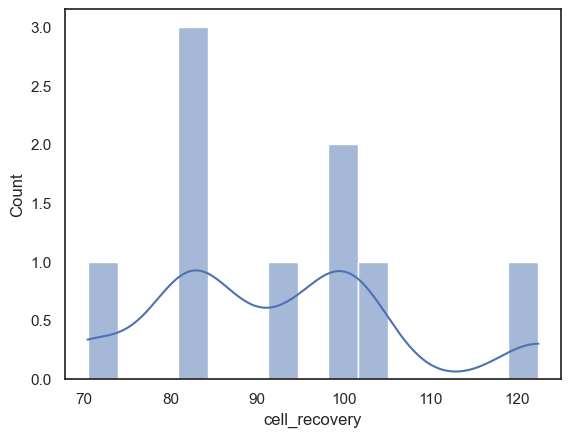

In [51]:
##set style
sns.set(style='white')

##first group by platform, get mean, and sort by ascending value
cell_recovery = summary_30k_cells[['method', 'cell_recovery']]
cell_recovery['cell_recovery'] = cell_recovery['cell_recovery'] * 100 ##scale cell recovery to percentages
cell_recovery['platform'] = cell_recovery['method'].str.split('-', expand=True)[0]
cell_recovery = cell_recovery.groupby('platform')['cell_recovery'].mean().sort_values(ascending=True)

##plot histogram with a kde on top
fig, ax = plt.subplots(1,1)
sns.histplot(cell_recovery, bins=15, kde=True, kde_kws={'bw_method':0.3}, ax=ax)
plt.show()

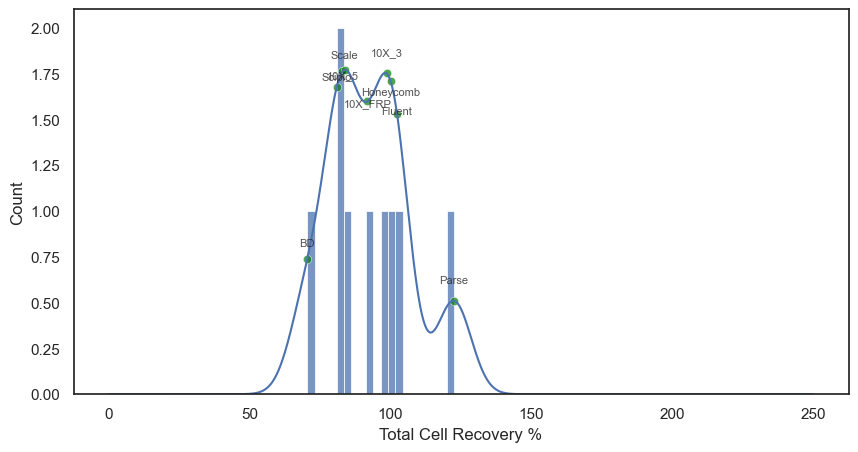

In [52]:
##fit kernel density estimator
bw_method=0.4 ##manually selected to give relatively smooth curve with reasonable breaks
X_range = np.linspace(0,250, 1000) #X values on range of 0 to 250 based on histogram above
kernel = gaussian_kde(cell_recovery, bw_method=bw_method, weights=None) #define kde with bw_method
fitted_dens = kernel.evaluate(X_range) #get density
predicted_dens = kernel.evaluate(cell_recovery)
ordered_labels = cell_recovery.index

##scale density to get onto scale of histogram
fitted_dens = fitted_dens *70
predicted_dens = predicted_dens*70

 ##Calculate the negative density values so we can find minima by finding peaks of the negative density
neg_dens = -fitted_dens

##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
with ignore_warnings(category=ConvergenceWarning):
    minima_indices, _ = find_peaks(neg_dens)

# ##get thresholds
# cell_recovery_thresholds = X_range[minima_indices]

##plot split with points and thresholds
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(X_range, fitted_dens)
sns.histplot(cell_recovery, bins=20, ax=ax)
sns.scatterplot(x=cell_recovery, y=predicted_dens, color='green',  alpha=0.7, ax=ax)

# ##Add threshold lines
# [ax.axvline(_x, linewidth=1, color="red", linestyle="-") for _x in cell_recovery_thresholds]

##Adding labels

np.random.seed(46)
y_jitter = (np.random.rand(len(cell_recovery))-0.5)/5  # get jitter in range 
for i, txt in enumerate(ordered_labels):
    ax.annotate(txt, ((cell_recovery[i]), (predicted_dens[i]+y_jitter[i])), alpha=0.8, ha='center', va='bottom', fontsize=8) ##add vertical jitter
    
##Format Axes
ax.set_xlabel('Total Cell Recovery %')
    
plt.show()

It appears that there is some central grouping around the peak and that there is a fall-off in different ranges outside of this. For instance BD and Parse deviate from the centroid by a similar amount in opposite directions. We will use a heuristic of deviation to define grouping tiers (not in this notebook), but it should get BD and Parse in the lower tier and the rest in the top tier.

In [53]:
##save as table
cell_recovery_agg_file = os.path.join(supplement_table_dir, 'Table2b_Cell_Recovery_agg.csv')
pd.DataFrame(cell_recovery).to_csv(cell_recovery_agg_file)
cell_recovery

platform
BD            70.435000
Scipio        80.890000
10X_5         82.950000
Scale         83.666667
10X_FRP       91.820000
10X_3         98.605000
Honeycomb    100.000000
Fluent       102.303333
Parse        122.456195
Name: cell_recovery, dtype: float64

In [54]:
recovery_table = summary_30k_cells[['method', 'cell_recovery']].sort_values('cell_recovery')
recovery_table['cell_recovery'] = recovery_table['cell_recovery'] * 100
recovery_table

method  cell_recovery
6          BD-rep1      56.665000
15     Scipio-rep1      70.620000
5     10X_FRP-rep2      80.480000
3       10X_5-rep2      81.350000
14      Scale-rep1      83.666667
7          BD-rep2      84.205000
0       10X_3-rep1      84.530000
2       10X_5-rep1      84.550000
10     Fluent-rep3      90.520000
16     Scipio-rep2      91.160000
11  Honeycomb-rep1     100.000000
12  Honeycomb-rep2     100.000000
9      Fluent-rep2     103.060000
4     10X_FRP-rep1     103.160000
1       10X_3-rep2     112.680000
8      Fluent-rep1     113.330000
13      Parse-rep1     122.456195

save as supplement table

In [55]:
cell_recovery_file = os.path.join(supplement_table_dir, 'Table2a_Cell_Recovery_Pct.csv')
recovery_table.to_csv(cell_recovery_file, index=False)
cell_recovery_agg_file = os.path.join(supplement_table_dir, 'Table2b_Cell_Recovery_Pct_agg.csv')
pd.DataFrame(cell_recovery).to_csv(cell_recovery_agg_file, index=True)

#### <center> OTSU and KDE Cell Caller to Assess Stability of Cell Calls with Universal Caller

The OTSU cell caller identifies breaks in the data that generate N categories. We have set N to 3 based on the expectation that we will have a high and low rna-abundance category along with a background (not a cell) category. We will use the high abundance threshold as the threshold for a cell since it tends to correspond with the inflection point in the UMI rank vs log UMI count plots often used to identify cells

The kernel-density estimator based caller will fit a density to a histogram of the log UMI counts and find the local minima as the thresholds for cell calling. We will use the. most conservative threshold for cell calling, which corresponds to the inflection point the UMI rank vs log UMI count plots often used to identify cells.

As such, we need to process, raw unfiltered results (ie background droplets not removed)

Load unfiltered file results

In [56]:
##Get filenames for predictions into a dictionary (Set key as method with sampling depth)
unfiltered_files = {re.match(r'(.*?_[0-9]+k).*raw_feature_bc_matrix', f).group(1) : os.path.join(data_dir, f) 
                    for f in os.listdir(data_dir) 
                    if re.match(r'.*raw_feature_bc_matrix', f)}

##sort files by keys
unfiltered_files = dict(sorted(unfiltered_files.items()))

##replace hive with honeycomb
unfiltered_files = {key.replace('Hive', 'Honeycomb'):value for key, value in unfiltered_files.items()}

##replace Parse-rep2 with Parse-rep1 since only using one replicate
unfiltered_files = {key.replace('Parse-rep2', 'Parse-rep1'): value for key, value in unfiltered_files.items()}

In [57]:
def threshold_raw_otsu(adata, n_cat=3, min_genes=5, min_cells=3, selected_threshold_i=-1, log_base=10):
    
    """
    Calculate threshold for cell calling using the Otsu method on log-transformed UMI counts.
    Based on the cell calling done in both:
        1. De Rop, F.V., Hulselmans, G., Flerin, C. et al. Systematic benchmarking of single-cell ATAC-sequencing protocols. 
           Nat Biotechnol (2023). https://doi.org/10.1038/s41587-023-01881-x
        2. Heiser, Cody N., Victoria M. Wang, Bob Chen, Jacob J. Hughey, and Ken S. Lau. 
           Automated quality control and cell identification of droplet-based single-cell data using dropkick. 
           Genome Research (2021). https://doi.org/10.1101/gr.271908.120
           
    Thresholding is done with the skimage.filters function threshold_multiotsu: 
        1. https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html
    

    Parameters:
    - adata (AnnData): Annotated data containing UMI counts.
    - n_cat (int): Number of categories for Otsu's method. Default is 3, which generates 2 thresholds.
    - min_genes (int): Minimum number of genes a barcode must have. Default is 5.
    - min_cells (int): Minimum number cells a gene must be present in to be counted. Default is 3.
    - selected_threshold_i (int): Index of the selected threshold from the Otsu method results. 
      Default is -1 (most conservative threshold)
    - log_base (int or float): Base of logarithm to take when defining thresholds
      

    Returns:
    - log_thresholds (numpy.ndarray): Log-transformed thresholds from Otsu's method.
    - converted_thresholds (list): Thresholds converted from log scale to regular scale.
    - chosen_threshold (int): The selected threshold based on provided index.
    - log_umis (numpy.ndarray): Log-transformed UMI counts.
    - sorted_umis (list): Sorted UMI counts.
    - ranks (numpy.ndarray): Ranks of barcodes based on sorted UMI counts.
    - n_cells (int): Number of cells selected based on the chosen threshold.
    """
    
    ## filter barcodes with few genes genes or counts since they are not useful for this method
    ## then get qc statistics for all methods (gene_counts and barcode counts)
    sc.pp.filter_cells(adata, min_genes = min_genes) ##5 is default because used in scATAQ-seq paper
    sc.pp.filter_genes(adata, min_cells = min_cells) ##3 is default because used in scATAQ-seq paper
    sc.pp.calculate_qc_metrics(adata, inplace = True)
    
    ##calculate log_umis from filtered barcodes (ie non-zero barcodes) and find thresholds
    ##Note that we filter off extremely low UMIs (known to not be cells like 10 umis) to make sure we get essentially 3 populations
    log_umis = np.log(adata.obs['total_counts']) / np.log(log_base) ##by def: log_b(x) = log_c(x) / log_c(b)
    log_thresholds = threshold_multiotsu(log_umis.to_numpy(), n_cat) ##find threshold on filtered umis

    ##calculate ranks for each barcode
    sorted_umis = sorted(adata.obs['total_counts'], reverse = True)
    ranks = np.arange(len(sorted_umis))+1

    ##calculate threshold in regular scale (ie not log)
    converted_thresholds = [int(log_base**i)for i in log_thresholds]

    ##select more conservative threshold of the two found (for mid-high RNA content cells)
    chosen_threshold = converted_thresholds[selected_threshold_i]

    ##Calculate how many cells are selected based on this threshold
    n_cells= np.sum(adata.obs["total_counts"] >= chosen_threshold)
    
    ##return results for plotting and filtering on threshold
    return log_thresholds, converted_thresholds, chosen_threshold, log_umis, sorted_umis, ranks, n_cells


def plot_cell_calling_otsu(adata, method, log_thresholds, converted_thresholds, chosen_threshold, log_umis, sorted_umis, ranks, n_cells,
                           log_base=10, save_fig=False, output_dir=None, figsize=(10,5), legend_labels=None, bins=50, 
                           bw_method=0.25, bw_adjust=1):
    
    """
    Plot cell calling results along with thresholds.

    Parameters:
    - adata (AnnData): Annotated data containing UMI counts.
    - method (str): Name of the method used for cell calling.
    - log_thresholds (numpy.ndarray): Log-transformed thresholds from Otsu's method.
    - converted_thresholds (list): Thresholds converted from log scale to regular scale.
    - chosen_threshold (int): The selected threshold.
    - log_umis (numpy.ndarray): Log-transformed UMI counts.
    - sorted_umis (list): Sorted UMI counts.
    - ranks (numpy.ndarray): Ranks of barcodes based on sorted UMI counts.
    - n_cells (int): Number of cells selected based on the chosen threshold.
    - save_fig (bool): Whether to save the figure. Default is False.
    - output_dir (str): Output directory to save the figure. Required if save_fig is True.
    - figsize (tuple): Figure size. Default is (10, 5).
    - legend_labels (list): Labels for the legend. Default is None.
    - log_base (int or float): Base of logarithm to take when defining thresholds
    - bins (int): Number of bins to plot in histogram
    - bw_method (str, int): bandwidth method for kerndel density estimator (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde)
    - bw_adjust (int): multiplier to adjust bw_method value (large means smoother; see https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

    Returns:
    - None
    """
    
    # ##check if the user needs to provide legend labels
    # if len(converted_thresholds) >= 3:
    #     raise ValueError("More than 2 thresholds, so need to provide your own 'legend_labels'")
    
    ##define linetypes
    linetypes=["--", "-"] if len(converted_thresholds)==2 else ["-"]
    
    ##get log-base for x-axis label
    if log_base == np.exp(1):
        log_base = "ln"
    else: 
        log_base=f'Log{log_base}'
    
    ##setup fig
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ##Plot histogram with thresholds
    sns.histplot(log_umis, bins=bins, ax = axes[0], kde=True, kde_kws = {'bw_method':bw_method, 'bw_adjust': bw_adjust}).set_yscale('log')
    # sns.kdeplot(log_umis, bw_method='silverman', ax=axes[0])
    [axes[0].axvline(_x, linewidth=1, color='r', linestyle=l) for _x, l in zip(log_thresholds, linetypes)]
    axes[0].set(xlabel=f"{log_base}(Total UMI Counts)", ylabel="Frequency")
    axes[0].set_xlim([0, None])

    #Define legend labels
    if legend_labels is None:
        
        ##identify the index of the chosen threshold and note that it was selected in legend_labels
        selected_index = next(i for i, t in enumerate(converted_thresholds) if t == chosen_threshold)
        # legend_labels = ['Lenient Threshold', 'Conservative Threshold'] 
        legend_labels = [f'Threshold Candidate {i}' for i in range(1, (len(converted_thresholds) + 1))]
        legend_labels = [f'{lab} (Selected)' if i == selected_index else lab for i, lab in enumerate(legend_labels)]
        
    if len(legend_labels) != len(converted_thresholds):
        raise ValueError("'legend_labels' must be the same length as 'converted_threshold'")

    ##Plot knee plots with thresholds
    sns.lineplot(x=ranks, y=sorted_umis, ax = axes[1])
    [axes[1].axhline(t, linewidth=1, color='r', linestyle=lin, label=lab) 
     for t,lin,lab in zip(converted_thresholds, linetypes, legend_labels)]
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set(xlabel="Rank", ylabel="Total UMI Counts")
    axes[1].set_xlim([1, None])
    axes[1].set_ylim([1, None]) ##No upper y_lim
    # axes[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.legend(loc="upper center", bbox_to_anchor=(-0.15, -0.175), ncol=2)

    ##add title
    plt.suptitle(f"{method} {n_cells} cells; Threshold: {chosen_threshold} counts")
    
    ##Save figure if requested
    if save_fig is True:
        
        ##check if output directory is provided
        if output_dir is None:
            raise TypeError("If 'save_fig' is True, 'output_dir' must be supplied")
            
        if method is None:
            raise TypeError("If 'save_fig' is True, 'method' name must be supplied")
        
        ##save files as .png
        outfile = os.path.join(output_dir, f'{method}_otsu_cell_selection.png')
        print(f'Saving {method} to: {outfile}')
        fig.savefig(outfile)
    
    plt.show()


def threshold_raw_kde(adata, bw_method=0.25, bw_adjust=1, min_genes=5, min_cells=3, 
                  selected_threshold_i=-1, log_base=10, lb_percentile=10, ub_percentile=90):
    
    """
    Calculate potential thresholds for selecting cells based on kernel density estimation.

    Parameters:
    adata (AnnData): Annotated data matrix with observation (cell) information.
    bw_method (float or str, optional): Bandwidth for kernel density estimation. Default is 0.25.
    bw_adjust (float, optional): Bandwidth adjustment factor. Default is 1.
    min_genes (int, optional): Minimum number of genes required for a cell to be considered valid. Default is 5.
    min_cells (int, optional): Minimum number of cells a gene must be present in to be counted. Default is 3.
    selected_threshold_i (int, optional): Index of the selected threshold from potential thresholds.
    log_base (float, optional): Base for logarithmic calculations. Default is 10.
    lb_percentile (float, optional): Lower percentile of data range for evaluating kernel density. Default is 10%. (truncates left tail)
    ub_percentile (float, optional): Upper percentile of data range evaluating kernel density. Default is 90%. (truncates right tail)

    Returns:
    list: List of potential threshold values in regular scale.
    """
    
   ## filter barcodes with few genes genes or counts since they are not useful for this method
    ## then get qc statistics for all methods (gene_counts and barcode counts)
    sc.pp.filter_cells(adata, min_genes = min_genes) ##5 is default because used in scATAQ-seq paper
    sc.pp.filter_genes(adata, min_cells = min_cells) ##3 is default because used in scATAQ-seq paper
    sc.pp.calculate_qc_metrics(adata, inplace = True)
    
    ##calculate log_umis from filtered barcodes (ie non-zero barcodes)
    ##Note that we filtered off extremely low UMIs (known to not be cells like 10 umis) to make sure we get essentially 3 populations
    log_umis = np.log(adata.obs['total_counts']) / np.log(log_base) ##by def: log_b(x) = log_c(x) / log_c(b)
    
    ##check if we need to adjust bw_method
    if isinstance(bw_method, (int, float)):
        bw_method = bw_method*bw_adjust
        
    if bw_adjust != 1 and not isinstance(bw_method, (int, float)):
        raise TypeError("'bw_adjust' is only applicable when 'bw_method' is a number type (int, float)")
        
    ##check to make sure lb and ub percentile are on 1-100 not 0-1 scale
    if ub_percentile > 1 or ub_percentile < 0:
        raise ValueError("'lb_percentile' and 'ub_percentile' should be on 0-1 scale")
        
    if lb_percentile < 0:
        raise ValueError("'lb_percentile' must be a positive float")
    
    ##Find potential thresholds from minima of kde
    ##Note that we are counting a threshold if it is between (lb_percentile, ub_percentile) of the data range because tails can be unsmooth, 
    ##which could generate false local minima that wouldn't be a threshold of interest 
    ##Using percentile of range rather than data to make sure we cover the spread of the data (defaults to 10% and 90%)
    min_log_umis = np.min(log_umis)
    max_log_umis = np.max(log_umis)
    X_range = np.linspace(min_log_umis,max_log_umis, 1000) #X values on range of log_umis to evaluate kde at
    kernel = gaussian_kde(log_umis, bw_method=bw_method, weights=None) #define kde with bw_method
    dens = kernel.evaluate(X_range) #get density
    freq = dens * len(log_umis) #get frequency as density * total N

    ##Calculate the negative density values so we can find minima by finding peaks of the negative density
    neg_dens = -dens

    ##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
    with ignore_warnings(category=ConvergenceWarning):
        minima_indices, _ = find_peaks(neg_dens)

    ##Get corresponding X values for minima estimates, which will be potential log thresholds
    log_thresholds = X_range[minima_indices]
    
    
    ##coerce to list if not an iterable (ie if only one minima is found)
    if len(log_thresholds) == 1:
        log_thresholds = [log_thresholds]
        
    ##check if log_thresholds are inside the bounds of (lb_percentile, ub_percentile) of the data
    ##so we don't include minima from the tails. Exclude if outside the bounds
    data_range = max_log_umis - min_log_umis
    log_umis_lb = min_log_umis + lb_percentile * data_range
    log_umis_ub = min_log_umis + ub_percentile * data_range
    log_thresholds = [i for i in log_thresholds if (i >= log_umis_lb and i <= log_umis_ub)]
        
    ##calculate ranks for each barcode
    sorted_umis = sorted(adata.obs['total_counts'], reverse = True)
    ranks = np.arange(len(sorted_umis))+1
    
    ##give warning if no minima found, but still return
    if len(log_thresholds) == 0:
        print(f"No thresholds (minima) found within ({lb_percentile}, {ub_percentile}) percentiles of data range")
        log_thresholds=None
        converted_thresholds=None
        chosen_threshold=None
        n_cells = None
       
    ##If minima found, calculate non-log thresholds, chosen_thresholds, and n_cells
    else:

        ##calculate threshold in regular scale (ie not log)
        converted_thresholds = [int(log_base**i) for i in log_thresholds]

        ##select more conservative threshold of those found (for mid-high RNA content cells)
        ##If only one is found, it will select that one
        ##Remember we truncated the kde results to not include the values outside [lb_percentile, ub_percentile]
        ##so this should represent the true most conservative threshold
        ##may need to play with bandwidth (bw_method) if results do not match what is expected
        chosen_threshold = converted_thresholds[selected_threshold_i]
    


        ##Calculate how many cells are selected based on this threshold (if found)
        n_cells= np.sum(adata.obs["total_counts"] >= chosen_threshold)
        
    
    ##return results for plotting and filtering on threshold
    return log_thresholds, converted_thresholds, chosen_threshold, log_umis, sorted_umis, ranks, n_cells, freq  
    
    
    
def plot_cell_calling_kde(adata, method, log_thresholds, converted_thresholds, chosen_threshold, log_umis, sorted_umis, ranks, n_cells, freq,
                          log_base=10, save_fig=False, output_dir=None, figsize=(10,5), legend_labels=None, bins=75, 
                          bw_method=0.25, bw_adjust=1):
    
    """
    Plot cell calling results along with thresholds.

    Parameters:
    - adata (AnnData): Annotated data containing UMI counts.
    - method (str): Name of the method used for cell calling.
    - log_thresholds (numpy.ndarray): Log-transformed thresholds from Otsu's method.
    - converted_thresholds (list): Thresholds converted from log scale to regular scale.
    - chosen_threshold (int): The selected threshold.
    - log_umis (numpy.ndarray): Log-transformed UMI counts.
    - sorted_umis (list): Sorted UMI counts.
    - ranks (numpy.ndarray): Ranks of barcodes based on sorted UMI counts.
    - n_cells (int): Number of cells selected based on the chosen threshold.
    - freq (array): Array of frequency values from the associated kde calculated in threshold_kde
    - save_fig (bool): Whether to save the figure. Default is False.
    - output_dir (str): Output directory to save the figure. Required if save_fig is True.
    - figsize (tuple): Figure size. Default is (10, 5).
    - legend_labels (list): Labels for the legend. Default is None.
    - log_base (int or float): Base of logarithm to take when defining thresholds
    - bins (int): Number of bins to plot in histogram (default is 75)
    - bw_method (str, int): bandwidth method for kerndel density estimator (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde)
    - bw_adjust (int): multiplier to adjust bw_method value (large means smoother; see https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

    Returns:
    - None
    """
    
    # ##check if the user needs to provide legend labels
    # if converted_thresholds is not None: ##make sure a threshold was found
    #     if len(converted_thresholds) >= 3 :
    #         raise ValueError("More than 2 thresholds, so need to provide your own 'legend_labels'")
    
    ##get log-base for x-axis label
    if log_base == np.exp(1):
        log_base = "ln"
    else: 
        log_base=f'Log{log_base}'
        
    #Define legend labels if we found thresholds
    if converted_thresholds is not None: ##make sure a threshold was found
        if legend_labels is None:

            ##identify the index of the chosen threshold and note that it was selected in legend_labels
            selected_index = next(i for i, t in enumerate(converted_thresholds) if t == chosen_threshold)
            # legend_labels = [f'Threshold_{i+1}' for i in range(len(converted_thresholds))]
            legend_labels = [f'Threshold Candidate {i}' for i in range(1, (len(converted_thresholds) + 1))]
            legend_labels = [f'{lab} (Selected)' if i == selected_index else lab for i, lab in enumerate(legend_labels)]
    
    
        if len(legend_labels) != len(converted_thresholds):
            raise ValueError("'legend_labels' must be the same length as 'converted_threshold'")
    
    ##Define colors for different thresholds (random except if selected it will be red)
    
    # Get the 'tab20' colormap
    tab20_cmap = plt.colormaps['tab20']
    
    if converted_thresholds is not None: ##make sure threshold was found
        
        # Generate colors excluding blue and red tones from the colormap
        colors = [tab20_cmap(i) for i in np.linspace(0.15, 0.85, len(converted_thresholds))]

        # Assign red color to selected thresholds in legend_labels
        colors = ['red' if "Selected" in lab else col for col, lab in zip(colors, legend_labels)]

    # Plot the estimated PDF for full range of data
    fig, axes = plt.subplots(1,2, figsize=figsize)
    min_log_umis = np.min(log_umis)
    max_log_umis = np.max(log_umis)
    X_plot = np.linspace(min_log_umis, max_log_umis, 1000) 
    axes[0].plot(X_plot, freq)
    sns.histplot(log_umis, bins=bins, ax = axes[0])

    ##add identified thresholds (kde minima) with assigned colors IF found, otherwise just plot histogram
    if log_thresholds is not None:
        [axes[0].axvline(_x, linewidth=1, color=col, linestyle="-") for _x, col in zip(log_thresholds, colors)]

    ##setup plot structure
    axes[0].set(xlabel=f"{log_base}(Total UMI Counts)", ylabel="Frequency")
    axes[0].set_xlim([0, None])
    axes[0].set_yscale('log')


    ##Plot knee plots with thresholds if threshold is found, otherwise just plot knee plot
    sns.lineplot(x=ranks, y=sorted_umis, ax = axes[1])
    if converted_thresholds is not None: ##make sure threshold found
        [axes[1].axhline(t, linewidth=1, color=col, linestyle="-", label=lab) 
         for t, col, lab in zip(converted_thresholds, colors, legend_labels)] # Create horizontal lines for each threshold with the assigned color
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set(xlabel="Rank", ylabel="Total UMI Counts")
    axes[1].set_xlim([1, None])
    axes[1].set_ylim([1, None]) ##No upper y_lim

    ##add title (and legend if thresholds found)
    if chosen_threshold is not None:
        plt.legend(loc="upper center", bbox_to_anchor=(-0.15, -0.175), ncol=2)
        plt.suptitle(f"{method} {n_cells} cells; Threshold: {chosen_threshold} counts")
    else: 
        plt.suptitle(f"Knee plot. No minima found; cannot call cells with KDE")
    
    ##Save figure if requested
    if save_fig is True:
        
        ##check if output directory is provided
        if output_dir is None:
            raise TypeError("If 'save_fig' is True, 'output_dir' must be supplied")
            
        if method is None:
            raise TypeError("If 'save_fig' is True, 'method' name must be supplied")
        
        ##save files as .png
        outfile = os.path.join(output_dir, f'{method}_kde_cell_selection.png')
        print(f'Saving {method} to: {outfile}')
        fig.savefig(outfile)
    
    plt.show()


In [58]:
##The following adds original cell counts to help us calculate actual depth rather than targeted depth
    
##original cell counts
original_cell_counts = {
    "10X_3-rep1": 8553,
    "10X_3-rep2": 11296,
    "10X_5-rep1": 8514,
    "10X_5-rep2": 8156,
    "10X_FRP-rep1": 10347,
    "10X_FRP-rep2": 8081,
    "BD-rep1": 11342,
    "BD-rep2": 16834,
    "Fluent-rep1": 10804,
    "Fluent-rep2": 12422,
    "Fluent-rep3": 14223,
    "Honeycomb-rep1": 10000,
    "Honeycomb-rep2": 10000,
    "Parse-rep1": 15578,
    "Scale-rep1": 12048,
    "Scipio-rep1": 3424,
    "Scipio-rep2": 4548
}

if process_all_downsamples_otsu is True: 
    
     ##store summary results for kde
    summary_df_otsu=[]

    ##Loop through unfiltered files to get kde cell calling results
    for key, file in unfiltered_files.items():

        ##split method and depth with regex using the underscore after rep[0-0] to split
        match = re.match(r"(.*rep[0-9]+)_(.*k)$", key)
        method = match.group(1) ##matches the method before the underscore
        depth = match.group(2)[:-1]  #matches the depth after the underscore and removes the "k" to make numberic

        ##If method starts with "10X_3p" or "10X_5p", replace "p" with an empty string to match other figures
        ##Also, replace Fluent-rep1 with Fluent-rep3 (the repeat experiment since Fluent-rep1 was an outlier)
        if method.startswith("10X_3p"):
            method = re.sub("10X_3p-rep", "10X_3-rep", method)
        elif method.startswith("10X_5p"):
            method = re.sub("10X_5p-rep", "10X_5-rep", method)
        elif method.startswith("BD_Rhapsody"):
            method = re.sub("BD_Rhapsody-rep", "BD-rep", method)
        # elif method.startswith("Fluent-rep1"):
        #     print("Skipping Fluent-rep1. Will replace with Fluent-rep3.")
        #     continue
        # elif method.startswith("Fluent-rep3"):
        #     print("Renaming Fluent-rep3 as Fluent-rep1")
        #     method = re.sub("rep3", "rep1", method)

        ##message for which platform and downsample we are doing
        print(f"Processing {method} at depth {depth} for Otsu...")

        ##Load count matrix so we can get summaries (load meethod depends on filename)
        if re.match(r'.*10X.*', file):
            adata = load_raw_AnnData(file)
        else:
            adata = load_AnnData(file)

        ##select stringent/conservative filtering
        sel_threshold_i=-1

        ##set log_base to 10
        log_base=10

        ##set bandwidth for plotting
        bw_method='scott' ##default method for finding bandwidth
        bw_adjust=5 ##amount to adjust scott's identified kernel by
        # bw_method=0.25
        # bw_adjust=1

        ##get thresholds and umi data needed for plotting
        log_thresholds, converted_thresholds, chosen_threshold, log_umis, sorted_umis, ranks, n_cells = threshold_raw_otsu(adata, 
                                                                                                                       n_cat=3, 
                                                                                                                       selected_threshold_i=sel_threshold_i,
                                                                                                                      log_base=log_base)  
        
        #plot cell calling plots and save figure if it is 30k sample
        cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
        output_dir = os.path.join(cell_calling_dir, 'downsampled_figures')
        os.makedirs(output_dir, exist_ok=True)
        
        if "30k" in key:
            plot_cell_calling_otsu(adata, method, log_thresholds, converted_thresholds, 
                              chosen_threshold, log_umis, sorted_umis, ranks, n_cells, 
                              save_fig = True, output_dir=output_dir, figsize=(10,4),
                              log_base=log_base, bins=75, bw_method=bw_method, bw_adjust=bw_adjust)
            
            
        ##subset adata to selected barcodes
        ##identify filtered barcodes by thresholding on total umi counts
        selected_barcodes=adata[adata.obs["total_counts"] >= chosen_threshold].obs_names
        adata = adata[selected_barcodes]


        ##delete adata for memory
        ##Get summary stats for each platform downsample
        summary_df_otsu.append({'key':f'{method}_{depth}k', 'file_tag':key, 'method': method, 'target_depth_tens': depth,
                               'n_cells':n_cells, 
                               'median_gene_counts': np.median(adata.obs['n_genes_by_counts']),
                               'median_umi_counts': np.median(adata.obs['total_counts']), 
                               'mean_gene_counts': np.mean(adata.obs['n_genes_by_counts']),
                               'mean_umi_counts': np.mean(adata.obs['total_counts']),
                               'sd_gene_counts': np.std(adata.obs['n_genes_by_counts']),
                               'sd_umi_counts': np.std(adata.obs['total_counts'])
                          })
        
        ##delete for memory
        del adata





    ##Convert to dataframe
    summary_df_otsu = pd.DataFrame(summary_df_otsu)
    summary_df_otsu.set_index('key', inplace = True) ##set key as index
    summary_df_otsu.index.name=None ##remove index name
    summary_df_otsu['target_depth_tens'] = summary_df_otsu['target_depth_tens'].astype(int) ##convert depth to integer

    ##Extract Platform name and replicate separately
    summary_df_otsu['platform'] = summary_df_otsu['method'].str.extract(r'(.*(?=-rep\d))')
    summary_df_otsu['replicate'] = summary_df_otsu['method'].str.extract(r'(rep[1-9])')

    ##calculate Target Readcounts (ie readcount we targetted to get desired depth given original cell counts)
    targeted_reads={}
    for k in list(range(2,32,2)):

        ##get depth
        depth=k*1000

        ##Loop through each platform to calc targetted reads per depth
        for method, og_cell in original_cell_counts.items():
            targeted_reads[f'{method}_{k}k'] = depth * og_cell

    ##Add these numbers back to summary df so we can compare targeted depth vs actual depth
    summary_df_otsu['targeted_fastq_reads'] = summary_df_otsu.index.map(targeted_reads)
    summary_df_otsu['target_depth']=summary_df_otsu['target_depth_tens']*1000
    summary_df_otsu['actual_depth']=summary_df_otsu['targeted_fastq_reads']/summary_df_otsu['n_cells']
    summary_df_otsu['actual_depth_tens']=summary_df_otsu['actual_depth']/1000
     
    ##save summary
    cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
    output_file_otsu = os.path.join(cell_calling_dir, "all_downsampled_otsu_results.csv")

    summary_df_otsu.to_csv(output_file_otsu)
    
    
else:
    cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
    output_file_otsu = os.path.join(cell_calling_dir, "all_downsampled_otsu_results.csv")
    summary_df_otsu = pd.read_csv(output_file_otsu, index_col=0)
    

summary_df_otsu

file_tag       method  target_depth_tens  n_cells  \
10X_3-rep1_10k   10X_3p-rep1_10k   10X_3-rep1                 10     8438   
10X_3-rep1_12k   10X_3p-rep1_12k   10X_3-rep1                 12     8440   
10X_3-rep1_14k   10X_3p-rep1_14k   10X_3-rep1                 14     8436   
10X_3-rep1_16k   10X_3p-rep1_16k   10X_3-rep1                 16     8438   
10X_3-rep1_18k   10X_3p-rep1_18k   10X_3-rep1                 18     8428   
...                          ...          ...                ...      ...   
Scipio-rep2_2k    Scipio-rep2_2k  Scipio-rep2                  2     4005   
Scipio-rep2_30k  Scipio-rep2_30k  Scipio-rep2                 30     5127   
Scipio-rep2_4k    Scipio-rep2_4k  Scipio-rep2                  4     4042   
Scipio-rep2_6k    Scipio-rep2_6k  Scipio-rep2                  6     5310   
Scipio-rep2_8k    Scipio-rep2_8k  Scipio-rep2                  8     5249   

                 median_gene_counts  median_umi_counts  mean_gene_counts  \
10X_3-rep1_10k               2111.0             4721.5       2134.432093   
10X_3-rep1_12k               2297.0             5369.0       2313.869668   
10X_3-rep1_14k               2454.0             5956.5       2465.991939   
10X_3-rep1_16k               2590.0             6482.0       2594.549301   
10X_3-rep1_18k               2711.0             6960.0       2709.093617   
...                             ...                ...               ...   
Scipio-rep2_2k                294.0              401.0        337.994257   
Scipio-rep2_30k               591.0              991.0        666.170470   
Scipio-rep2_4k                407.0              596.0        460.982434   
Scipio-rep2_6k                398.0              590.0        456.377966   
Scipio-rep2_8k                437.0              666.0        499.836921   

                 mean_umi_counts  sd_gene_counts  sd_umi_counts platform  \
10X_3-rep1_10k        5106.13530      838.323037     2752.33080    10X_3   
10X_3-rep1_12k        5796.23440      889.825343     3120.15000    10X_3   
10X_3-rep1_14k        6418.16500      929.768255     3445.80180    10X_3   
10X_3-rep1_16k        6974.92200      963.799086     3740.72300    10X_3   
10X_3-rep1_18k        7488.40230      988.634802     4001.62160    10X_3   
...                          ...             ...            ...      ...   
Scipio-rep2_2k         484.01773      156.907047      280.87723   Scipio   
Scipio-rep2_30k       1207.72070      304.698845      764.48860   Scipio   
Scipio-rep2_4k         718.26000      203.523414      413.79600   Scipio   
Scipio-rep2_6k         728.19290      237.712698      491.72388   Scipio   
Scipio-rep2_8k         819.77216      252.654589      545.26820   Scipio   

                replicate  targeted_fastq_reads  target_depth  actual_depth  \
10X_3-rep1_10k       rep1              85530000         10000  10136.288220   
10X_3-rep1_12k       rep1             102636000         12000  12160.663507   
10X_3-rep1_14k       rep1             119742000         14000  14194.167852   
10X_3-rep1_16k       rep1             136848000         16000  16218.061152   
10X_3-rep1_18k       rep1             153954000         18000  18266.967252   
...                   ...                   ...           ...           ...   
Scipio-rep2_2k       rep2               9096000          2000   2271.161049   
Scipio-rep2_30k      rep2             136440000         30000  26612.053833   
Scipio-rep2_4k       rep2              18192000          4000   4500.742207   
Scipio-rep2_6k       rep2              27288000          6000   5138.983051   
Scipio-rep2_8k       rep2              36384000          8000   6931.606020   

                 actual_depth_tens  
10X_3-rep1_10k           10.136288  
10X_3-rep1_12k           12.160664  
10X_3-rep1_14k           14.194168  
10X_3-rep1_16k           16.218061  
10X_3-rep1_18k           18.266967  
...                            ...  
Scipio-rep2_2k            2.271161  
Scipio-rep2_30k          26.

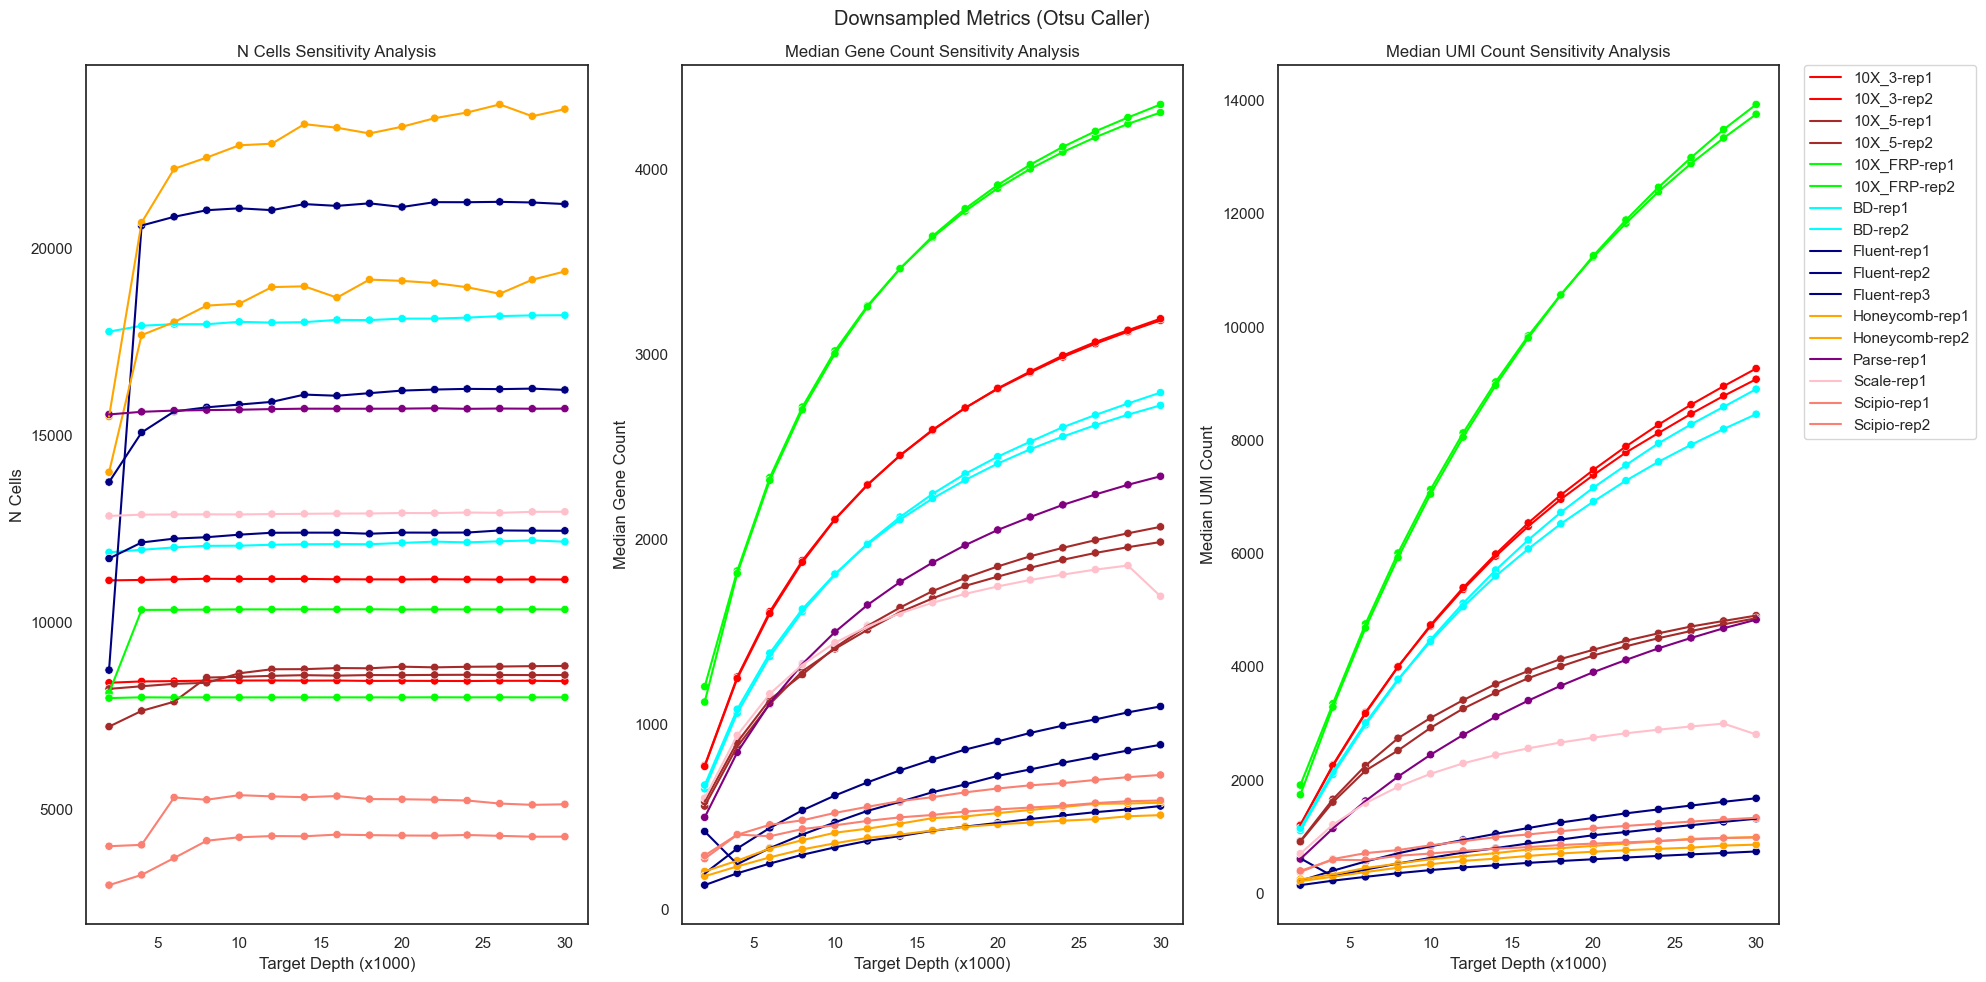

In [59]:
##Define color space for each platform

##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='target_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_otsu, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='target_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_otsu, ax=axes[i], legend=None)

    # Give each subplot a title
    axes[i].set(xlabel = 'Target Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics (Otsu Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Actual Depth

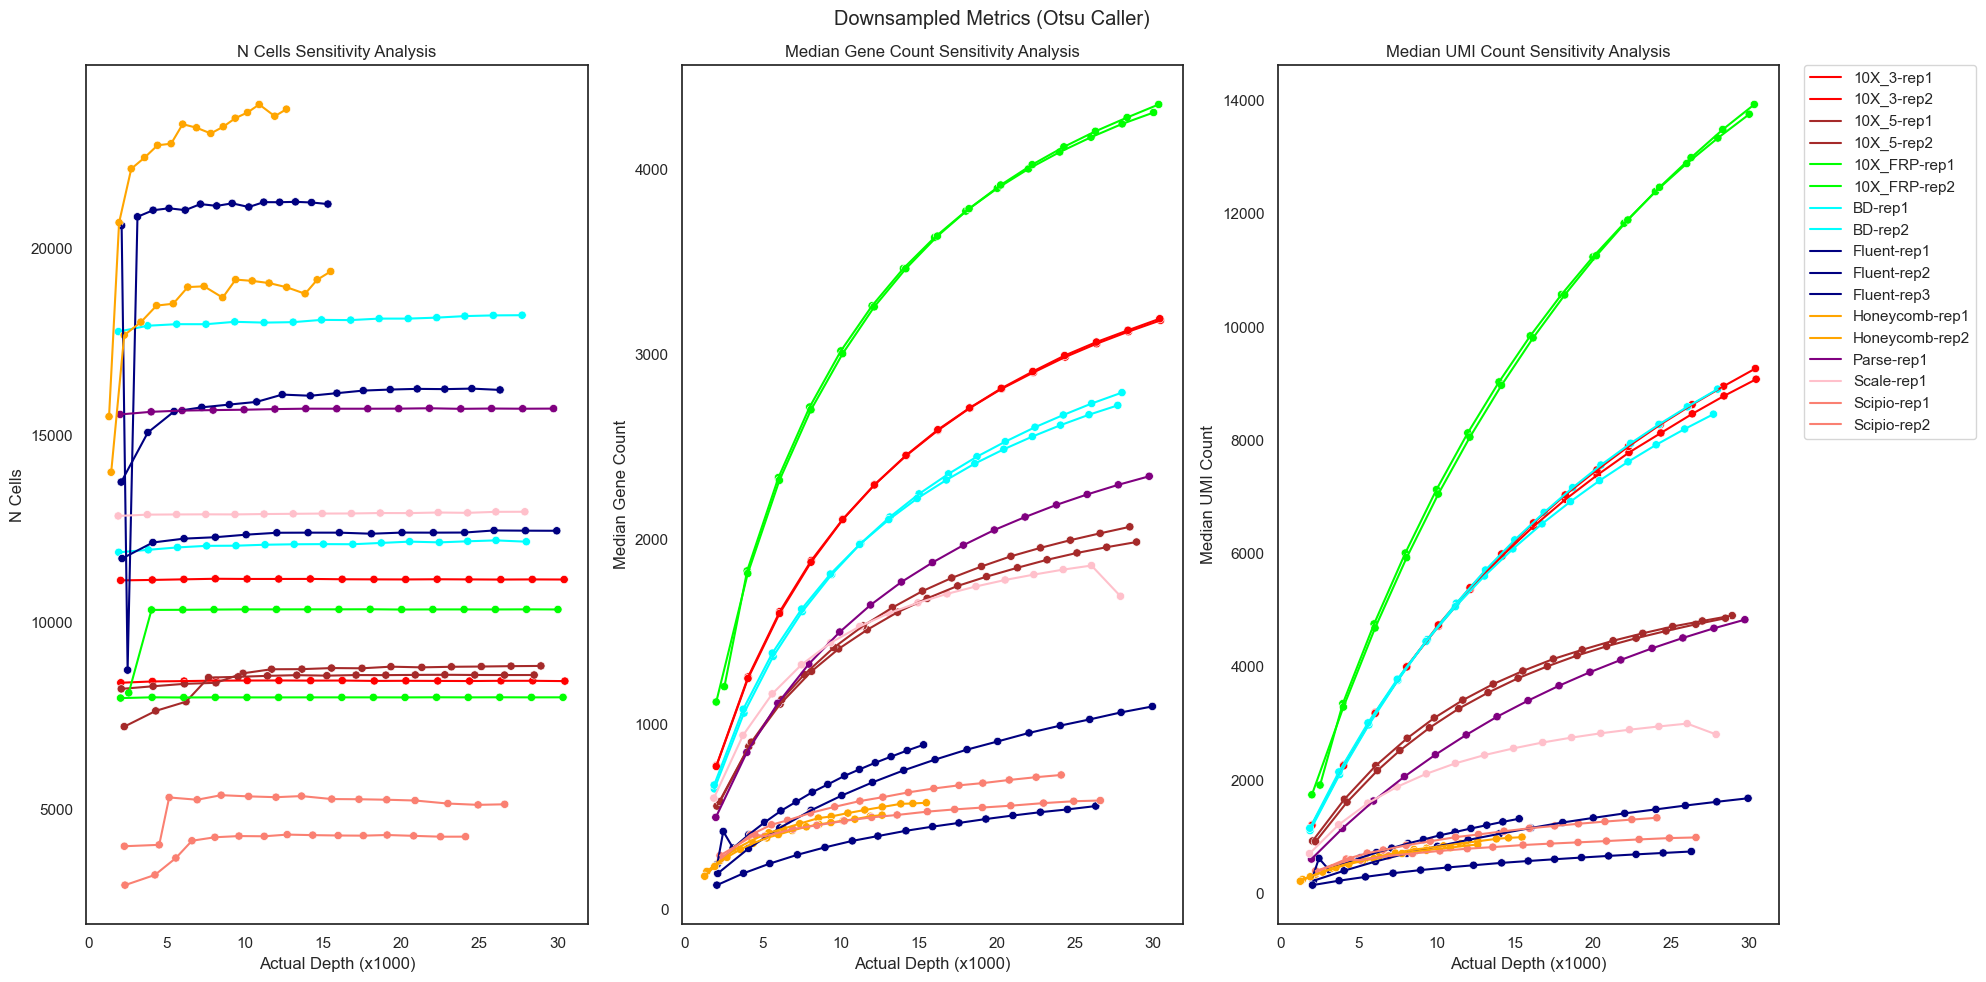

In [60]:


##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_otsu, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_otsu, ax=axes[i], legend=None)

    # Give each subplot a title
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics (Otsu Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Let's look only at Fluent since it is the one with varying cells in the internal callers

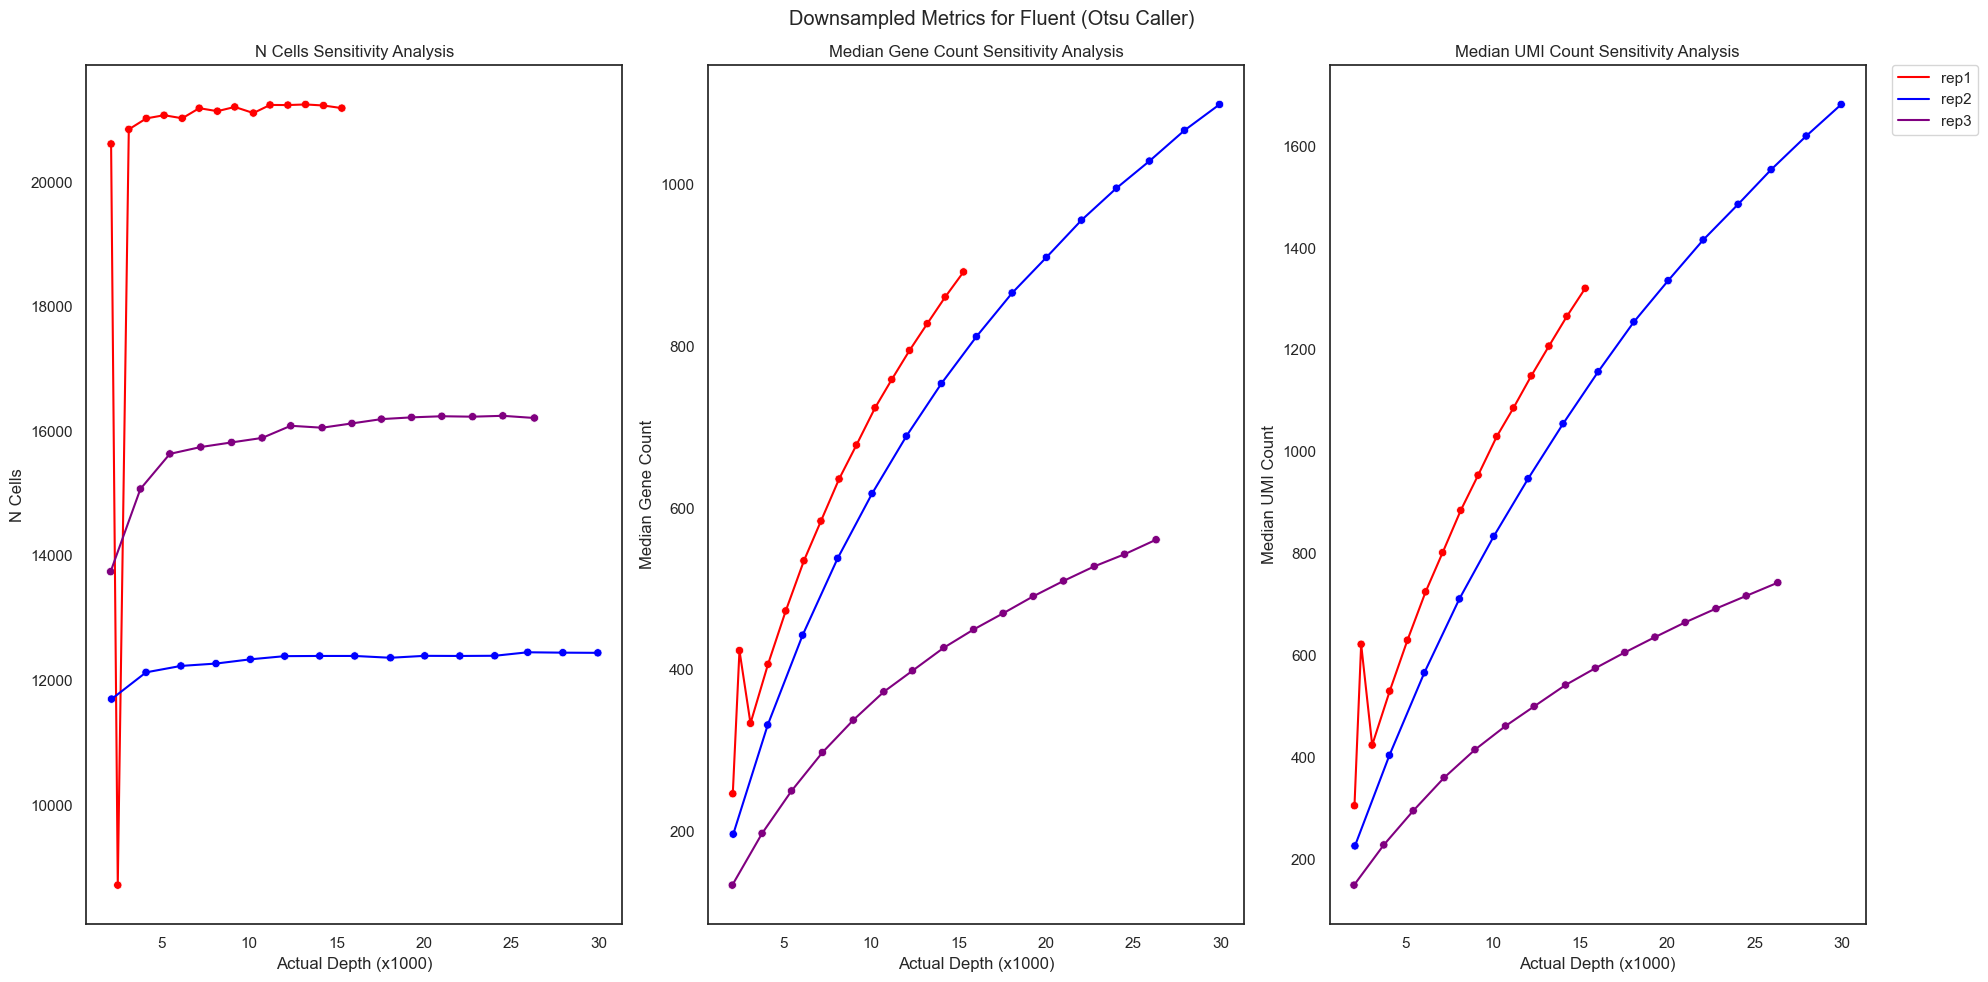

In [61]:
##Subset Fluent 
summary_df_otsu_fluent = summary_df_otsu[(summary_df_otsu['method'].isin(['Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3']))]

##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='replicate', palette=colors_replicate, data=summary_df_otsu_fluent, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='replicate', palette=colors_replicate, data=summary_df_otsu_fluent, ax=axes[i], legend=None)

    # Give each subplot a title
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics for Fluent (Otsu Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Only N Cells

#### <center> KDE Caller

In [2]:
if process_all_downsamples_kde is True: 

    ##store summary results for kde
    summary_df_kde=[]

    ##Loop through unfiltered files to get kde cell calling results
    for key, file in unfiltered_files.items():

        ##split method and depth with regex using the underscore after rep[0-0] to split
        match = re.match(r"(.*rep[0-9]+)_(.*k)$", key)
        method = match.group(1) ##matches the method before the underscore
        depth = match.group(2)[:-1]  #matches the depth after the underscore and removes the "k" to make numberic

        ##If method starts with "10X_3p" or "10X_5p", replace "p" with an empty string to match other figures
        ##Also, replace Fluent-rep1 with Fluent-rep3 (the repeat experiment since Fluent-rep1 was an outlier)
        if method.startswith("10X_3p"):
            method = re.sub("10X_3p-rep", "10X_3-rep", method)
        elif method.startswith("10X_5p"):
            method = re.sub("10X_5p-rep", "10X_5-rep", method)
        elif method.startswith("BD_Rhapsody"):
            method = re.sub("BD_Rhapsody-rep", "BD-rep", method)

        ##message for which platform and downsample we are doing
        print(f"Processing {method} at depth {depth} for KDE...")

        ##Load count matrix so we can get summaries (load meethod depends on filename)
        if re.match(r'.*10X.*', file):
            adata = load_raw_AnnData(file)
        else:
            adata = load_AnnData(file)

        ##select stringent/conservative filtering
        sel_threshold_i=-1

        ##set log_base to 10
        log_base=10

        ##set bandwidth
        bw_method=0.25
        bw_adjust=1

        ##get thresholds and umi data needed for plotting (Only filter requirement is that genes need at least 1 cell and cells need at least 1 gene)
        log_thresholds, converted_thresholds, chosen_threshold, log_umis, sorted_umis, ranks, n_cells, freq = threshold_raw_kde(adata, 
                                                                                                                           bw_method=bw_method, 
                                                                                                                           bw_adjust=bw_adjust, 
                                                                                                                           min_genes=1,
                                                                                                                           min_cells=1,
                                                                                                                           selected_threshold_i=sel_threshold_i, 
                                                                                                                           log_base=log_base, 
                                                                                                                           lb_percentile=0.1, 
                                                                                                                           ub_percentile=0.9) 
        
        #plot cell calling plots and save figure if it is 30k sample
        cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
        output_dir = os.path.join(cell_calling_dir, 'downsammpled_figures')
        os.makedirs(output_dir, exist_ok=True)
        
        if "30k" in key:
            plot_cell_calling_kde(adata, method, log_thresholds, converted_thresholds, chosen_threshold, 
                          log_umis, sorted_umis, ranks, n_cells, freq,
                          log_base=log_base, save_fig=True, output_dir=output_dir, figsize=(10,4), 
                          legend_labels=None, bins=75, 
                          bw_method=bw_method, bw_adjust=bw_adjust)
            
        ##subset adata to selected barcodes
        ##identify filtered barcodes by thresholding on total umi counts
        selected_barcodes=adata[adata.obs["total_counts"] >= chosen_threshold].obs_names
        adata = adata[selected_barcodes]


        ##delete adata for memory
        ##Get summary stats for each platform downsample
        summary_df_kde.append({'key':f'{method}_{depth}k', 'method': method, 'target_depth_tens': depth,
                               'n_cells':n_cells, 
                               'median_gene_counts': np.median(adata.obs['n_genes_by_counts']),
                               'median_umi_counts': np.median(adata.obs['total_counts']), 
                               'mean_gene_counts': np.mean(adata.obs['n_genes_by_counts']),
                               'mean_umi_counts': np.mean(adata.obs['total_counts']),
                               'sd_gene_counts': np.std(adata.obs['n_genes_by_counts']),
                               'sd_umi_counts': np.std(adata.obs['total_counts'])
                          })





    ##Convert to dataframe
    summary_df_kde = pd.DataFrame(summary_df_kde)
    summary_df_kde.set_index('key', inplace = True) ##set key as index
    summary_df_kde.index.name=None ##remove index name
    summary_df_kde['target_depth_tens'] = summary_df_kde['target_depth_tens'].astype(int) ##convert depth to integer

    ##Extract Platform name and replicate separately
    summary_df_kde['platform'] = summary_df_kde['method'].str.extract(r'(.*(?=-rep\d))')
    summary_df_kde['replicate'] = summary_df_kde['method'].str.extract(r'(rep[1-9])')
    
    ##calculate Target Readcounts (ie readcount we targetted to get desired depth given original cell counts)
    targeted_reads={}
    for k in list(range(2,32,2)):

        ##get depth
        depth=k*1000

        ##Loop through each platform to calc targetted reads per depth
        for method, og_cell in original_cell_counts.items():
            targeted_reads[f'{method}_{k}k'] = depth * og_cell
            
    ##Add these numbers back to summary df so we can compare targeted depth vs actual depth
    summary_df_kde['targeted_fastq_reads'] = summary_df_kde.index.map(targeted_reads)
    summary_df_kde['target_depth']=summary_df_kde['target_depth_tens']*1000
    summary_df_kde['actual_depth']=summary_df_kde['targeted_fastq_reads']/summary_df_kde['n_cells']
    summary_df_kde['actual_depth_tens']=summary_df_kde['actual_depth']/1000
    
    
    ##save summary
    cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
    output_file_kde = os.path.join(cell_calling_dir, "all_downsampled_kde_results.csv")

    summary_df_kde.to_csv(output_file_kde)
    
    
else:
    cell_calling_dir = os.path.join(parent_dir, 'cell_calling')
    output_file_kde = os.path.join(cell_calling_dir, "all_downsampled_kde_results.csv")
    summary_df_kde = pd.read_csv(output_file_kde, index_col=0)
    

summary_df_kde

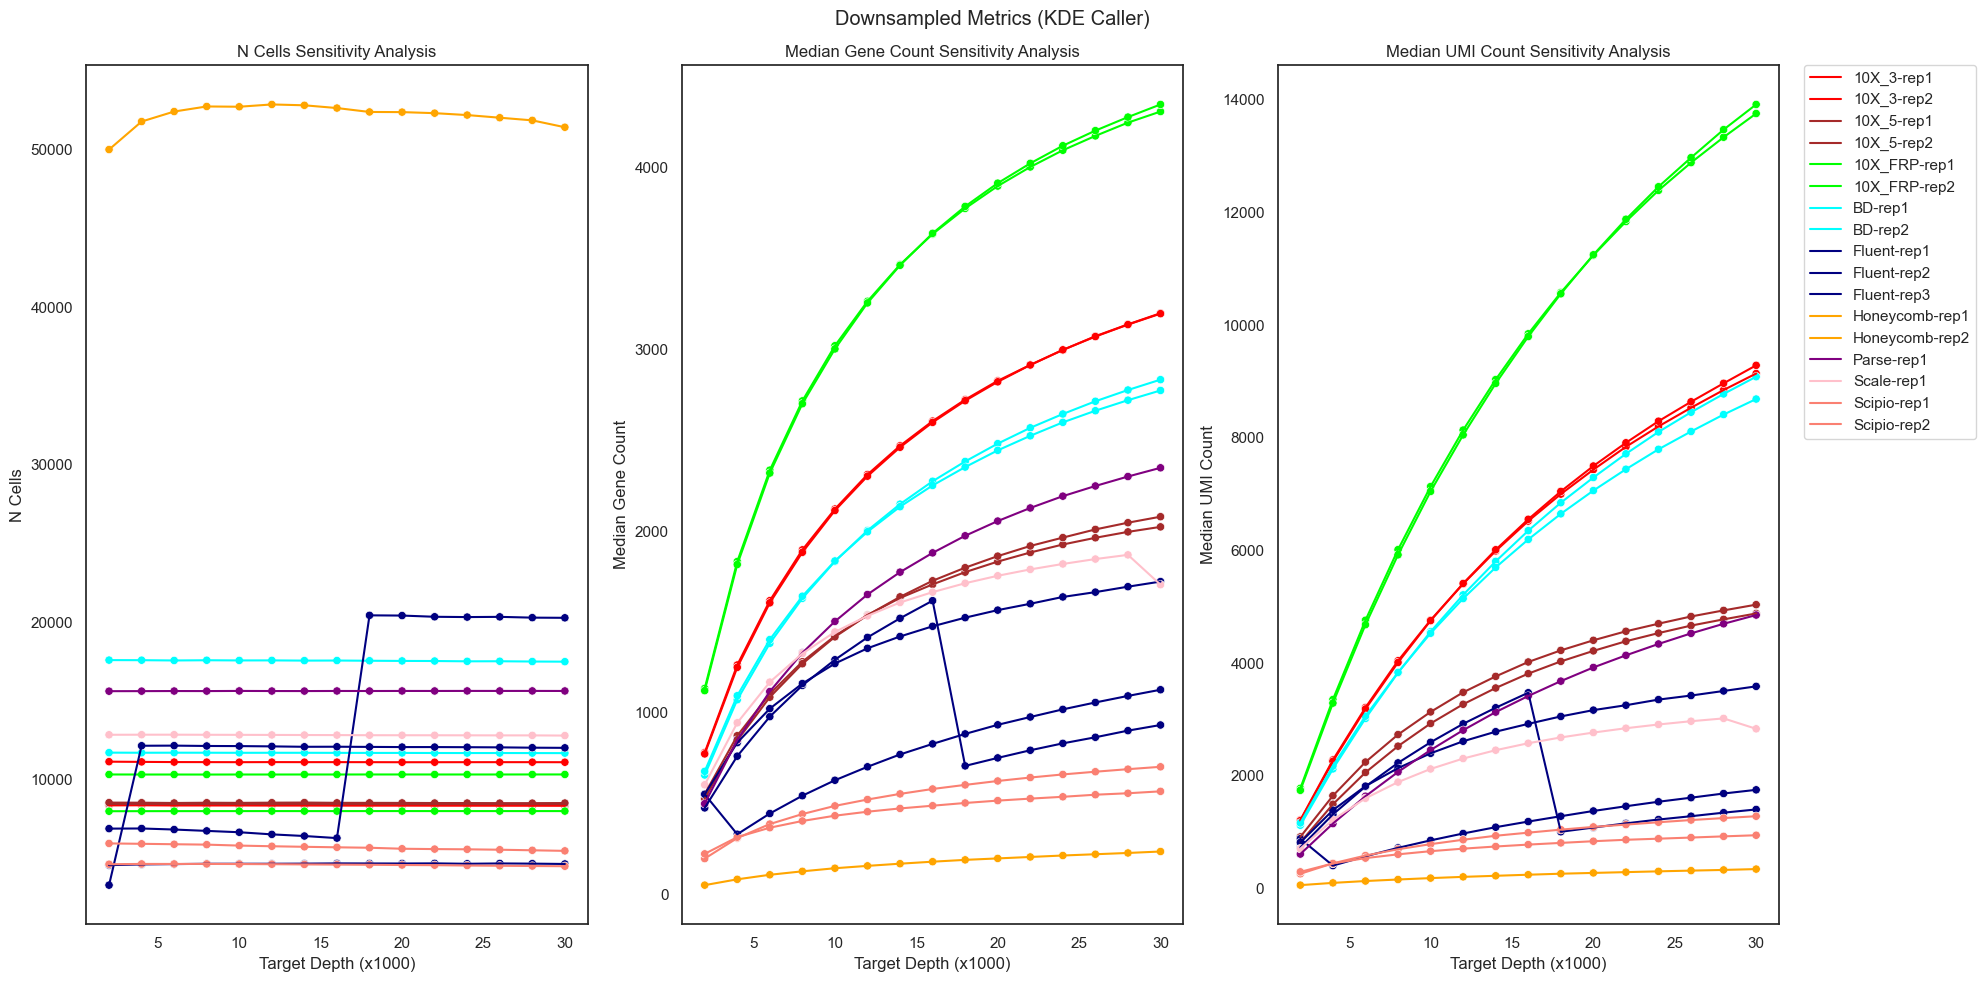

In [63]:
##Define color space for each platform



##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='target_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_kde, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='target_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_kde, ax=axes[i], legend=None)

    # Give each subplot a title
    axes[i].set(xlabel = 'Target Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics (KDE Caller)")
plt.tight_layout()

# Show the plot
plt.show()

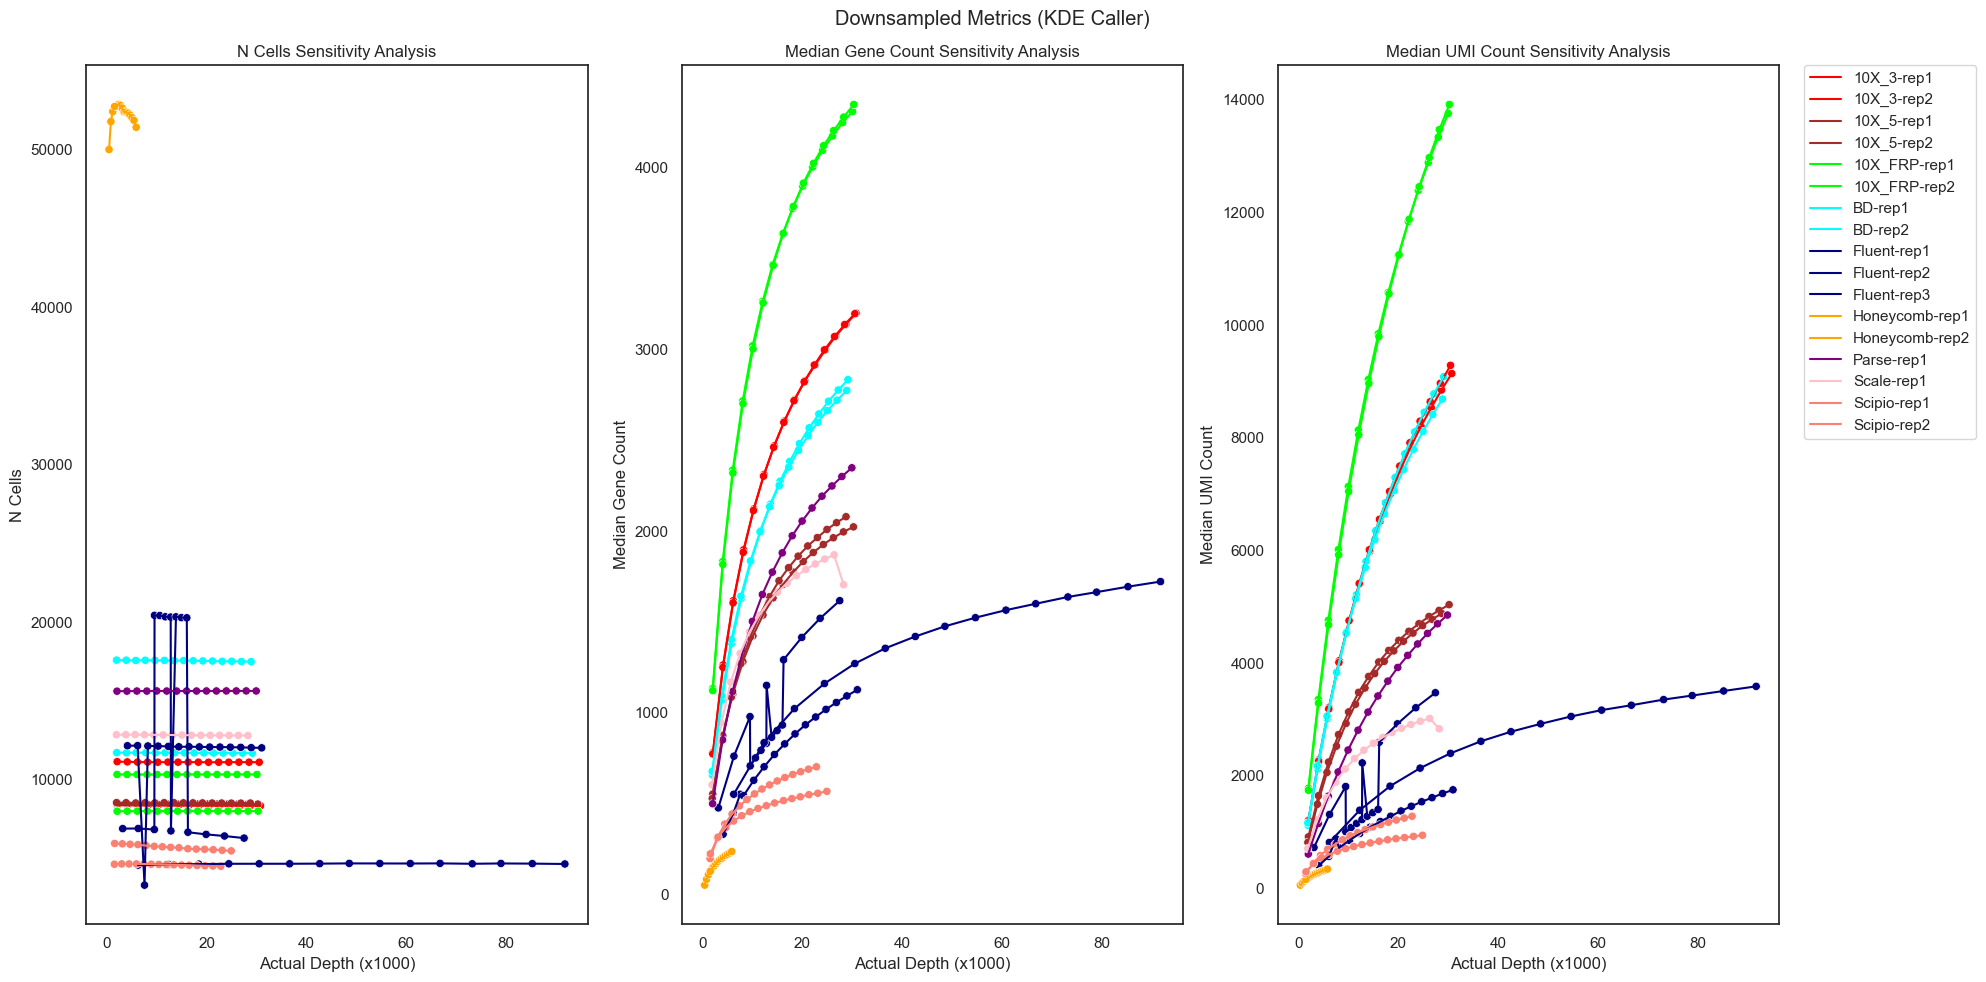

In [64]:
##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_kde, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='method', palette=colors_platform, data=summary_df_kde, ax=axes[i], legend=None)

    # Give each subplot a title
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics (KDE Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Plot only Fluent since it is the one with varying numbers of cells

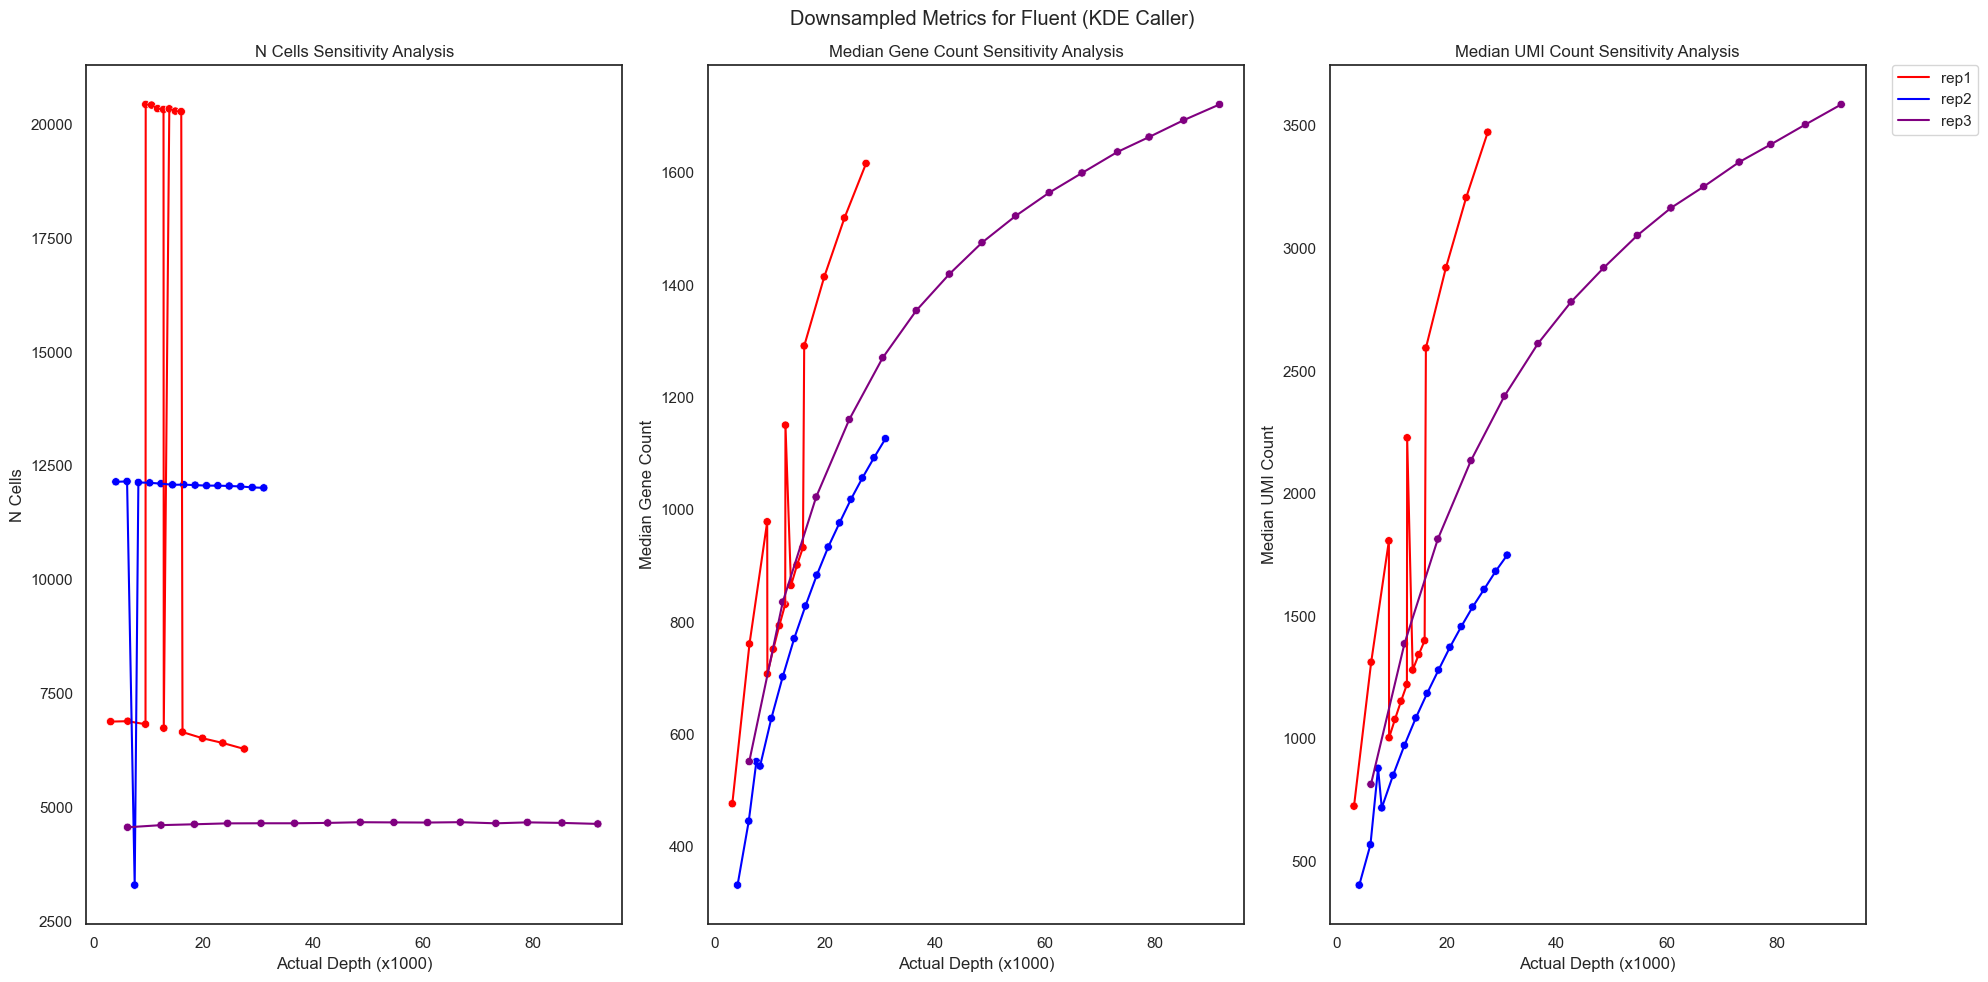

In [65]:
##Subset Fluent 
summary_df_kde_fluent = summary_df_kde[summary_df_kde['method'].isin(['Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3'])]

##Create subplot space with 3 rows (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  

##Create titles for each metric
y_labs = ['N Cells', 'Median Gene Count', 'Median UMI Count']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells', 'median_gene_counts', 'median_umi_counts']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='replicate', palette=colors_replicate, data=summary_df_kde_fluent, ax=axes[i])

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='replicate', palette=colors_replicate, data=summary_df_kde_fluent, ax=axes[i], legend=None)

    # Give each subplot a title
    axes[i].set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    axes[i].set_title(f"{y_lab} Sensitivity Analysis")

    # Remove legend from the first two plots
    if i != 2:
        axes[i].get_legend().remove()
    else:
        # Shift the legend to right of the plot
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
fig.suptitle("Downsampled Metrics for Fluent (KDE Caller)")
plt.tight_layout()

# Show the plot
plt.show()

Only N Cells

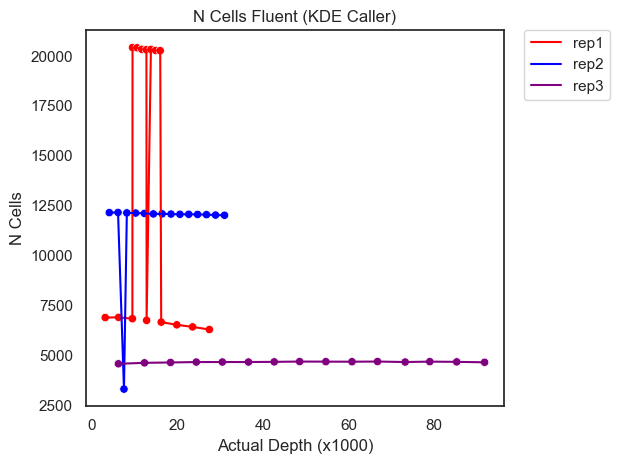

In [66]:
##Subset Fluent 
summary_df_kde_fluent = summary_df_kde[summary_df_kde['method'].isin(['Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3'])]

##Create subplot space with 3 rows (one for each metric)
fig, ax = plt.subplots(1, 1)  

##Create titles for each metric
y_labs = ['N Cells']

# Iterate over y_vals to create an overlaid line and scatter plot for each metric
for (i, y_val), y_lab in zip(enumerate(['n_cells']), y_labs):

    # Create line plot on ith subplot axes
    sns.lineplot(x='actual_depth_tens', y=y_val, hue='replicate', palette=colors_replicate, data=summary_df_kde_fluent, ax=ax)

    # Create scatter plot on ith subplot axes (overlay)
    sns.scatterplot(x='actual_depth_tens', y=y_val, hue='replicate', palette=colors_replicate, data=summary_df_kde_fluent, ax=ax, legend=None)

    # Give each subplot a title
    ax.set(xlabel = 'Actual Depth (x1000)', ylabel = y_lab)
    ax.set_title(f"{y_lab} Fluent (KDE Caller)")

    # Shift the legend to right of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Adjust the padding between and around the subplots
plt.tight_layout()

# Show the plot
plt.show()

Neither are really able to resolve Fluent across all replicates, but there appears to be some minor improvements in stability that change drastically at occassional downsamples, so more work would need to be done to get a stable and accurate caller at all depths. Additonally must note that Honeycomb's caller always yields 10000 because it simply returns the number of cells requested by the user, which is also a concern.